In [1]:
### Import packages
import numpy as np
import pandas as pd
# import seaborn
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json

# Packages for processing and learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Packages for evaluation
# from numpy import mean
# from numpy import std
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from textwrap import wrap

# Models
import optuna
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
# Neural Network


# Sensitivity Analysis
import math
# from SALib.analyze import rbd_fast
from SALib.sample.sobol import sample as ss
from SALib.analyze.sobol import analyze as sa

seed = 42
from matplotlib import rc,rcParams
rc('font', weight='bold')

# Change cell width to fullscreen (like colab)
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def OHEncoder_Func(data_input, column):
    '''OneHotEncoder - Encodes and replaces new encoded data to given dataframe'''
    # Extract the categorical columns
    df_categorical = data_input[column].to_frame()
    # Fit and transform the data
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(df_categorical)
    # Ensure categorical columns are of type object or categorical
    df_categorical = df_categorical.astype('category')
    # Get feature names and remove the prefix from feature names
    feature_names = encoder.get_feature_names_out(df_categorical.columns)
    feature_names = [name.split('_')[-1] for name in feature_names]
    # Store in dataframe with encoded data and feature names
    encoded_data = pd.DataFrame(encoded_data.toarray(), columns=feature_names)
    encoded_data = pd.concat([data_input, encoded_data], axis=1)
    # Drop the original columns that were one-hot encoded
    encoded_data.drop(column, axis=1, inplace=True)
    return encoded_data

In [3]:
def Standardizer_Func(data, features_list):
    '''Standardizes data and replaces the original values in the given dataframe'''

    # Standardize the features (mean=0 and variance=1)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[features_list])
    # Replace original values with standardized values
    data[features_list] = x_scaled
    
    return data

In [4]:
def Preprocess_Func(f_path, in_var, out_var, mat_list):
    '''Reads data from file path and stores in dataframe for interested input, output features for ML and materials to filter dataframe.
       Uses OneHotEncoding to retrieve whether material is AB, HT or HIP.'''
    
    dataset = pd.read_excel(f_path)
    column_names = dataset.columns
    variable_list = in_var + out_var

    # Change treatment title - optional
    dataset.rename(columns={'Treated (HIP/Y/N)':'Treatment Information'}, inplace=True)
    dataset.rename(columns={'Cell Spacing':'Cell Spacing (um)'}, inplace=True)
    column_names = dataset.columns
    # Change (um) to correct scientific symbol
    dataset.columns = [str.replace('(um)', '(\u03BCm)') for str in column_names]
    dataset = dataset.replace(r'/s+', np.nan, regex =True)

    # Searches selected variable's index number
    col_index = []
    for i in range(len(variable_list)): 
        col_index.append(column_names.get_loc(variable_list[i]))
    # Change (um) to correct scientific symbol
    variable_list = [str.replace('(um)', '(\u03BCm)') for str in variable_list]
    in_var = [str.replace('(um)', '(\u03BCm)') for str in in_var]
    out_var = [str.replace('(um)', '(\u03BCm)') for str in out_var]
    #col_index.append(column_names.get_loc(variable_list[i]))
    # Converts whole dataset to df and filters necessary columns 
    dataset = dataset[dataset.columns[col_index]]

    # Replace '174PH' with '17-4PH'
    dataset.loc[dataset['Material'] == '174PH', 'Material'] = '17-4PH'
    # Replace 'MS' with '18Ni300'
    dataset.loc[dataset['Material'] == 'MS', 'Material'] = '18Ni300'
    # Replace N and NaN values for treatment information as As Built
    dataset.loc[dataset['Treatment Information'] == 'N', 'Treatment Information'] = 'As Built'
    dataset['Treatment Information'] = dataset['Treatment Information'].fillna('As Built')
    # Replace other treatment information 
    dataset['Treatment Information'] = dataset['Treatment Information'].replace(['Y', 'SR', 'y'], 'Heat Treated')


    # Filter data to specified materials
    dataset = dataset[dataset['Material'].isin(mat_list)].reset_index(drop=True)

    # Encode treatment information and materials data
    df_encoded = OHEncoder_Func(data_input=dataset, column='Treatment Information')
    df_encoded = OHEncoder_Func(data_input=df_encoded, column='Material')

    in_var = in_var.copy()
    in_var.remove('Treatment Information')
    x_df = df_encoded.drop(columns=out_var)
    y_df = df_encoded[out_var]

    return x_df, y_df

In [5]:
def Preprocess_Func(f_path, in_var, out_var, mat_list):
    '''Reads data from file path and stores in dataframe for interested input, output features for ML and materials to filter dataframe.
       Uses temperature, time and pressure to predict (encompasses whether its AB, HT or HIP indirectly).'''
    
    dataset = pd.read_excel(f_path)
    column_names = dataset.columns
    variable_list = in_var + out_var

    # Change treatment title - optional
    dataset.rename(columns={'Treated (HIP/Y/N)':'Treatment Information'}, inplace=True)
    dataset.rename(columns={'Cell Spacing':'Cell Spacing (um)'}, inplace=True)
    column_names = dataset.columns
    # Change (um) to correct scientific symbol
    dataset.columns = [str.replace('(um)', '(\u03BCm)') for str in column_names]
    dataset = dataset.replace(r'/s+', np.nan, regex =True)

    # Searches selected variable's index number
    col_index = []
    for i in range(len(variable_list)): 
        col_index.append(column_names.get_loc(variable_list[i]))
    # Change (um) to correct scientific symbol
    variable_list = [str.replace('(um)', '(\u03BCm)') for str in variable_list]
    in_var = [str.replace('(um)', '(\u03BCm)') for str in in_var]
    out_var = [str.replace('(um)', '(\u03BCm)') for str in out_var]
    #col_index.append(column_names.get_loc(variable_list[i]))
    # Converts whole dataset to df and filters necessary columns 
    dataset = dataset[dataset.columns[col_index]]

    # Replace '174PH' with '17-4PH'
    dataset.loc[dataset['Material'] == '174PH', 'Material'] = '17-4PH'
    # Replace 'MS' with '18Ni300'
    dataset.loc[dataset['Material'] == 'MS', 'Material'] = '18Ni300'
    # Replace N and NaN values for treatment information as As Built
    dataset.loc[dataset['Treatment Information'] == 'N', 'Treatment Information'] = 'As Built'
    dataset['Treatment Information'] = dataset['Treatment Information'].fillna('As Built')
    # Replace other treatment information 
    dataset['Treatment Information'] = dataset['Treatment Information'].replace(['Y', 'SR', 'y'], 'Heat Treated')

    # Filter data to specified materials
    dataset = dataset[dataset['Material'].isin(mat_list)].reset_index(drop=True)

    # Encode materials data
    df_encoded = OHEncoder_Func(data_input=dataset, column='Material')
    x_df = df_encoded.drop(columns=out_var)
    y_df = df_encoded[out_var]

    # Fill empty values with appropriate AB conditions
    x_df['Temperature (°C)'] = x_df['Temperature (°C)'].fillna(20)
    x_df['Time (Hrs)'] = x_df['Time (Hrs)'].fillna(0)
    x_df['Pressure (MPa)'] = x_df['Pressure (MPa)'].fillna(0.1)

    return x_df, y_df

In [6]:
def Train_Test_Func(x_data, y_data, test_ratio=0.2):
    '''Splits train/test data and drops NaN per given output in y_data - maximises number of data to train/test'''

    train_data = []
    test_data = []

    for i in y_data.columns:
        # Create new dataframe for each output and drop data to maximise amount
        tmp_df = x_data.join(y_data[i]).dropna()

        # Train/Test to 80/20 split - no validation set as we will use CV
        X_train, X_test, y_train, y_test = train_test_split(tmp_df[x_data.columns], tmp_df[i].to_frame(), test_size=test_ratio, random_state=seed)

        train_data.append([X_train, y_train])
        test_data.append([X_test, y_test])

    for i in range(0, len(train_data)):
        variable = train_data[i][1].columns.to_list()[0]
        total_data = len(y_df)
        remain_data = len(train_data[i][0])
        dropped_data = total_data - remain_data
        print(" Variable: ", variable, "\n", "Total data = ", total_data, "\n", "Dropped data = ", dropped_data, "\n", "Remaining data = ", remain_data, "\n")

    # Scale inputs for training - keep non scaled too for visualisation
    train_data_scaled = copy.deepcopy(train_data)
    test_data_scaled = copy.deepcopy(test_data)
    input_params = ['Laser Power (W)', 'Scanning Speed (mm/s)', 'Layer Thickness (μm)', 'Hatch Spacing (μm)',
                      'Temperature (°C)', 'Time (Hrs)', 'Pressure (MPa)']
    tmp = []
    for x,y in train_data_scaled:
        # Standardize the features (mean=0 and variance=1)
        x = Standardizer_Func(data=x, features_list=input_params)

    for x,y in test_data_scaled:
        # Standardize the features (mean=0 and variance=1)
        x = Standardizer_Func(data=x, features_list=input_params)

    # Log transform consolidation data to differentiate small changes in high consolidation
    train_data_scaled[3][1] = train_data_scaled[3][1].apply(lambda x: np.log10(x))
    test_data_scaled[3][1] = test_data_scaled[3][1].apply(lambda x: np.log10(x))

    # Store indexes for testing
    x_index_nt = []
    x_index_ht = []
    x_index_hip = []
    for n in range(4):
        x_index_nt.append(test_data_scaled[n][0]['Treatment Information'] == 'As Built')
        x_index_ht.append(test_data_scaled[n][0]['Treatment Information'] == 'Heat Treated')
        x_index_hip.append(test_data_scaled[n][0]['Treatment Information'] == 'HIP')
        
        train_data[n][0] = train_data[n][0].drop(columns=['Treatment Information'])
        test_data[n][0] = test_data[n][0].drop(columns=['Treatment Information'])
        train_data_scaled[n][0] = train_data_scaled[n][0].drop(columns=['Treatment Information'])
        test_data_scaled[n][0] = test_data_scaled[n][0].drop(columns=['Treatment Information'])

    return train_data, test_data, train_data_scaled, test_data_scaled, x_index_nt, x_index_ht, x_index_hip

In [7]:
# Choose materials and features input and outputs
materials_list = ['316L', 'IN718', 'TI6Al4V', 'AlSi10Mg']
input_var = ['Material',
             'Laser Power (W)',
             'Scanning Speed (mm/s)',
             'Layer Thickness (um)',
             'Hatch Spacing (um)',
             'Treatment Information',
             'Temperature (°C)',
             'Time (Hrs)',
             'Pressure (MPa)']

output_var = ['Yield Stress (MPa)',
              'Average Work Hardening',
              'Elongation (%)',
              'Consolidation (%)']

path = r'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Process Parameters and Properties LPBF - New.xlsx'

# Read and filter data based on inputs, outputs and materials
x_df, y_df = Preprocess_Func(f_path=path, in_var=input_var, out_var=output_var, mat_list=materials_list)
# Store train/test data and drop NaN values for each output individually
train_df, test_df, train_scaled, test_scaled, index_nt, index_ht, index_hip = Train_Test_Func(x_data=x_df, y_data=y_df, test_ratio=0.2)

 Variable:  Yield Stress (MPa) 
 Total data =  2692 
 Dropped data =  1891 
 Remaining data =  801 

 Variable:  Average Work Hardening 
 Total data =  2692 
 Dropped data =  1987 
 Remaining data =  705 

 Variable:  Elongation (%) 
 Total data =  2692 
 Dropped data =  1890 
 Remaining data =  802 

 Variable:  Consolidation (%) 
 Total data =  2692 
 Dropped data =  1253 
 Remaining data =  1439 



In [15]:
# Choose materials and features input and outputs
materials_list = ['316L', 'IN718', 'TI6Al4V', 'AlSi10Mg']
input_var = ['Material',
             'Laser Power (W)',
             'Scanning Speed (mm/s)',
             'Layer Thickness (um)',
             'Beam size (um)',
             'Scanning strategy',
             'Hatch Spacing (um)',
             'Treatment Information',
             'Temperature (°C)',
             'Time (Hrs)',
             'Pressure (MPa)']

output_var = ['Yield Stress (MPa)',
              'Average Work Hardening',
              'Elongation (%)',
              'Consolidation (%)']

path = r'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Process Parameters and Properties LPBF - New.xlsx'

# Read and filter data based on inputs, outputs and materials
x_df, y_df = Preprocess_Func(f_path=path, in_var=input_var, out_var=output_var, mat_list=materials_list)
# Store train/test data and drop NaN values for each output individually
train_df, test_df, train_scaled, test_scaled, index_nt, index_ht, index_hip = Train_Test_Func(x_data=x_df, y_data=y_df, test_ratio=0.2)

 Variable:  Yield Stress (MPa) 
 Total data =  2692 
 Dropped data =  2460 
 Remaining data =  232 

 Variable:  Average Work Hardening 
 Total data =  2692 
 Dropped data =  2471 
 Remaining data =  221 

 Variable:  Elongation (%) 
 Total data =  2692 
 Dropped data =  2436 
 Remaining data =  256 

 Variable:  Consolidation (%) 
 Total data =  2692 
 Dropped data =  2140 
 Remaining data =  552 



In [14]:
train_df[0][0]

Laser Power (W)  Scanning Speed (mm/s)  Layer Thickness (μm)  \
449             200.0                 1000.0                  40.0   
2329            400.0                  900.0                  30.0   
37              950.0                  320.0                 100.0   
2045            195.0                  625.0                  60.0   
2163            150.0                  700.0                  30.0   
...               ...                    ...                   ...   
589             150.0                  700.0                  20.0   
1580            340.0                 1300.0                  30.0   
2073            200.0                  800.0                  30.0   
2322            400.0                  900.0                  30.0   
585             100.0                  700.0                  20.0   

     Scanning strategy  Hatch Spacing (μm)  Temperature (°C)  Time (Hrs)  \
449             Stripe               120.0              20.0         0.0   
2329            Raster               120.0             980.0         1.0   
37         chessboard                500.0              20.0         0.0   
2045            stripe               110.0              20.0         0.0   
2163            island               105.0              20.0         0.0   
...                ...                 ...               ...         ...   
589         Chessboard                50.0              20.0         0.0   
1580           Meander               200.0              20.0         0.0   
2073            Raster               120.0             600.0         1.0   
2322            Stripe               120.0             980.0         1.0   
585         Chessboard                50.0              20.0         0.0   

      Pressure (MPa)  316L  AlSi10Mg  IN718  TI6Al4V  
449              0.1   1.0       0.0    0.0      0.0  
2329             0.1   0.0       0.0    1.0      0.0  
37               0.1   0.0       0.0    1.0      0.0  
2045             0.1   1.0       0.0    0.0      0.0  
2163             0.1   1.0       0.0    0.0      0.0  
...              ...   ...       ...    ...      ...  
589              0.1   1.0       0.0    0.0      0.0  
1580             0.1   0.0       1.0    0.0      0.0  
2073             0.1   1.0       0.0    0.0      0.0  
2322             0.1   0.0       0.0    1.0      0.0  
585              0.1   1.0       0.0    0.0      0.0  

[404 rows x 12 columns]

In [9]:
train_scaled[0][0]

Laser Power (W)  Scanning Speed (mm/s)  Layer Thickness (μm)  \
2034        -0.356676              -0.553082              0.778289   
2233        -0.389388              -0.157069              0.778289   
2056        -1.207206               0.182371             -0.689132   
2175         0.788269               1.087545              0.289148   
2104        -0.487526              -0.722802              0.289148   
...               ...                    ...                   ...   
462          0.003164               0.295518             -0.199992   
1023        -0.323963               0.295518              0.289148   
2489         0.264866              -0.157069             -0.689132   
1878         1.638800               0.951769              0.778289   
458         -0.323963              -0.609655             -0.199992   

      Hatch Spacing (μm)  Temperature (°C)  Time (Hrs)  Pressure (MPa)  316L  \
2034           -0.064863         -0.750726   -0.082952       -0.202978   1.0   
2233           -0.439675         -0.750726   -0.082952       -0.202978   1.0   
2056           -1.189300         -0.750726   -0.082952       -0.202978   1.0   
2175           -0.439675         -0.750726   -0.082952       -0.202978   1.0   
2104           -0.252269         -0.750726   -0.082952       -0.202978   1.0   
...                  ...               ...         ...             ...   ...   
462            -0.627082         -0.750726   -0.082952       -0.202978   1.0   
1023           -0.252269         -0.750726   -0.082952       -0.202978   0.0   
2489           -1.189300         -0.750726   -0.082952       -0.202978   1.0   
1878           -0.589600          0.831206    0.057483       -0.202978   0.0   
458             0.122543         -0.750726   -0.082952       -0.202978   1.0   

      AlSi10Mg  IN718  TI6Al4V  
2034       0.0    0.0      0.0  
2233       0.0    0.0      0.0  
2056       0.0    0.0      0.0  
2175       0.0    0.0      0.0  
2104       0.0    0.0      0.0  
...        ...    ...      ...  
462        0.0    0.0      0.0  
1023       0.0    0.0      1.0  
2489       0.0    0.0      0.0  
1878       0.0    0.0      1.0  
458        0.0    0.0      0.0  

[801 rows x 11 columns]

In [10]:
train_df[3][1]

Consolidation (%)
2616              99.20
2649              99.25
2522              98.00
229               98.11
1245              99.95
...                 ...
1818              98.90
2034              99.40
1015              99.31
2287              99.34
1609              99.17

[1439 rows x 1 columns]

In [11]:
train_scaled[3][1]

Consolidation (%)
2616           1.996512
2649           1.996731
2522           1.991226
229            1.991713
1245           1.999783
...                 ...
1818           1.995196
2034           1.997386
1015           1.996993
2287           1.997124
1609           1.996380

[1439 rows x 1 columns]

In [12]:
test_scaled[1][0]

Laser Power (W)  Scanning Speed (mm/s)  Layer Thickness (μm)  \
275          0.431390              -0.303638             -0.269709   
1562         0.431390               0.408677              0.402664   
448          0.431390               0.115371              1.075036   
1975         0.937037               4.305461              1.075036   
1986        -0.212162              -0.303638              1.075036   
...               ...                    ...                   ...   
243          7.096743               2.000912              0.402664   
1026        -0.028290               1.372398             -0.942081   
2233        -0.304097              -0.303638              1.075036   
2403         0.132598               0.010618             -0.269709   
2063        -0.658051              -0.513143             -1.614453   

      Hatch Spacing (μm)  Temperature (°C)  Time (Hrs)  Pressure (MPa)  316L  \
275             0.178055          1.714262   -0.193043       -0.179888   0.0   
1562            1.203289          0.459621   -0.002157       -0.179888   0.0   
448             1.818429          1.910743    0.150552       -0.175206   1.0   
1975           -0.232039         -0.439934    0.608677       -0.179888   0.0   
1986           -0.232039         -0.439934    0.608677       -0.179888   0.0   
...                  ...               ...         ...             ...   ...   
243             0.793195         -0.795021   -0.307574       -0.179888   0.0   
1026           -1.052226          0.435948    0.455969       -0.179888   0.0   
2233           -0.437086         -0.795021   -0.307574       -0.179888   1.0   
2403           -0.642132         -0.795021   -0.307574       -0.179888   0.0   
2063           -0.642132         -0.795021   -0.307574       -0.179888   1.0   

      AlSi10Mg  IN718  TI6Al4V  
275        0.0    1.0      0.0  
1562       1.0    0.0      0.0  
448        0.0    0.0      0.0  
1975       1.0    0.0      0.0  
1986       1.0    0.0      0.0  
...        ...    ...      ...  
243        0.0    1.0      0.0  
1026       0.0    0.0      1.0  
2233       0.0    0.0      0.0  
2403       0.0    1.0      0.0  
2063       0.0    0.0      0.0  

[177 rows x 11 columns]

In [13]:
# Define plotting functions for visualisation
def plot_perf():
  def RegLine(x):
    return slope * x + intercept

  plt.rcParams.update({'font.size': 22})
  pad_size = 8
  txt_size = 24
  m_size = 130

  r2_list = []
  rmse_list = []
  bbox = dict(boxstyle ="round", fc ="0.8")
  gr_loc = 'best'
  n=0
  lim1=[0,1500]
  lim2=[0,60]
  lim3=[0,100]
  lim4=[90,100]
  lims = [lim1, lim2, lim3, lim4]

  fig1 = plt.figure(figsize=(18+3,18+3))
  ax1 = fig1.add_subplot(221)
  ax2 = fig1.add_subplot(222)
  ax3 = fig1.add_subplot(223)
  ax4 = fig1.add_subplot(224)
  axs = [ax1, ax2, ax3, ax4]

  for n in range(4):
    x_index_nt = index_nt[n]
    x_index_ht = index_ht[n]
    x_index_hip = index_hip[n]
    axs[n].scatter(test_df[n][1][x_index_nt], predictions[n][x_index_nt], color='#45abb4', marker='o', s=m_size, edgecolors='k', label=(f'As Built'), zorder=5)
    axs[n].scatter(test_df[n][1][x_index_ht], predictions[n][x_index_ht], color='#3b5d8f', marker='^', s=m_size, edgecolors='k', label=(f'Heat Treated'), zorder=6)    
    axs[n].scatter(test_df[n][1][x_index_hip], predictions[n][x_index_hip], color='#68ccae', marker='s', s=m_size, edgecolors='k', label=(f'HIP'), zorder=7)   
    axs[n].set_xlabel(output_var[n], labelpad=pad_size, fontsize = txt_size, weight='bold')
    axs[n].set_ylabel((f'Predicted {output_var[n]}'), labelpad=pad_size, fontsize = txt_size, weight='bold')
    axs[n].plot([0, 1], [0, 1], transform=axs[n].transAxes, linewidth=3.5, color='r')
    axs[n].set_xlim([lims[n][0], lims[n][1]])
    axs[n].set_ylim([lims[n][0], lims[n][1]])
    axs[n].tick_params(axis='both', which='major', width=1.5, length=10)

    slope, intercept, r, p, std_err = stats.linregress(test_df[n][1].values.flatten(), predictions[n][:])

    print(f'{output_var[n]}')
    # The mean squared error
    print("Mean squared error, RMSE = %.2f" % root_mean_squared_error(test_df[n][1].values.flatten(), predictions[n][:]))
    # The coefficient of determination: 1 is perfect prediction
    # Check for difference between r and r2 
    # https://www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/#:~:text=Python%20%E2%80%93%20Coefficient%20of%20Determination-R2%20score.%20Coefficient%20of,is%20predictable%20from%20the%20input%20independent%20variable%20%28s%29.
    print("Coefficient of determination, r2 = %.2f" % r2_score(test_df[n][1].values.flatten(), predictions[n][:]))

    regline = list(map(RegLine, lims[n]))
    axs[n].plot(lims[n], regline, linewidth=3.5, color='k')
    axs[n].annotate(rf"$Y$ = {slope:.2f}$x + ${intercept:.2f}",
                        bbox = bbox, xy=(0.965, 0.045), xycoords='axes fraction', horizontalalignment='right', zorder=8)

    rmse_list.append(root_mean_squared_error(test_df[n][1].values.flatten(), predictions[n][:]))
    axs[n].annotate(rf"$RMSE$ = {abs(rmse_list[n]):.2f}",
                        bbox = bbox, xy=(0.965, 0.045+0.095), xycoords='axes fraction', horizontalalignment='right', zorder=9)

    r2_list.append(r2_score(test_df[n][1].values.flatten(), predictions[n][:]))
    axs[n].annotate(rf"$R^2$ = {abs(r2_list[n]):.2f}",
                        bbox = bbox, xy=(0.965, 0.045+0.095+0.095), xycoords='axes fraction', horizontalalignment='right', zorder=9)

  # ax1.legend(loc=gr_loc, ncol=1, edgecolor='black')
  ax1.legend(fontsize=txt_size, loc='center', bbox_to_anchor=(1.05, 1.1), edgecolor='black', ncol=4, markerscale=1.5)
  ax1.get_yaxis().set_label_coords(-0.15,0.5)
  ax2.get_yaxis().set_label_coords(-0.1,0.5)
  ax3.get_yaxis().set_label_coords(-0.15,0.5)
  ax4.get_yaxis().set_label_coords(-0.1,0.5)

  plt.show()

In [14]:
# Define function for calculating and visualising sobol indices
def Plot_Sobol(leg_loc='upper right'):
    bounds = []
    for x in train_scaled:
        bounds_tmp = []
        for n in range(train_scaled[0][0].shape[1]):
            tmp = np.array(x[0])
            lowerb = math.floor(tmp[:,n].min())
            upperb = math.ceil(tmp[:,n].max())
            bounds_tmp.append([lowerb,upperb])
        bounds.append(bounds_tmp)

    problem = {'num_vars': train_scaled[0][0].shape[1],
            'names': train_scaled[0][0].columns.tolist(),
            'bounds': bounds}

    # Generate sobol samples
    # Y = []
    S1_arr = []
    S1_Conf_arr = []
    ST_arr = []
    ST_Conf_arr = []
    for n,model in enumerate(models):
        problem = {'num_vars': train_scaled[0][0].shape[1],
                'names': train_scaled[0][0].columns.tolist(),
                'bounds': bounds[n]}
        sample = ss(problem, 100000, calc_second_order=False)
        Y = model.predict(sample)

        importance = sa(problem, Y, calc_second_order=False, print_to_console=False)

        # Normalise feature importance with process parameters only
        s1 = importance['S1'][:4]
        S1_arr.append(s1 / s1.sum())

        s1_conf = importance['S1_conf'][:4]
        S1_Conf_arr.append(s1_conf / s1_conf.sum())

        st = importance['ST'][:4]
        ST_arr.append(st / st.sum())

        st_conf = importance['ST_conf'][:4]
        ST_Conf_arr.append(st_conf / st_conf.sum())


    S1_arr = np.array(S1_arr)
    S1_Conf_arr = np.array(S1_Conf_arr)
    ST_arr = np.array(ST_arr)
    ST_Conf_arr = np.array(ST_Conf_arr)

    S1_imp = pd.DataFrame({"Output Properties": output_var,
                    "Laser Power": S1_arr[:,0],
                    "Scanning Speed": S1_arr[:,1],
                    "Layer Thickness": S1_arr[:,2],
                    "Hatch Spacing": S1_arr[:,3]})

    s1_results = {'Yield Stress': S1_imp.loc[0,:].values[1:5].tolist(),
            'Average Work Hardening': S1_imp.loc[1,:].values[1:5].tolist(),
            'Elongation': S1_imp.loc[2,:].values[1:5].tolist(),
            'Consolidation': S1_imp.loc[3,:].values[1:5].tolist()}

    ST_imp = pd.DataFrame({"Output Properties": output_var,
                    "Laser Power": ST_arr[:,0],
                    "Scanning Speed": ST_arr[:,1],
                    "Layer Thickness": ST_arr[:,2],
                    "Hatch Spacing": ST_arr[:,3]})

    st_results = {'Yield Stress': ST_imp.loc[0,:].values[1:5].tolist(),
            'Average Work Hardening': ST_imp.loc[1,:].values[1:5].tolist(),
            'Elongation': ST_imp.loc[2,:].values[1:5].tolist(),
            'Consolidation': ST_imp.loc[3,:].values[1:5].tolist()}

    S1_imp = np.array(list(s1_results.values()))
    ST_imp = np.array(list(st_results.values()))



    # Plot Graph
    out_title = ['Yield Stress', 'Average Work Hardening', 'Elongation', 'Consolidation']
    x_ticks = ['Laser Power', 'Scanning Speed', 'Layer Thickness', 'Hatch Spacing']
    # Wraps labels on x axis to avoid lengthy labels 
    x_ticks = [ '\n'.join(wrap(l, 15)) for l in x_ticks]

    f_size = 22
    t_size = 30
    # Width of bars
    width = 0.3
    # Position of bars on x-axis
    ind = np.arange(4)

    # Figure size
    f, ax = plt.subplots(2, 2, figsize=(28,15), frameon=True)

    # Plot sobol indices
    for i in range(4):
            ax1 = plt.subplot(2, 2, i+1)
            ax1.bar(ind, S1_imp[i, :] , width, color='#3b589a', label='Main effect sensitivity index', edgecolor='black')
            ax1.bar(ind+width, ST_imp[i, :] , width, color='#85d9b1', label='Total effect sensitivity index', edgecolor='black')
            plt.xticks(ind + width / 2, (x_ticks), fontsize=f_size, rotation=0)
            plt.yticks(np.linspace(0,1,6), fontsize=f_size)
            plt.title(out_title[i], fontsize=t_size, fontweight='bold', y=1.03)
            if i == 1:
                    ax1.legend(loc=leg_loc, bbox_to_anchor=(1, 1), ncol=1, edgecolor='black', fontsize=f_size)

    f.text(0.5, -0.025, 'Process Parameters', ha='center', fontsize=t_size, fontweight='bold')
    f.text(-0.025, 0.5, 'Sobol Indices', va='center', rotation='vertical', fontsize=t_size, fontweight='bold')
    f.tight_layout()
    plt.show()

# Hyperparameter Tuning and Training

# XGBoost

In [15]:
def objective(trial, x, y, cv, scoring):

    epsilon = 1e-15
    param = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            # "tree_method": "hist",
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=50),
            "booster": "gbtree",
            "eta": trial.suggest_categorical("eta", [0.005, 0.0125, 0.025, 0.05, 0.1, 0.15, 0.2]),
            "max_depth": trial.suggest_int("max_depth", 2, 12),
            "lambda": trial.suggest_float("lambda", epsilon, 0.01, log=True),
            "alpha": trial.suggest_float("alpha", epsilon, 1e-6, log=True),
            "colsample_bytree": min(trial.suggest_float("colsample_bytree", 0.3, 1.0 + epsilon), 1.0),
            "subsample": min(trial.suggest_float("subsample", 0.2, 1.0 + epsilon), 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 500),
            "verbosity": 0,
        }

    model = xgb.XGBRegressor(**param, seed=seed)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [16]:
# Delete previous studies
optuna.delete_study(study_name="XGBoost_yield", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="XGBoost_hardening", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="XGBoost_elongation", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="XGBoost_consolidation", storage="sqlite:///db.sqlite3")

In [17]:
%%capture capt
study_yield = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="XGBoost_yield")
study_hardening = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="XGBoost_hardening")
study_elongation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="XGBoost_elongation")
study_consolidation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="XGBoost_consolidation")
studies = [study_yield, study_hardening, study_elongation, study_consolidation]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, y, cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=50)

[I 2024-04-19 11:55:32,654] A new study created in RDB with name: XGBoost_yield
[I 2024-04-19 11:55:32,706] A new study created in RDB with name: XGBoost_hardening
[I 2024-04-19 11:55:32,732] A new study created in RDB with name: XGBoost_elongation
[I 2024-04-19 11:55:32,751] A new study created in RDB with name: XGBoost_consolidation
[I 2024-04-19 11:55:34,700] Trial 0 finished with value: 352.91043808185145 and parameters: {'n_estimators': 550, 'eta': 0.005, 'max_depth': 9, 'lambda': 8.285759133307046e-13, 'alpha': 1.6035259141628638e-13, 'colsample_bytree': 0.6538727505906357, 'subsample': 0.2528164566855297, 'min_child_weight': 189}. Best is trial 0 with value: 352.91043808185145.
[I 2024-04-19 11:55:35,480] Trial 1 finished with value: 352.91100421109206 and parameters: {'n_estimators': 100, 'eta': 0.05, 'max_depth': 3, 'lambda': 1.7993524420066568e-11, 'alpha': 5.006175962398492e-12, 'colsample_bytree': 0.4592136773023806, 'subsample': 0.2992693632925009, 'min_child_weight': 275}

In [97]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3b

zsh:1: command not found: optuna-dashboard


In [18]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/XGBoost/XGBoost_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/XGBoost/XGB_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/XGBoost/XGB_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [19]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/XGBoost/XGB_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [20]:
# Compute predictions and save models
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = xgb.XGBRegressor(**hyp_params[i])
    model.fit(x, y, verbose=False)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

# Convert consolidation predictions back to original scale
predictions[3] = np.power(10, predictions[3])

Yield Stress (MPa)
Mean squared error, RMSE = 133.95
Coefficient of determination, r2 = 0.84
Average Work Hardening
Mean squared error, RMSE = 11.28
Coefficient of determination, r2 = 0.37
Elongation (%)
Mean squared error, RMSE = 12.75
Coefficient of determination, r2 = 0.48
Consolidation (%)
Mean squared error, RMSE = 4.87
Coefficient of determination, r2 = 0.21


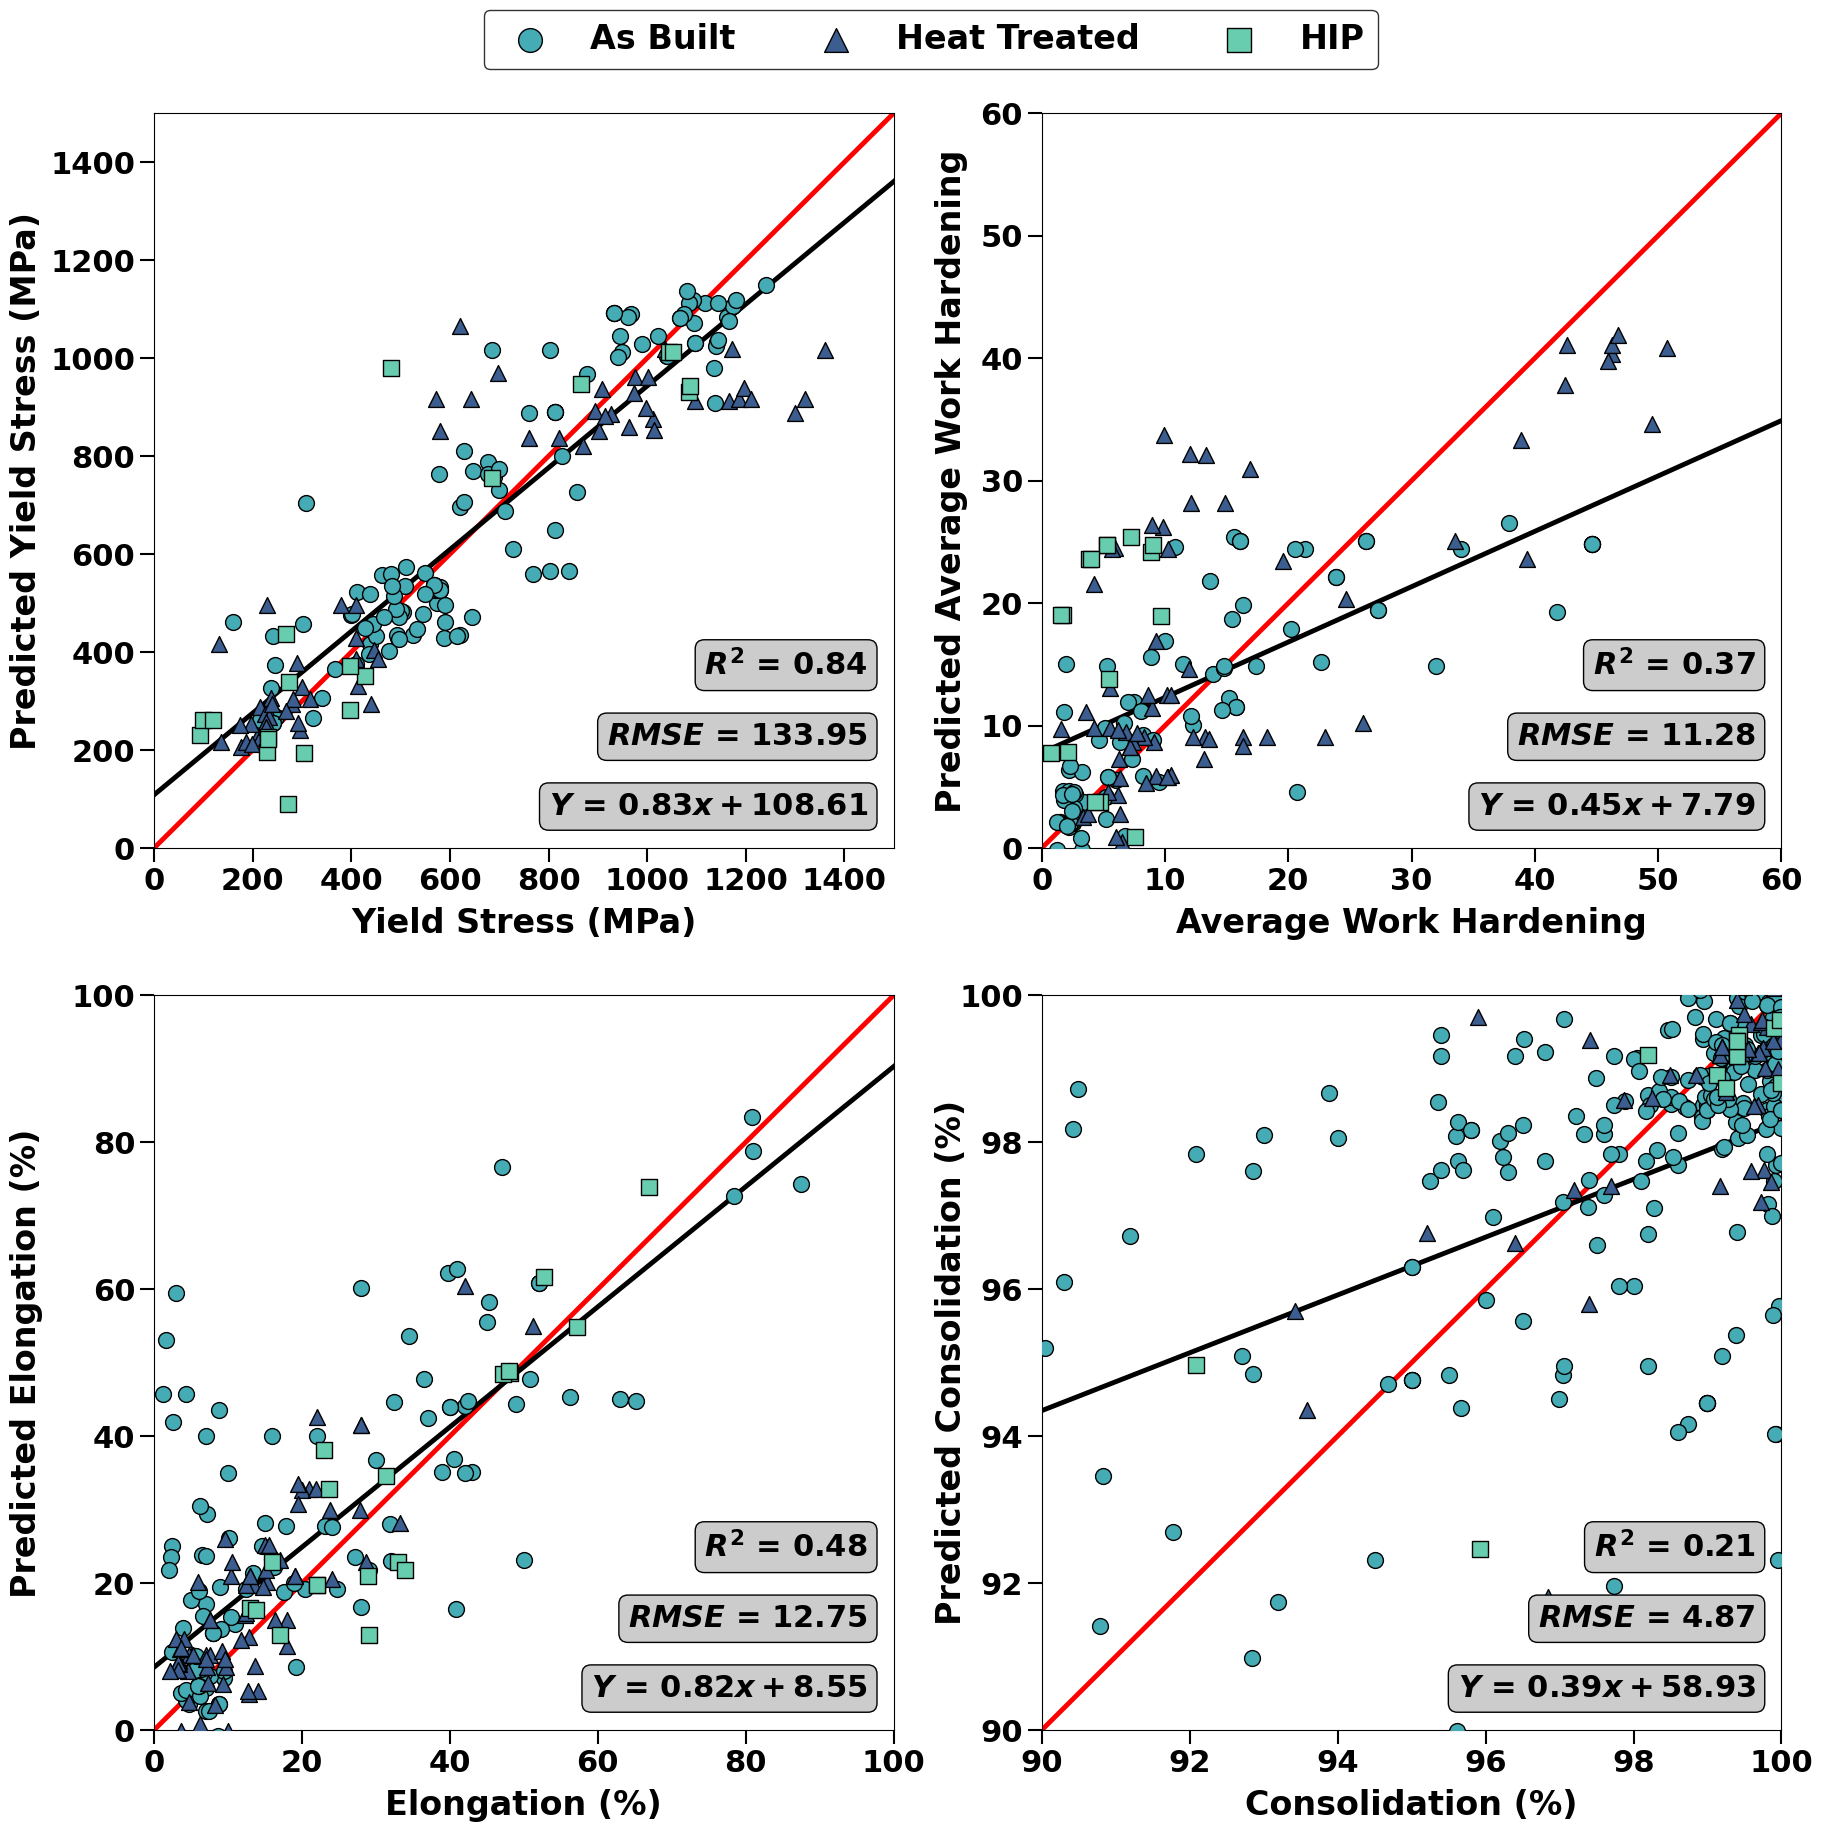

In [21]:
plot_perf()

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


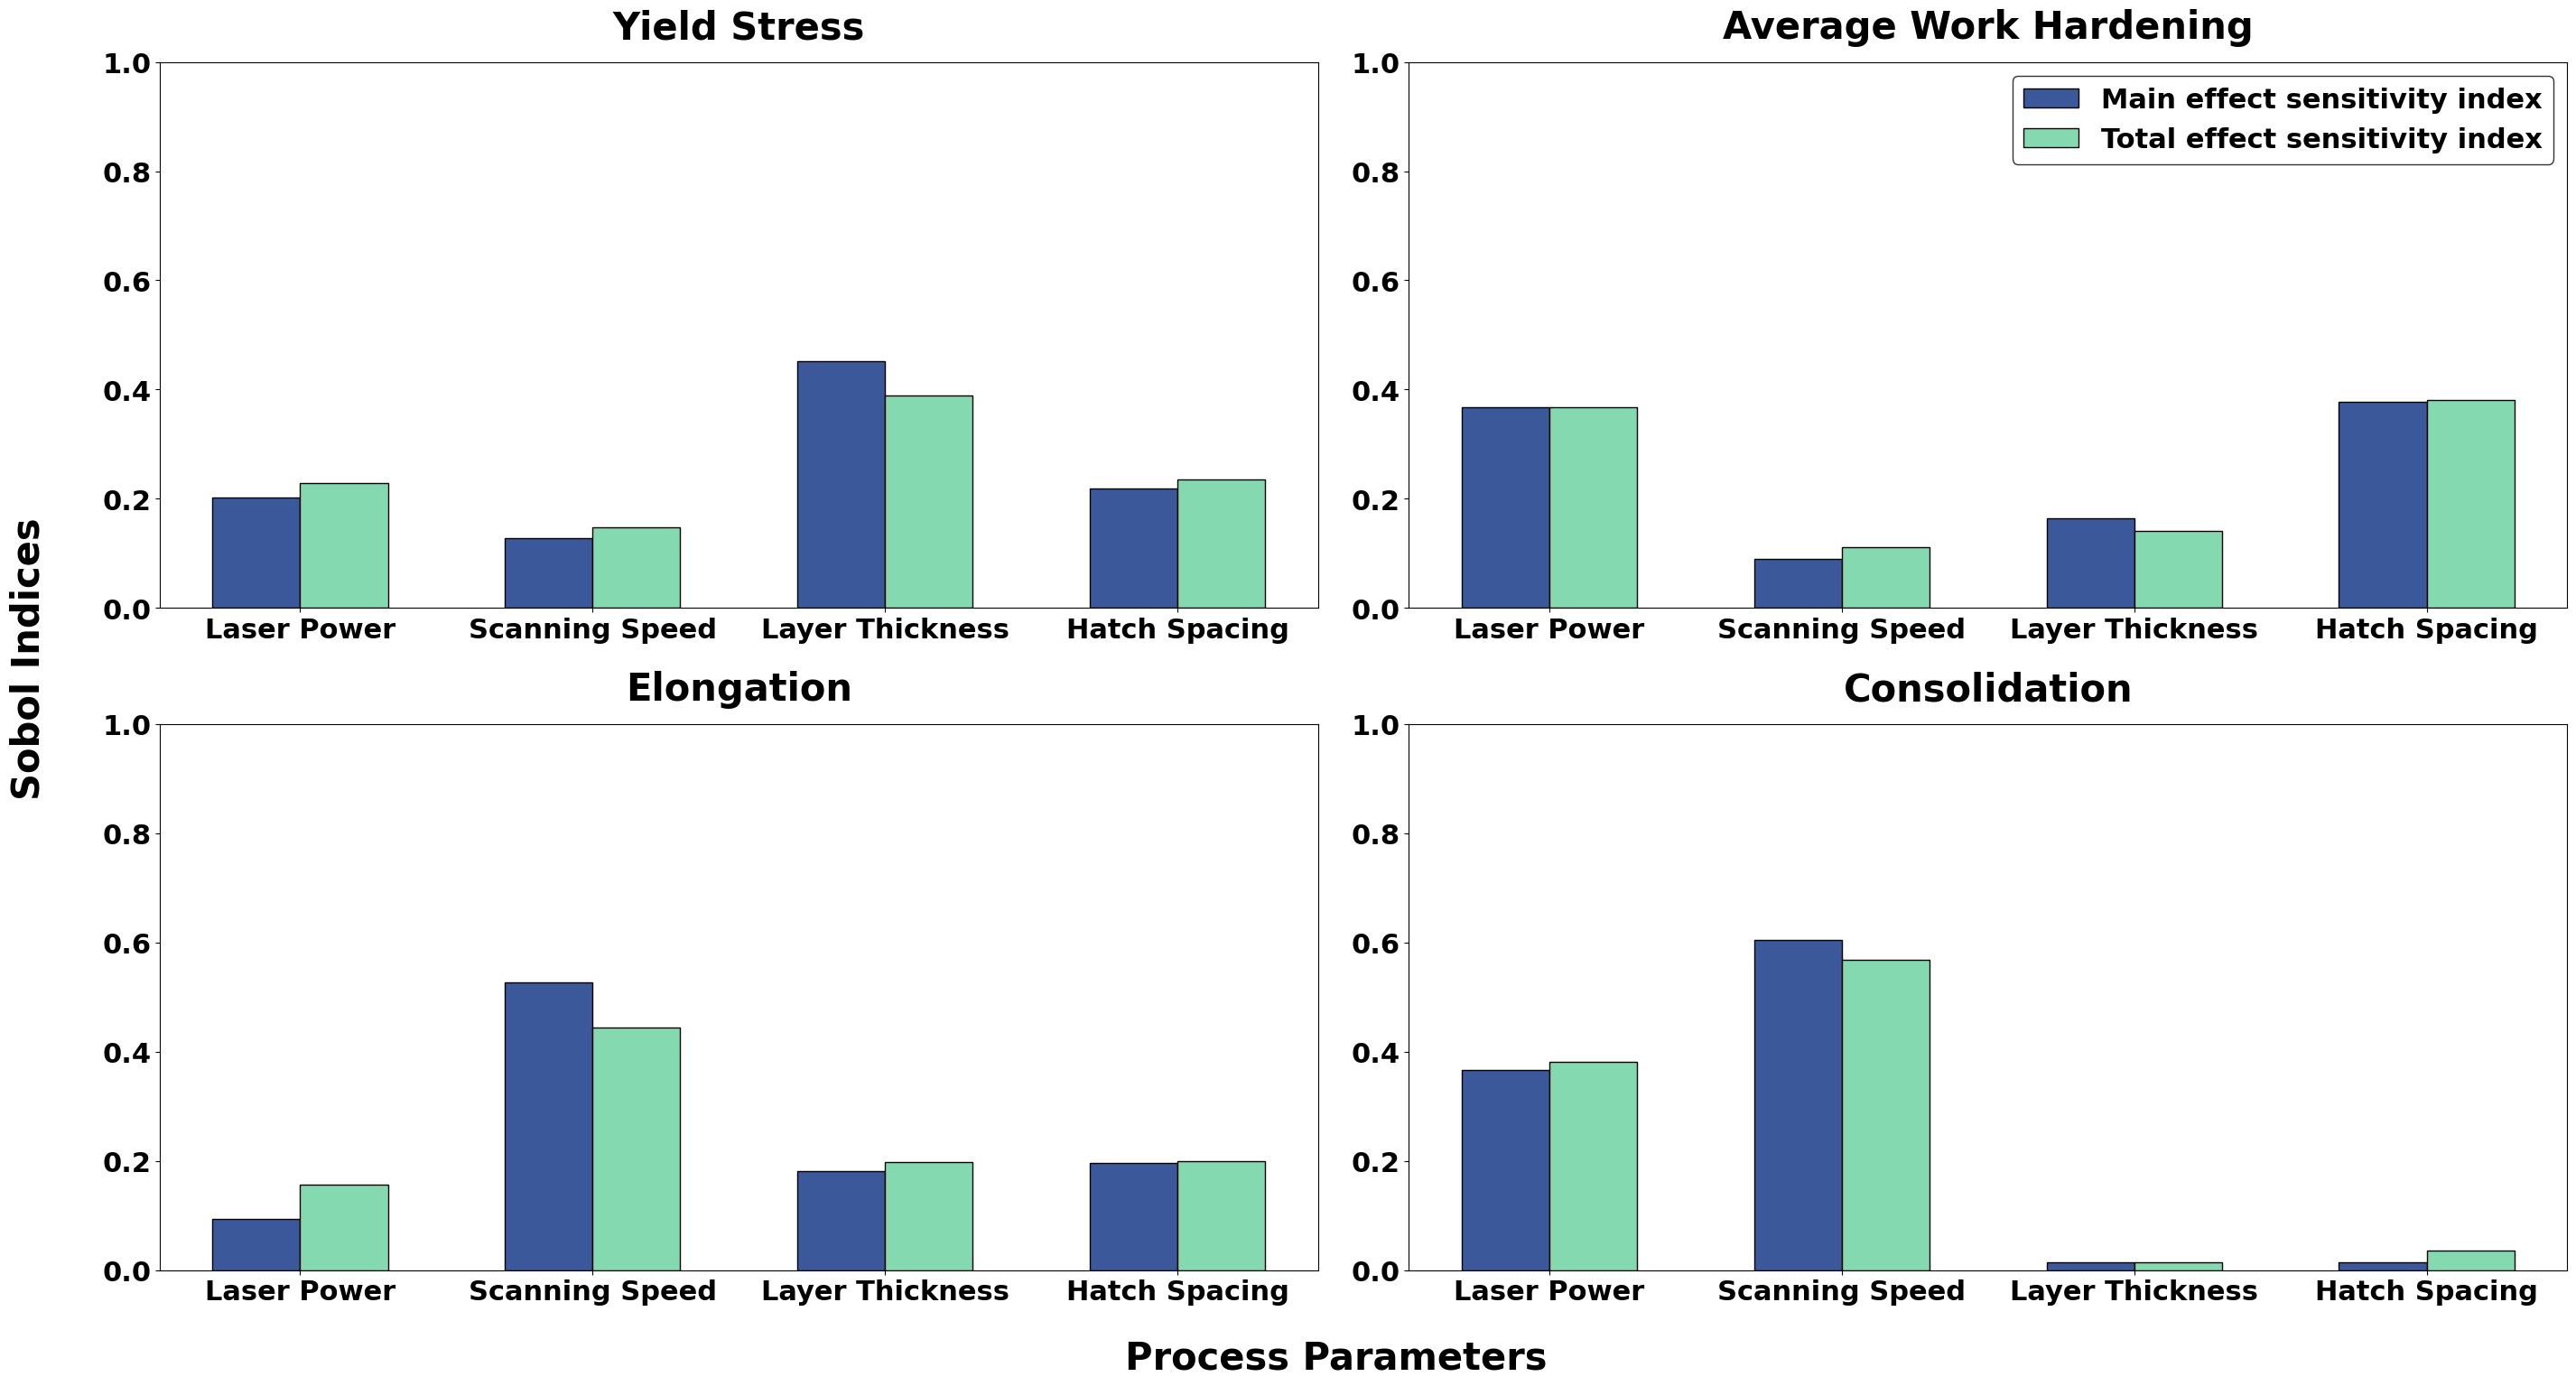

In [22]:
Plot_Sobol(leg_loc='upper right')

Consolidation (%)
Mean squared error, RMSE = 4.87
Coefficient of determination, r2 = 0.21


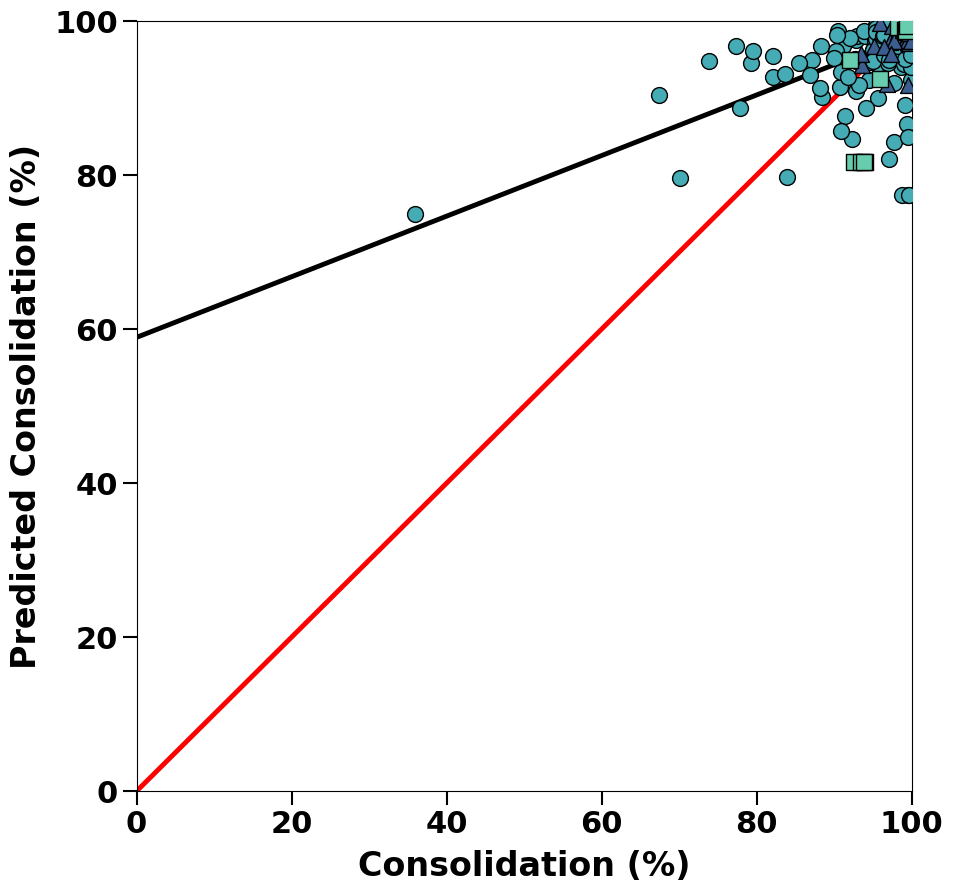

In [23]:
def RegLine(x):
  return slope * x + intercept

plt.rcParams.update({'font.size': 22})
pad_size = 8
txt_size = 24
m_size = 130

var = []
bbox = dict(boxstyle ="round", fc ="0.8")
gr_loc = 'best'
n=0
lim1=[0,1500]
lim2=[0,100]
lim3=[0,100]
lim4=[0,100]
lims = [lim1, lim2, lim3, lim4]

fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(111)

n = 3
x_index_nt = index_nt[n]
x_index_ht = index_ht[n]
x_index_hip = index_hip[n]
ax1.scatter(test_df[n][1][x_index_nt], predictions[n][x_index_nt], color='#45abb4', marker='o', s=m_size, edgecolors='k', label=(f'As Built'), zorder=5)
ax1.scatter(test_df[n][1][x_index_ht], predictions[n][x_index_ht], color='#3b5d8f', marker='^', s=m_size, edgecolors='k', label=(f'Heat Treated'), zorder=6)    
ax1.scatter(test_df[n][1][x_index_hip], predictions[n][x_index_hip], color='#68ccae', marker='s', s=m_size, edgecolors='k', label=(f'HIP'), zorder=7) 

ax1.set_xlabel(output_var[n], labelpad=pad_size, fontsize = txt_size, weight='bold')
ax1.set_ylabel((f'Predicted {output_var[n]}'), labelpad=pad_size, fontsize = txt_size, weight='bold')
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, linewidth=3.5, color='r')
ax1.set_xlim([lims[n][0], lims[n][1]])
ax1.set_ylim([lims[n][0], lims[n][1]])
ax1.tick_params(axis='both', which='major', width=1.5, length=10)

slope, intercept, r, p, std_err = stats.linregress(test_df[n][1].values.flatten(), predictions[n][:])

print(f'{output_var[n]}')
# The mean squared error
print("Mean squared error, RMSE = %.2f" % root_mean_squared_error(test_df[n][1].values.flatten(), predictions[n][:]))
# The coefficient of determination: 1 is perfect prediction
# Check for difference between r and r2 
# https://www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/#:~:text=Python%20%E2%80%93%20Coefficient%20of%20Determination-R2%20score.%20Coefficient%20of,is%20predictable%20from%20the%20input%20independent%20variable%20%28s%29.
print("Coefficient of determination, r2 = %.2f" % r2_score(test_df[n][1].values.flatten(), predictions[n][:]))

regline = list(map(RegLine, lims[n]))
ax1.plot(lims[n], regline, linewidth=3.5, color='k')

plt.show()

# LightGBM

In [24]:
def objective(trial, x, y, cv, scoring):

    epsilon = 1e-15
    param = {
                "objective": "regression",
                "metric": "rmse",
                "verbosity": -1,
                "boosting_type": "gbdt",
                "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
                "learning_rate": trial.suggest_categorical("learning_rate", [0.0125, 0.025, 0.05, 0.1]),
                "num_leaves": trial.suggest_int("num_leaves", 2, 2048),
                "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                "feature_fraction": min(trial.suggest_float("feature_fraction", 0.3, 1.0 + epsilon), 1.0),
                "bagging_fraction": min(trial.suggest_float("bagging_fraction", 0.3, 1.0 + epsilon), 1.0),
                "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
                "feature_pre_filter": False,
                "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
            }

    model = lgb.LGBMRegressor(**param, seed=seed)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [25]:
# Delete previous studies
optuna.delete_study(study_name="LightGBM_yield", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="LightGBM_hardening", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="LightGBM_elongation", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="LightGBM_consolidation", storage="sqlite:///db.sqlite3")

In [26]:
%%capture capt
study_yield = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="LightGBM_yield")
study_hardening = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="LightGBM_hardening")
study_elongation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="LightGBM_elongation")
study_consolidation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="LightGBM_consolidation")
studies = [study_yield, study_hardening, study_elongation, study_consolidation]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, y, cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=50)

[I 2024-04-19 11:56:41,757] A new study created in RDB with name: LightGBM_yield
[I 2024-04-19 11:56:41,787] A new study created in RDB with name: LightGBM_hardening
[I 2024-04-19 11:56:41,829] A new study created in RDB with name: LightGBM_elongation
[I 2024-04-19 11:56:41,864] A new study created in RDB with name: LightGBM_consolidation
[I 2024-04-19 11:56:42,381] Trial 0 finished with value: 117.46370357047954 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'num_leaves': 1483, 'lambda_l1': 4.9851848587980965e-06, 'lambda_l2': 0.48710715675828575, 'feature_fraction': 0.43798903555640994, 'bagging_fraction': 0.6527557242148363, 'bagging_freq': 4, 'min_data_in_leaf': 17, 'extra_trees': False}. Best is trial 0 with value: 117.46370357047954.
[I 2024-04-19 11:56:42,544] Trial 1 finished with value: 242.23679942336307 and parameters: {'n_estimators': 50, 'learning_rate': 0.025, 'num_leaves': 1240, 'lambda_l1': 0.011647095315482834, 'lambda_l2': 0.004433808647781986, 'feature_

In [20]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3b

^C


In [27]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/LightGBM/LightGBM_{i:02d}.xlsx")

    with open(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/LightGBM/LGBM_best_params_{i:02d}.json", 'w+') as f:
        json.dump(study.best_params, f)
    with open(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/LightGBM/LGBM_best_value_{i:02d}.json", 'w+') as f:
        json.dump(study.best_value, f)

In [107]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/LightGBM/LGBM_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [108]:
# Compute predictions and save models
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = lgb.LGBMRegressor(**hyp_params[i])
    model.fit(x, y)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

# Convert consolidation predictions back to original scale
predictions[3] = np.power(10, predictions[3])

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l2 is set=7.573891586691068e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.573891586691068e-05
[LightGBM] [Warning] bagging_fraction is set=0.8551820807502757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8551820807502757
[LightGBM] [Warning] lambda_l1 is set=1.2071251567534524e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2071251567534524e-07
[LightGBM] [Warning] feature_fraction is set=0.6966293258007392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6966293258007392
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[L

Yield Stress (MPa)
Mean squared error, RMSE = 130.13
Coefficient of determination, r2 = 0.84
Average Work Hardening
Mean squared error, RMSE = 11.40
Coefficient of determination, r2 = 0.36
Elongation (%)
Mean squared error, RMSE = 10.76
Coefficient of determination, r2 = 0.63
Consolidation (%)
Mean squared error, RMSE = 4.41
Coefficient of determination, r2 = 0.35


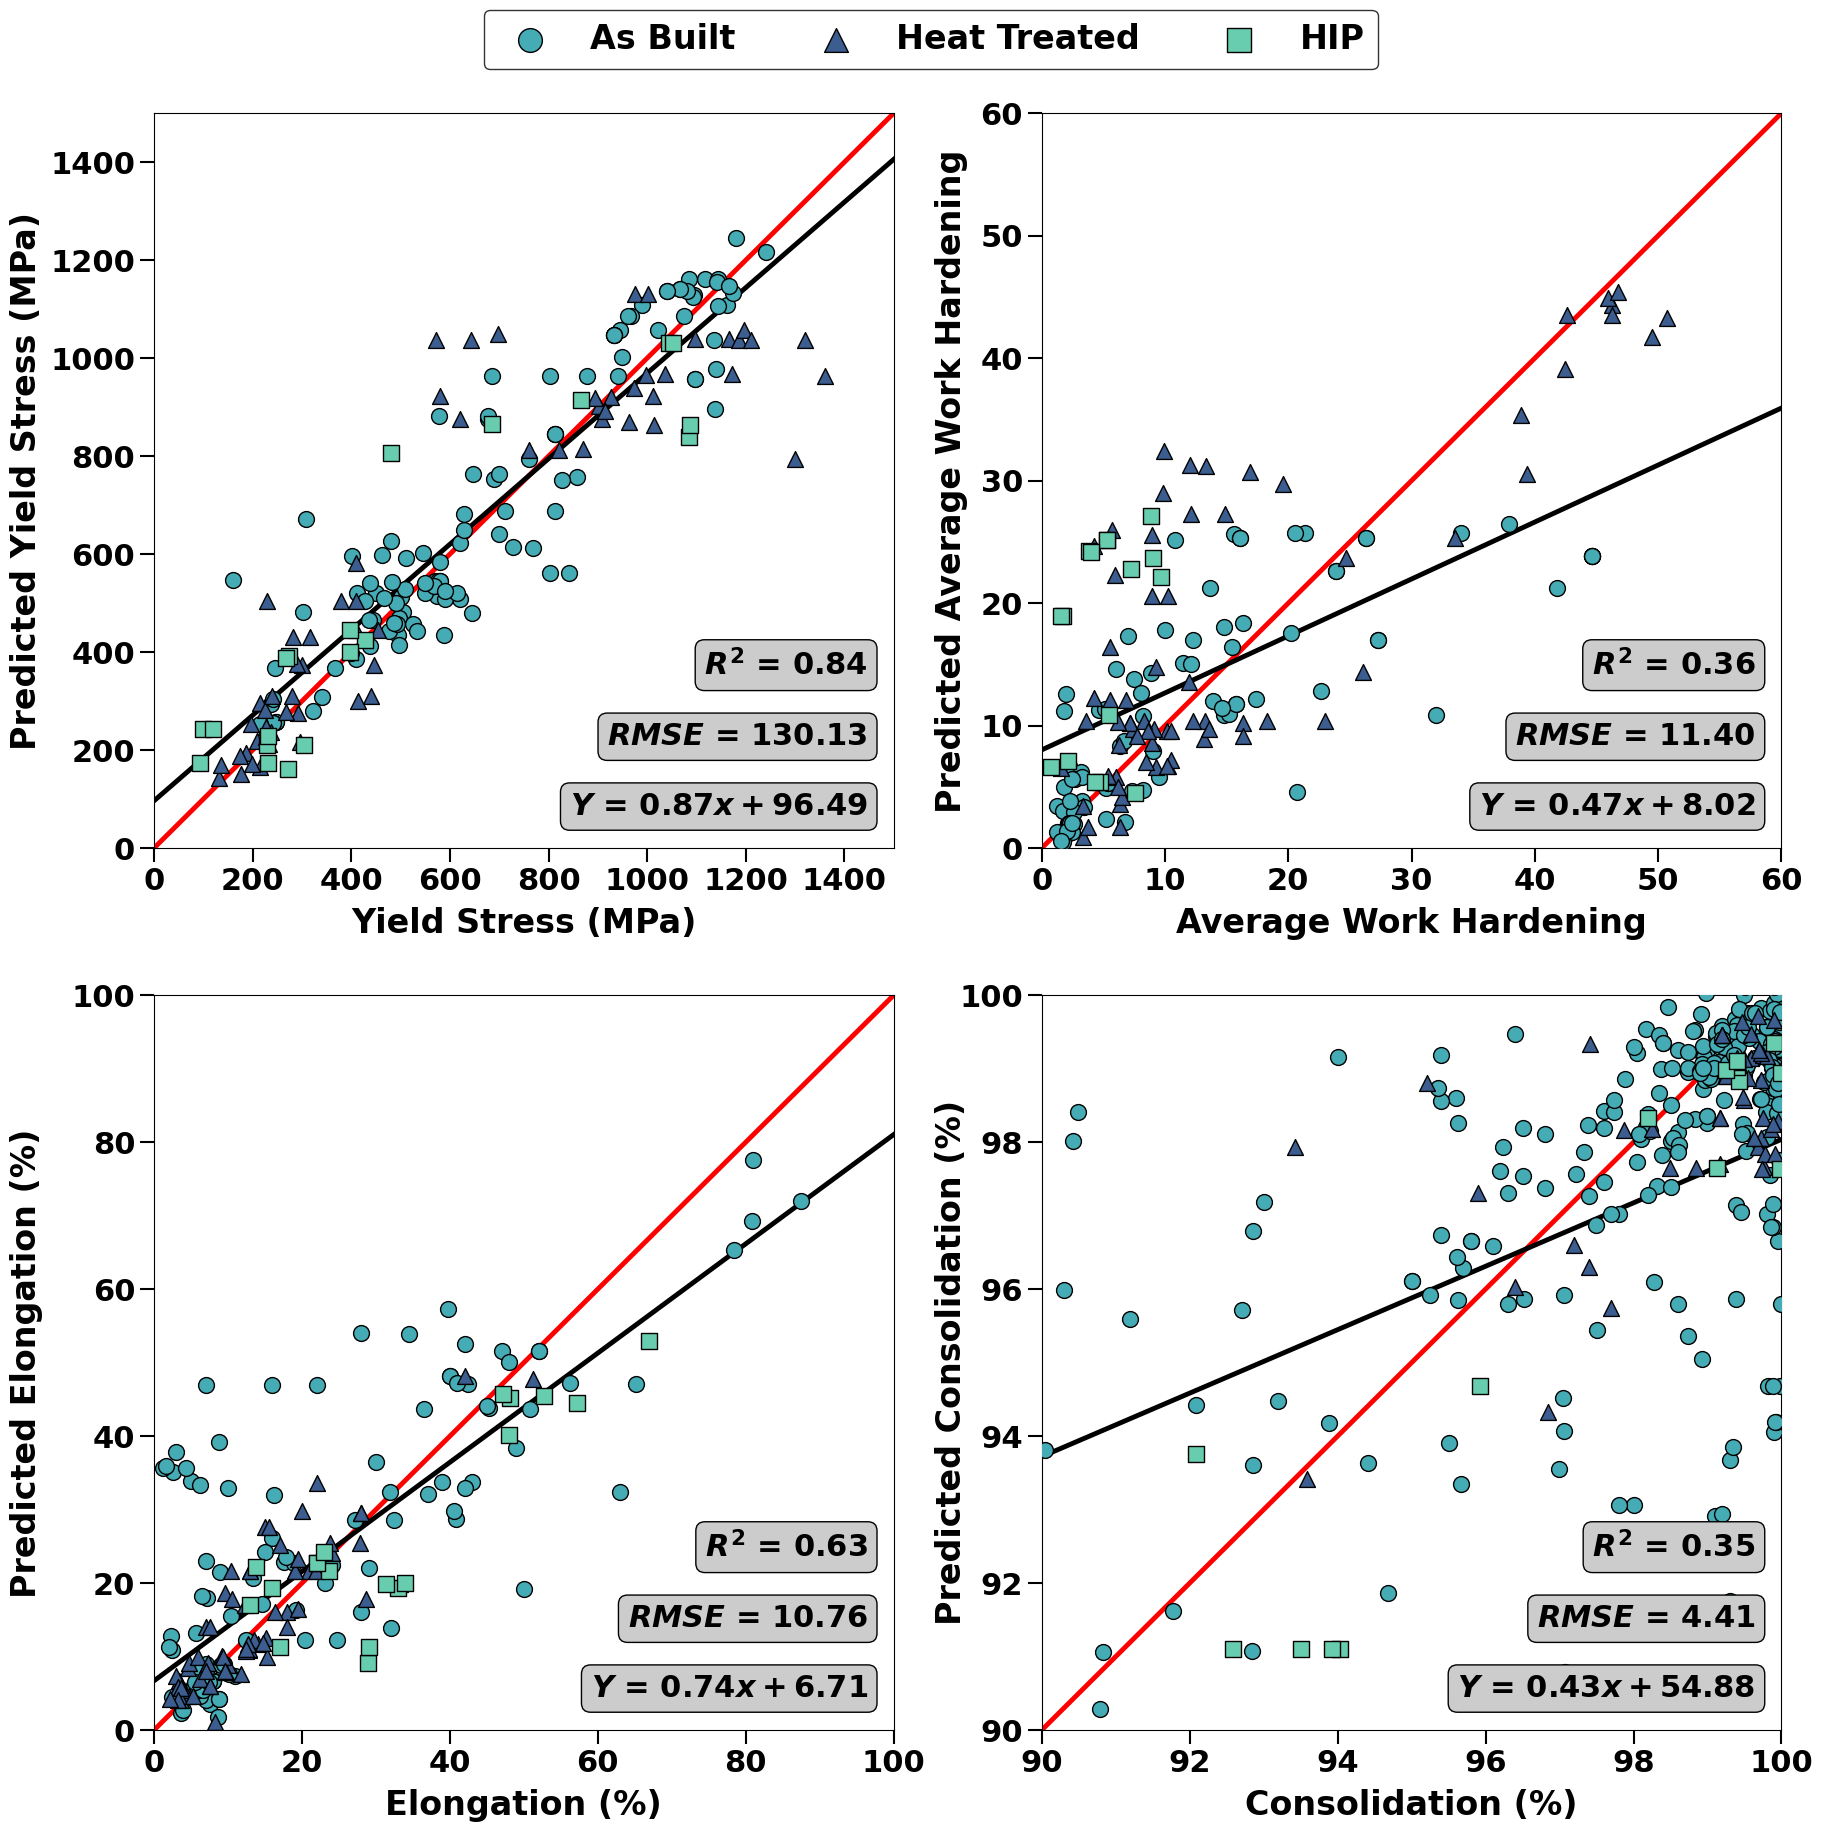

In [109]:
plot_perf()

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


[LightGBM] [Warning] lambda_l1 is set=1.2071251567534524e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2071251567534524e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6966293258007392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6966293258007392
[LightGBM] [Warning] bagging_fraction is set=0.8551820807502757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8551820807502757
[LightGBM] [Warning] lambda_l2 is set=7.573891586691068e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.573891586691068e-05
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


[LightGBM] [Warning] lambda_l1 is set=0.11512466899155652, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11512466899155652
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8487595390105688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8487595390105688
[LightGBM] [Warning] bagging_fraction is set=0.7694519343389765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7694519343389765
[LightGBM] [Warning] lambda_l2 is set=0.0018882870275242843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018882870275242843
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


[LightGBM] [Warning] lambda_l1 is set=3.094355002799769e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.094355002799769e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.8729639957694624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8729639957694624
[LightGBM] [Warning] bagging_fraction is set=0.5547816868948183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5547816868948183
[LightGBM] [Warning] lambda_l2 is set=1.2667439800598582e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2667439800598582e-07
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


[LightGBM] [Warning] lambda_l1 is set=3.495963606430973e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.495963606430973e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9683341428431286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9683341428431286
[LightGBM] [Warning] bagging_fraction is set=0.3223360712996417, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3223360712996417
[LightGBM] [Warning] lambda_l2 is set=8.082733752032071, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.082733752032071
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


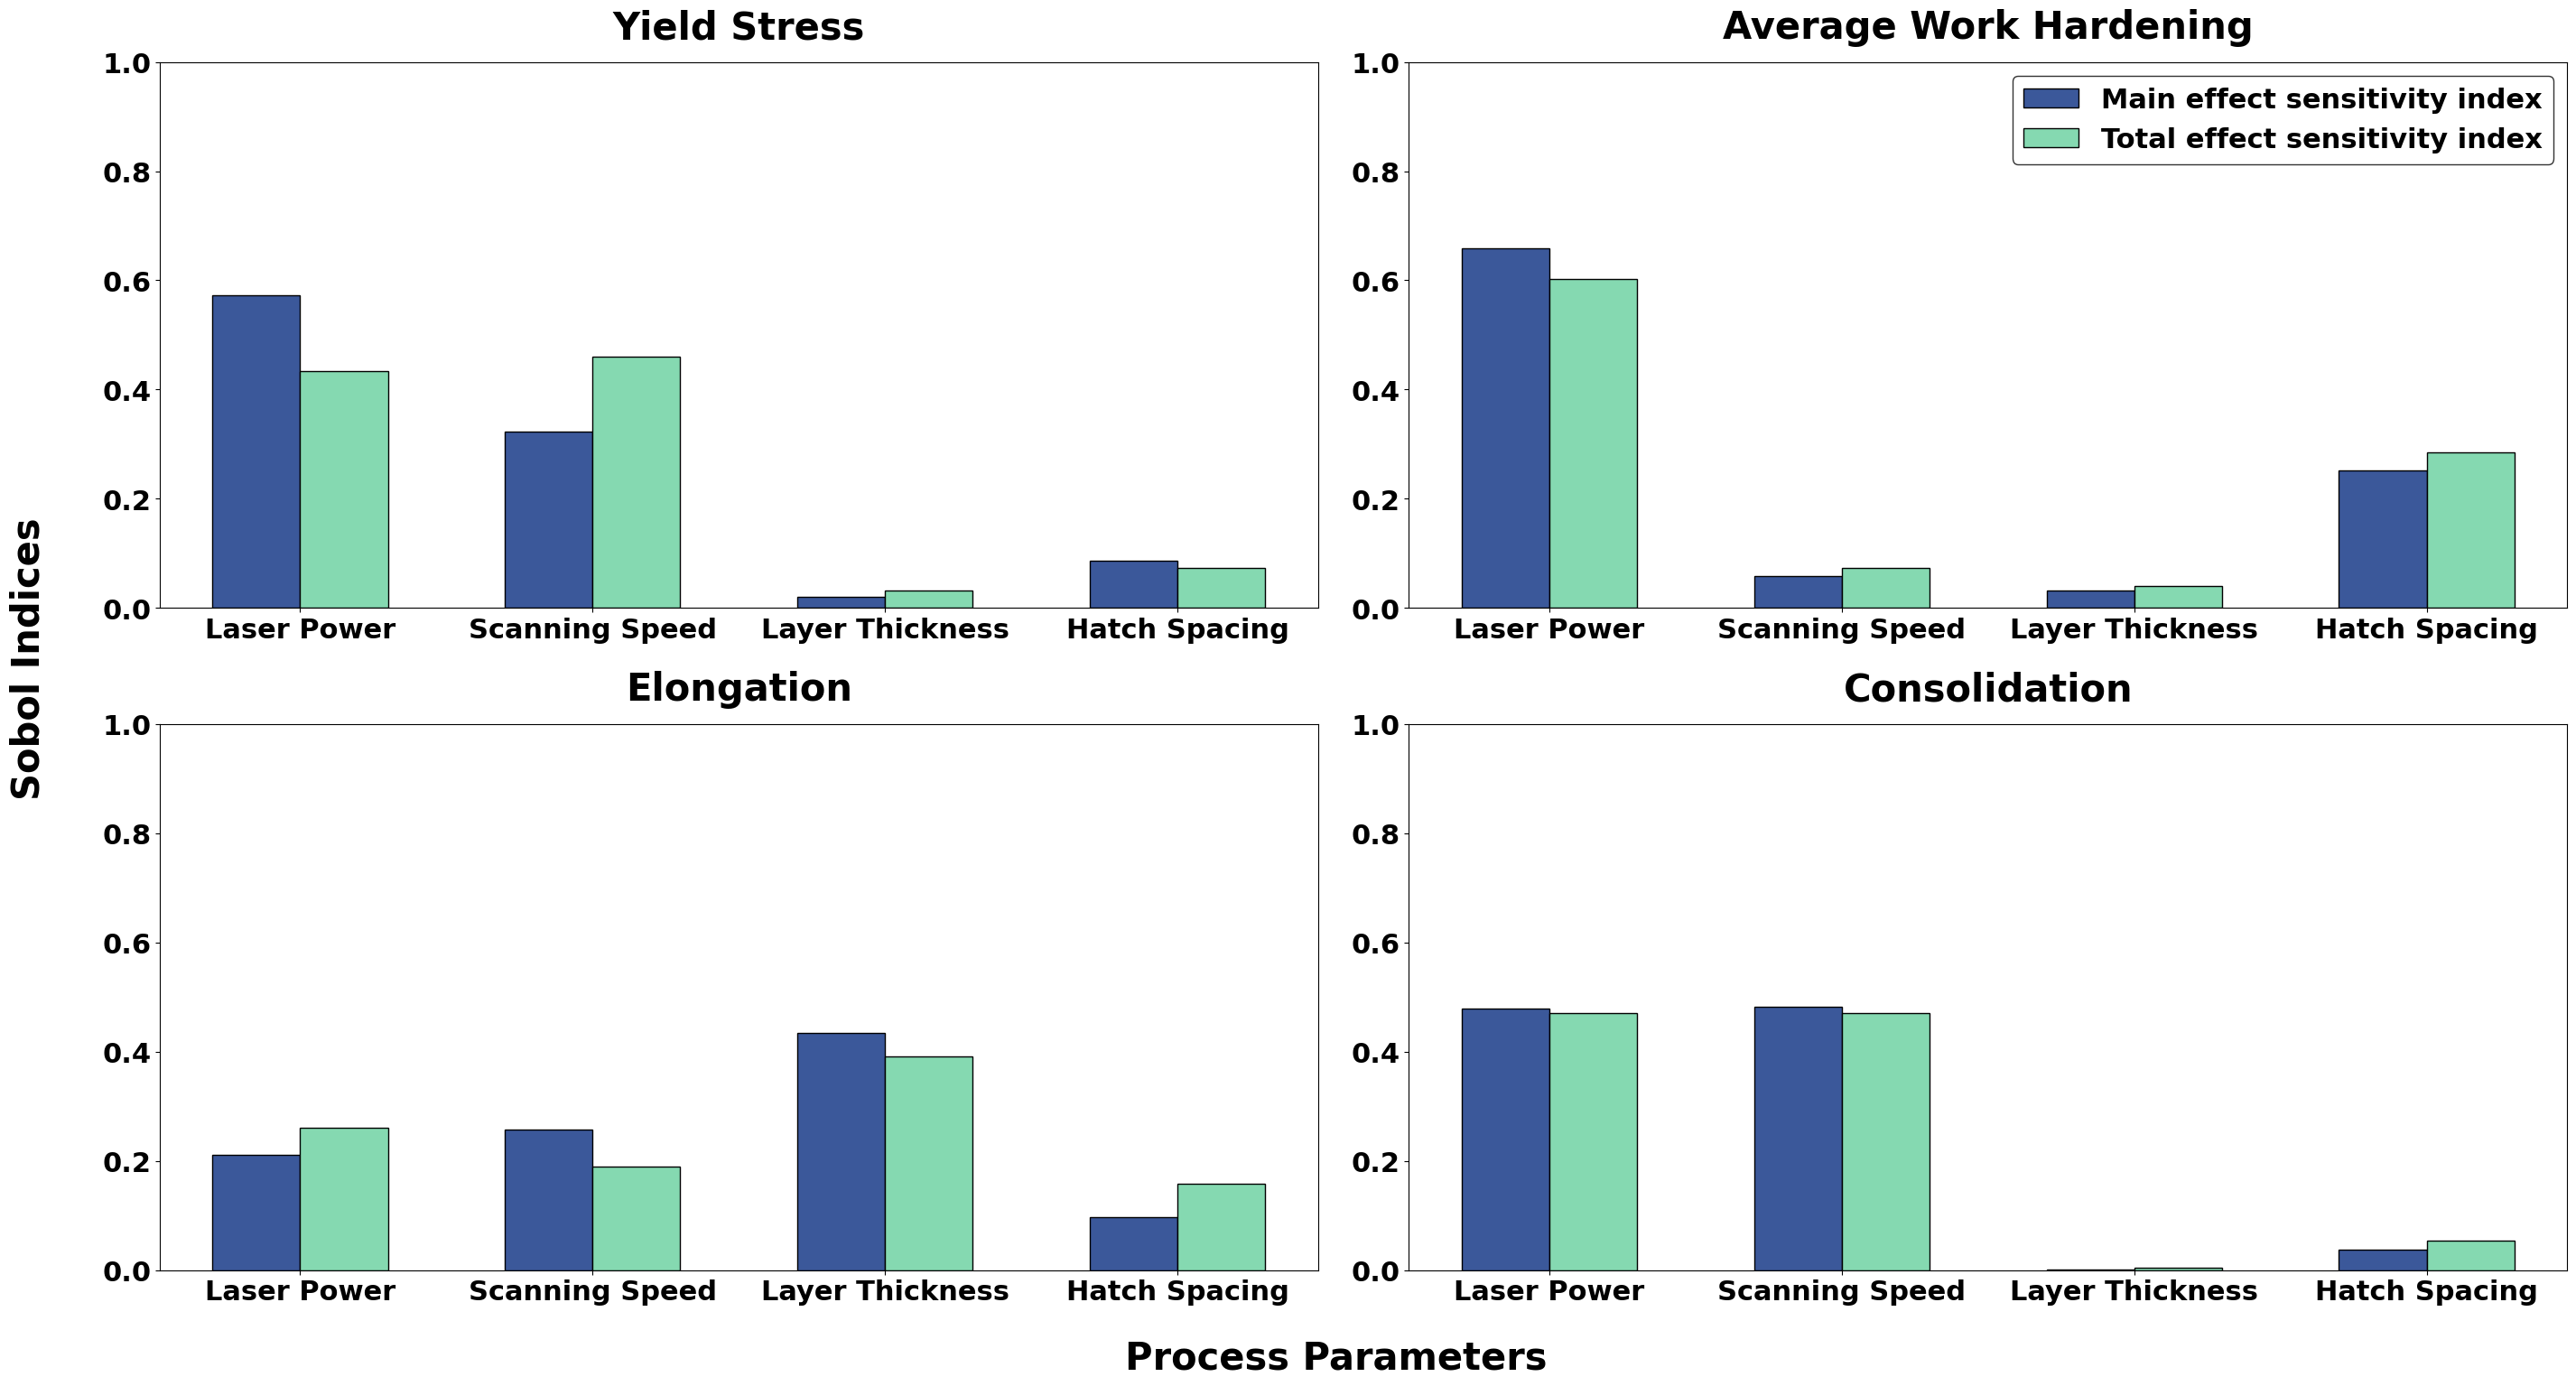

In [110]:
Plot_Sobol(leg_loc='upper right')

# CatBoost

In [32]:
def objective(trial, x, y, cv, scoring):

    EPS = 1e-15
    param = {
                "loss_function": "MultiRMSE",
                "eval_metric": "MultiRMSE",
                "iterations": trial.suggest_int("iterations", 500, 2500, step=500),
                "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, step=0.05),
                "depth": trial.suggest_int("depth", 2, 9),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.0001, 10.0, log=False),
                "random_strength": trial.suggest_float("random_strength", EPS, 10.0, log=False),
                "rsm": trial.suggest_float("rsm", 0.1, 1),
                "verbose": False,
                "allow_writing_files": False,
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
            }

    model = cb.CatBoostRegressor(**param)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [15]:
def objective(trial, x, y, cv, scoring):

    EPS = 1e-15
    param = {
                "loss_function": "MultiRMSE",
                "eval_metric": "MultiRMSE",
                "iterations": trial.suggest_int("iterations", 500, 1500, step=500),
                "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, step=0.05),
                "depth": trial.suggest_int("depth", 2, 9),
                "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.0001, 5.0, log=False),
                "random_strength": trial.suggest_float("random_strength", EPS, 10.0, log=False),
                "rsm": trial.suggest_float("rsm", 0.1, 1),
                "verbose": False,
                "allow_writing_files": False,
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
            }

    model = cb.CatBoostRegressor(**param)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [16]:
# Delete previous studies
optuna.delete_study(study_name="CatBoost_yield", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="CatBoost_hardening", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="CatBoost_elongation", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="CatBoost_consolidation", storage="sqlite:///db.sqlite3")

In [17]:
%%capture capt
study_yield = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="CatBoost_yield")
study_hardening = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="CatBoost_hardening")
study_elongation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="CatBoost_elongation")
study_consolidation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="CatBoost_consolidation")
studies = [study_yield, study_hardening, study_elongation, study_consolidation]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, y, cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=50)

[I 2024-04-26 10:37:10,463] A new study created in RDB with name: CatBoost_yield
[I 2024-04-26 10:37:10,482] A new study created in RDB with name: CatBoost_hardening
[I 2024-04-26 10:37:10,502] A new study created in RDB with name: CatBoost_elongation
[I 2024-04-26 10:37:10,525] A new study created in RDB with name: CatBoost_consolidation
[I 2024-04-26 10:37:12,863] Trial 0 finished with value: 114.01201224454094 and parameters: {'iterations': 500, 'learning_rate': 0.05, 'depth': 6, 'l2_leaf_reg': 0.06652521979638641, 'random_strength': 4.618537550781361, 'rsm': 0.7408770729058693, 'min_data_in_leaf': 66}. Best is trial 0 with value: 114.01201224454094.
[I 2024-04-26 10:37:14,233] Trial 1 finished with value: 112.33247329626144 and parameters: {'iterations': 1000, 'learning_rate': 0.05, 'depth': 7, 'l2_leaf_reg': 4.2897792868748565, 'random_strength': 3.386414949291699, 'rsm': 0.4201514900439839, 'min_data_in_leaf': 79}. Best is trial 1 with value: 112.33247329626144.
[I 2024-04-26 10:

In [97]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3

^C


In [18]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/CatBoost/CatBoost_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/CatBoost/CatBoost_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/CatBoost/CatBoost_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [23]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/CatBoost/CatBoost_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [24]:
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = cb.CatBoostRegressor(**hyp_params[i])
    model.fit(x, y, verbose=False)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

# Convert consolidation predictions back to original scale
predictions[3] = np.power(10, predictions[3])

Yield Stress (MPa)
Mean squared error, RMSE = 127.73
Coefficient of determination, r2 = 0.85
Average Work Hardening
Mean squared error, RMSE = 10.13
Coefficient of determination, r2 = 0.49
Elongation (%)
Mean squared error, RMSE = 10.58
Coefficient of determination, r2 = 0.64
Consolidation (%)
Mean squared error, RMSE = 4.26
Coefficient of determination, r2 = 0.39


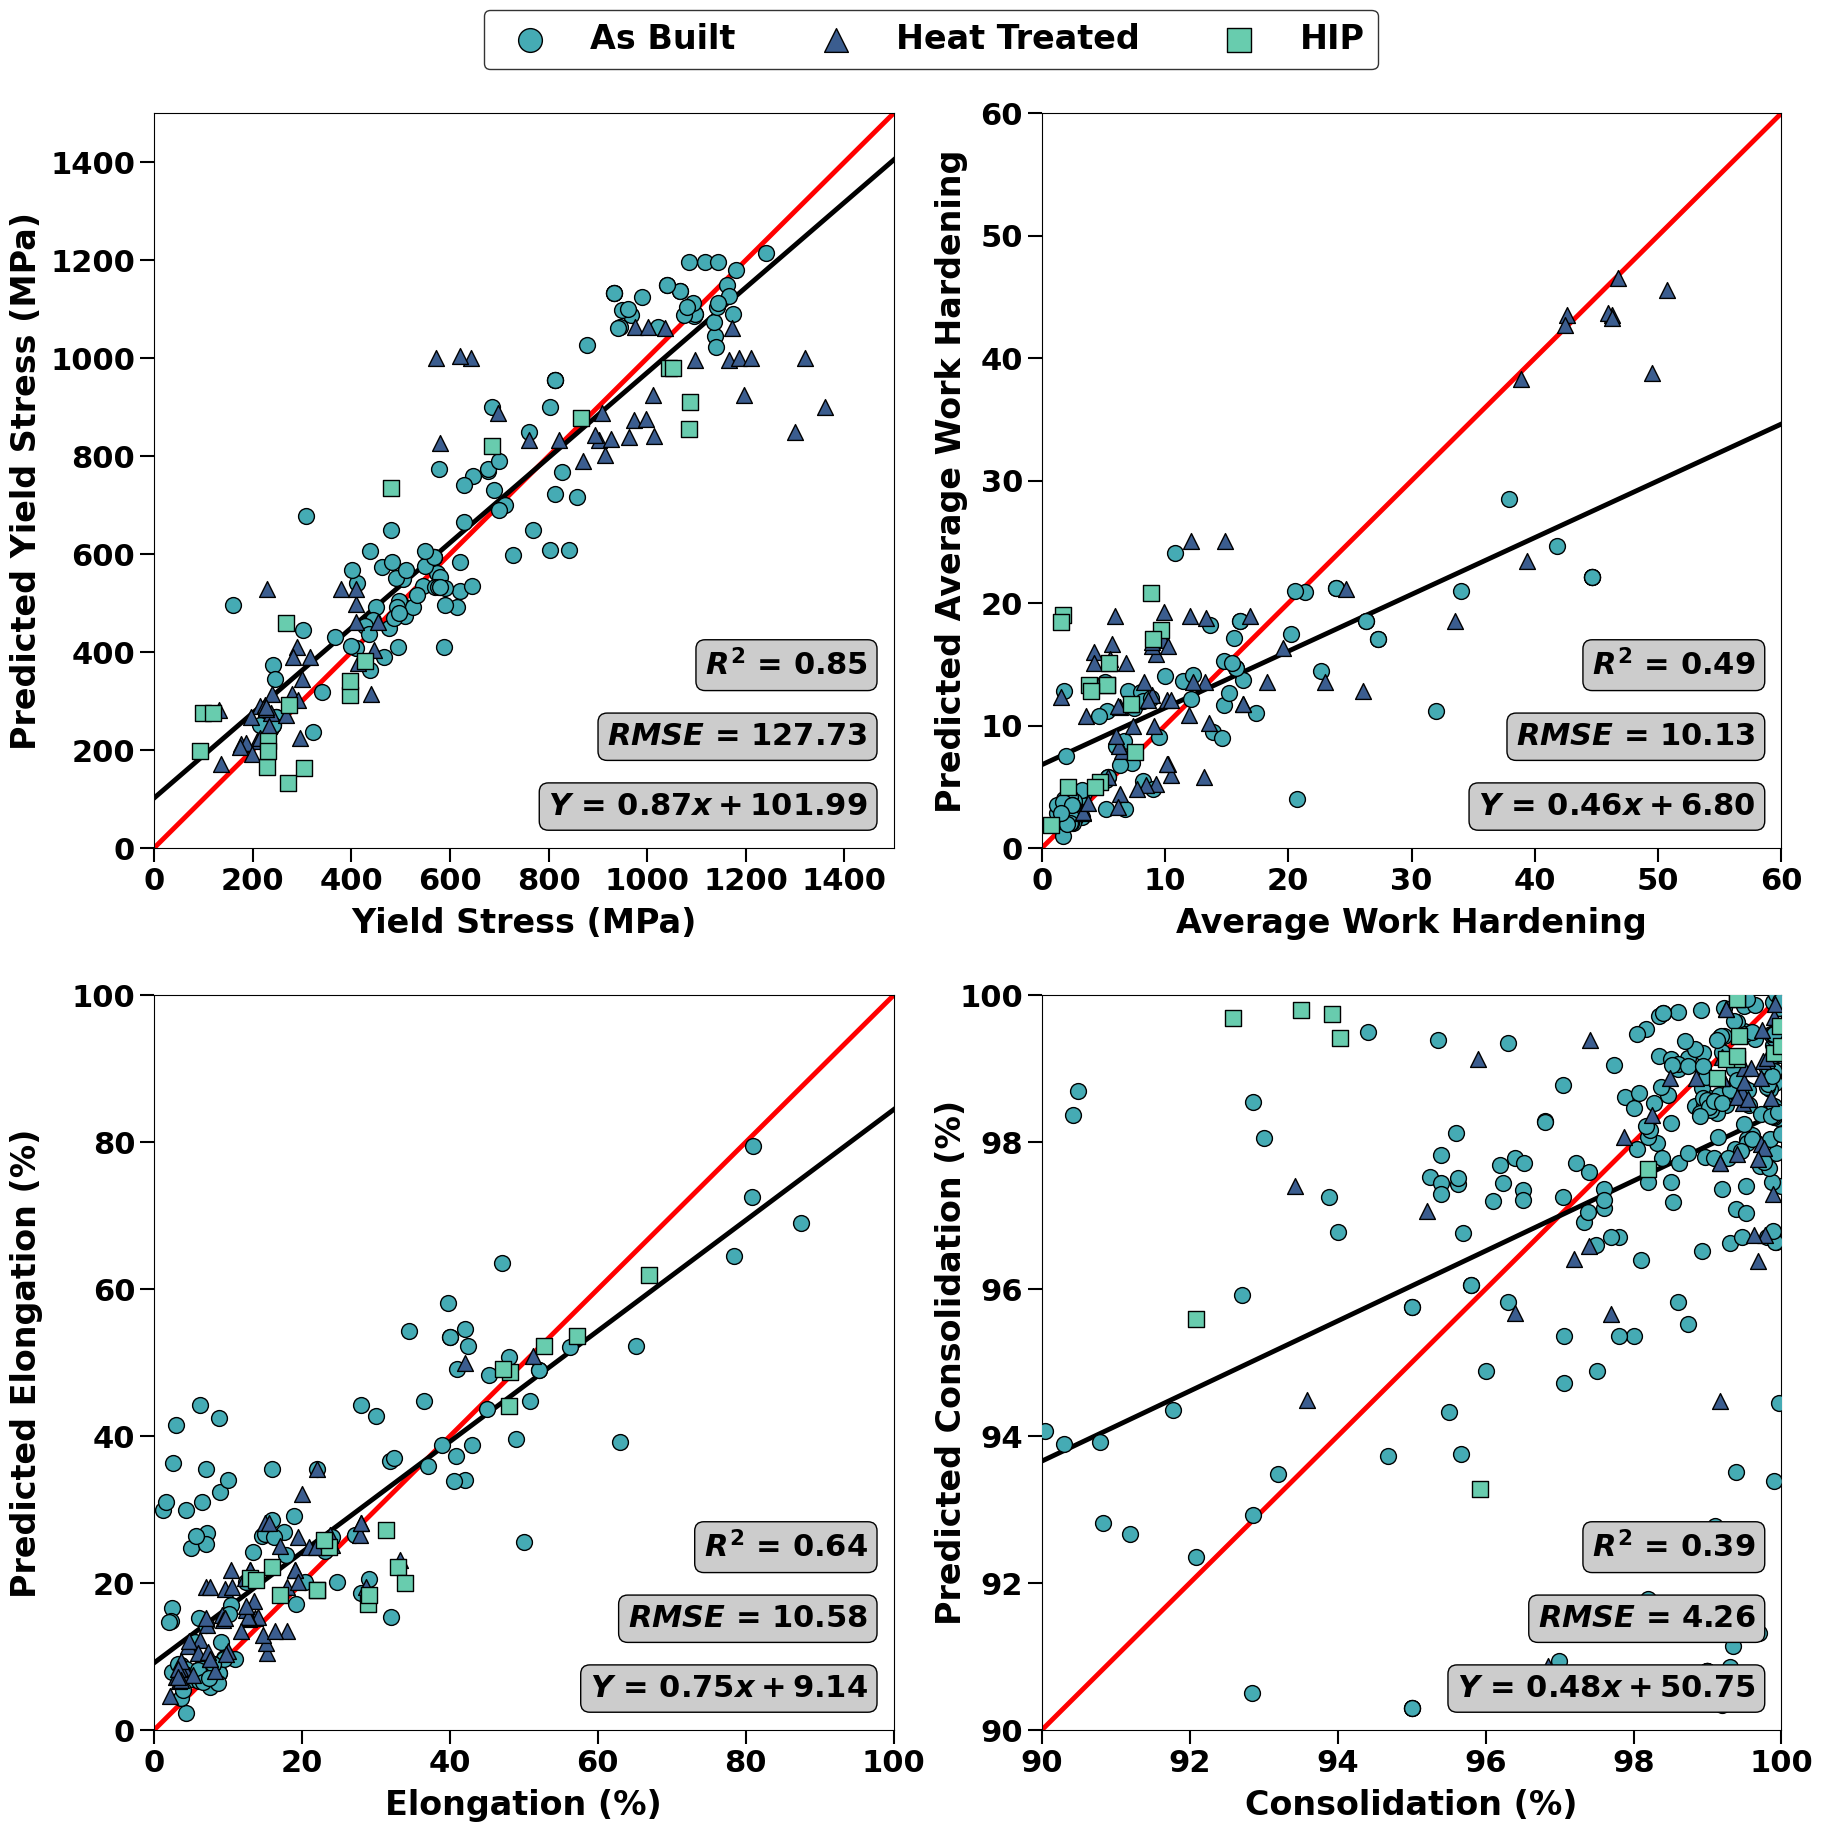

In [25]:
plot_perf()

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


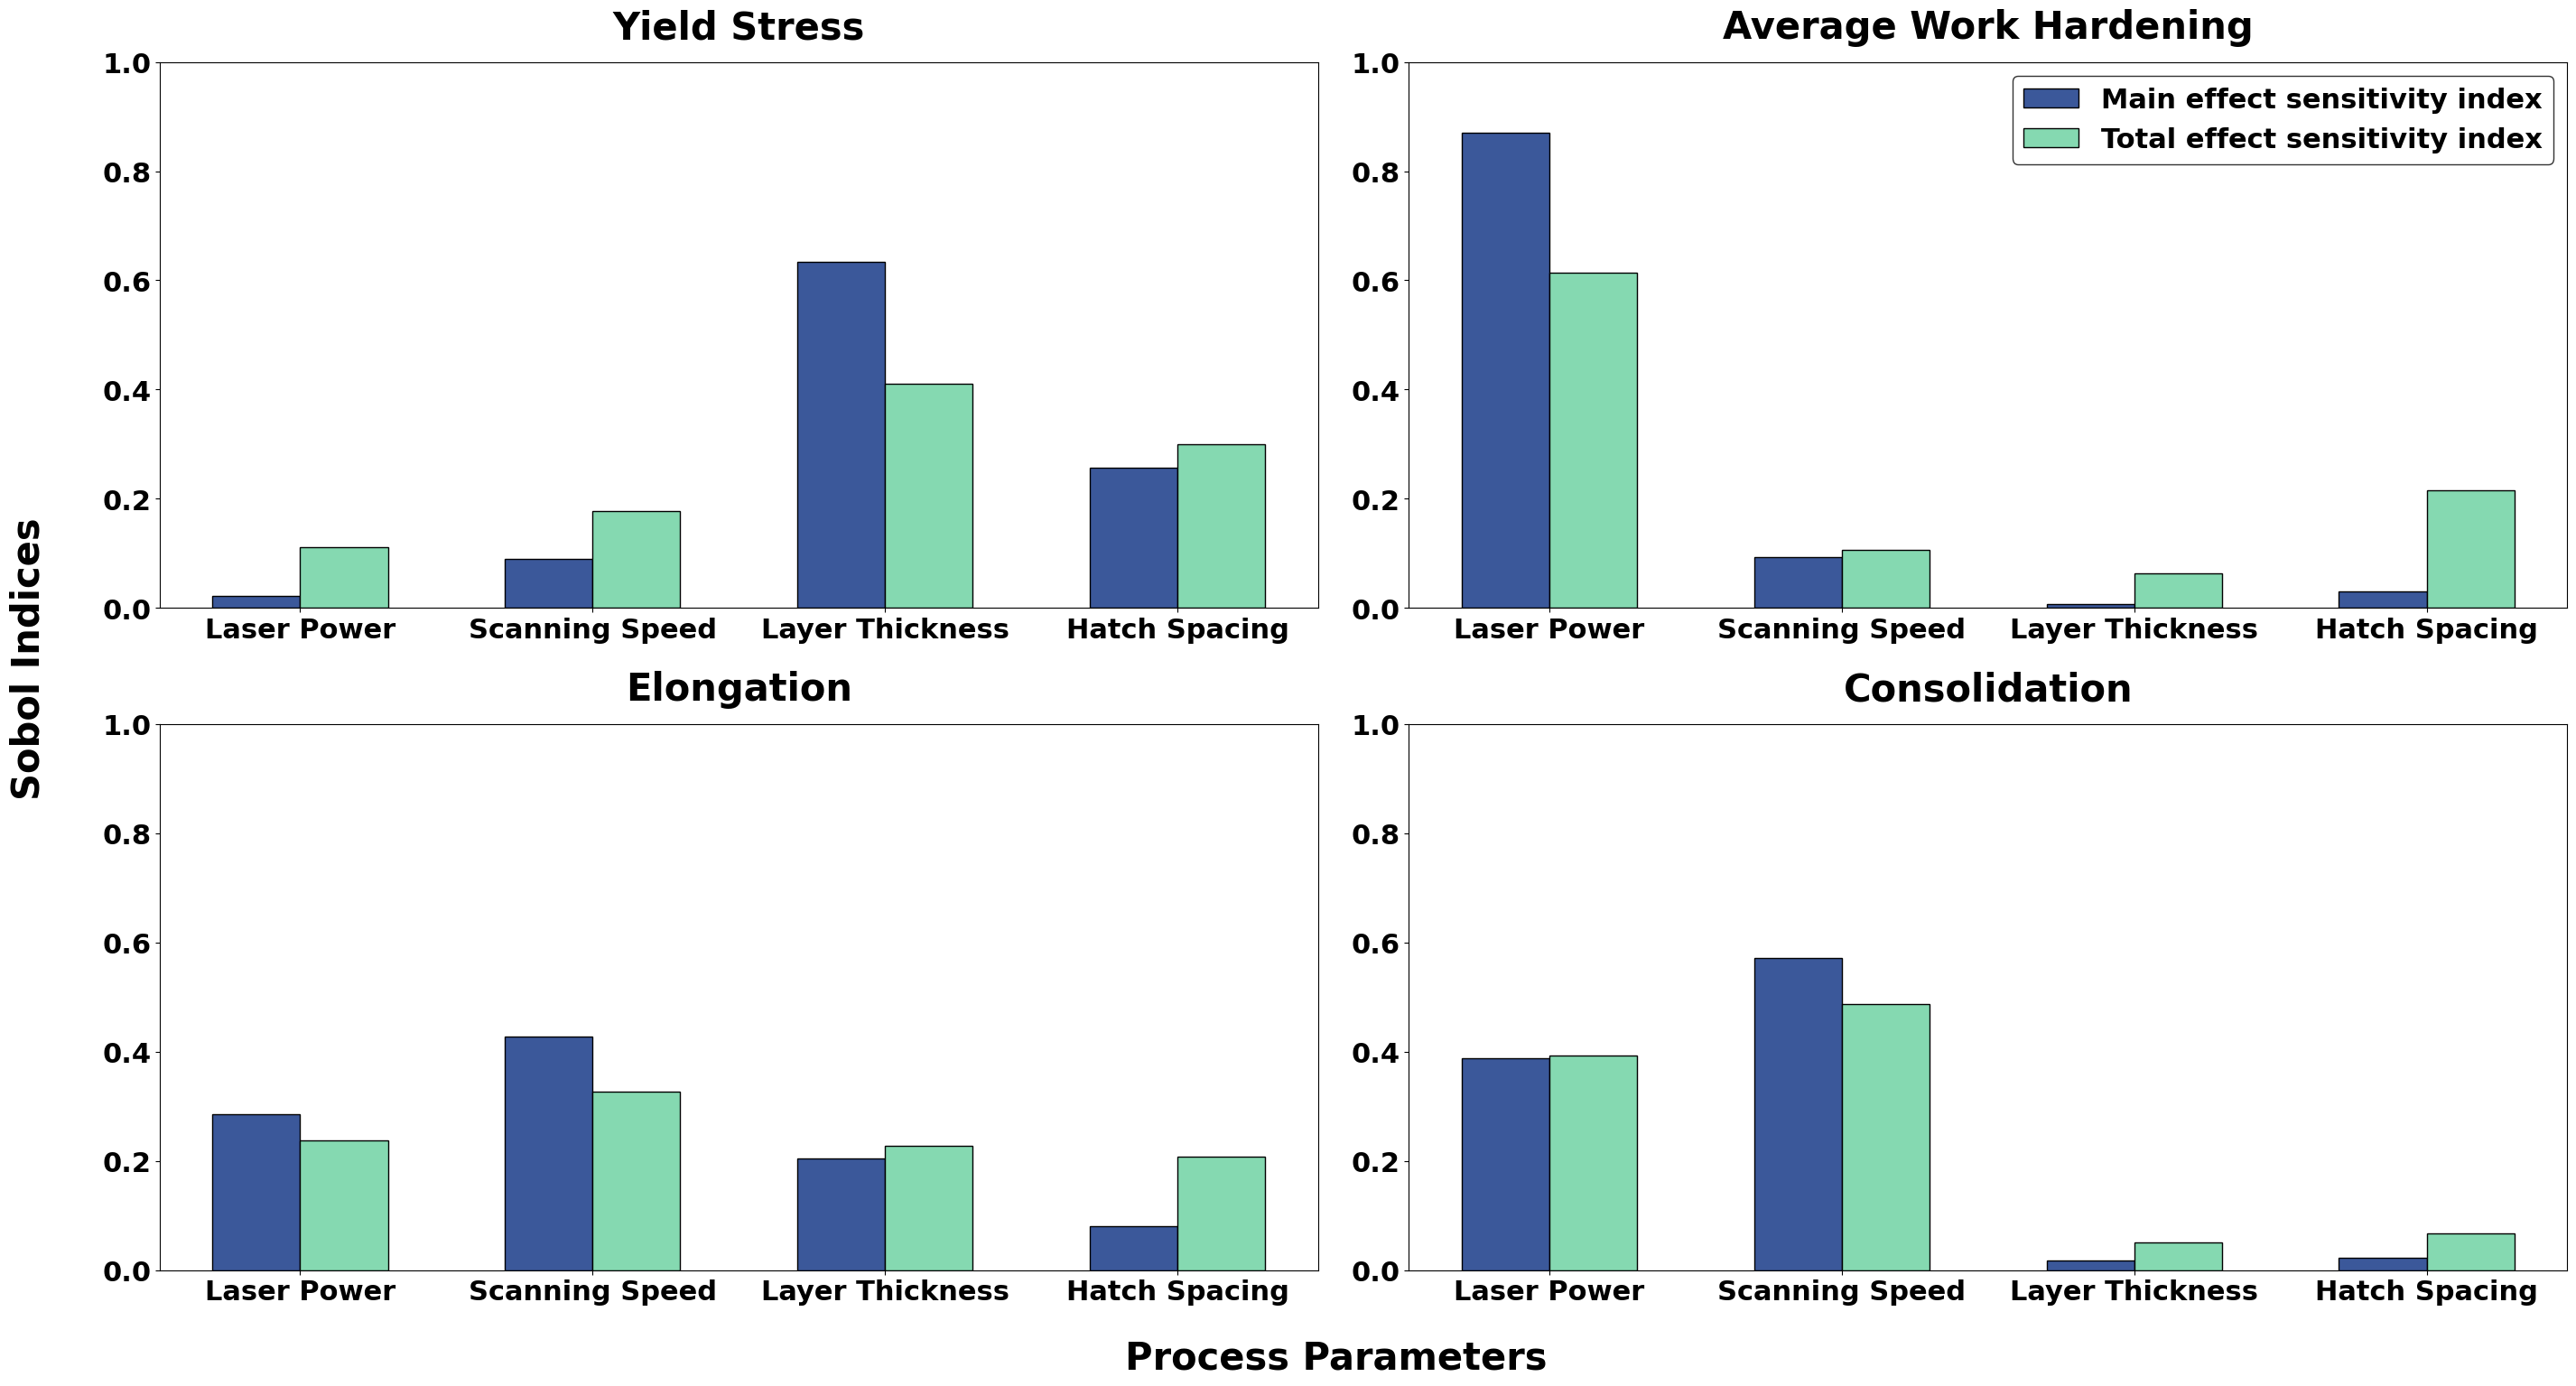

In [26]:
Plot_Sobol(leg_loc='upper right')

Consolidation (%)
Mean squared error, RMSE = 4.26
Coefficient of determination, r2 = 0.39


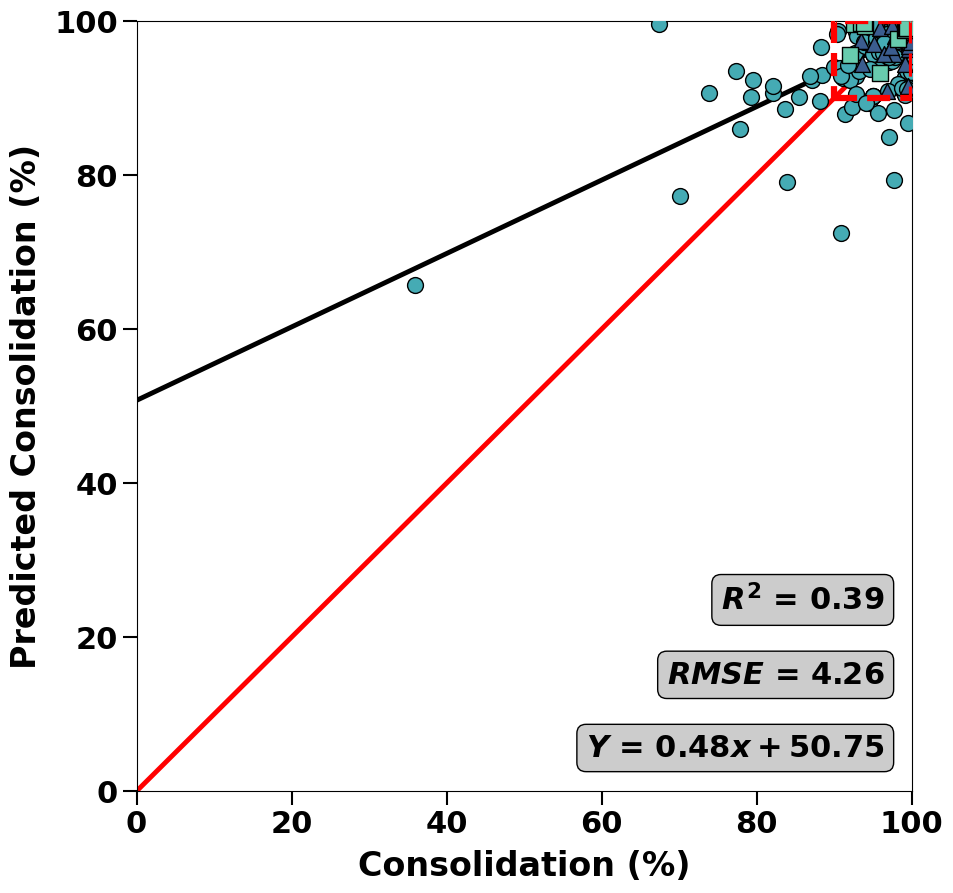

In [130]:
from matplotlib.patches import Rectangle

def RegLine(x):
  return slope * x + intercept

plt.rcParams.update({'font.size': 22})
pad_size = 8
txt_size = 24
m_size = 130

var = []
bbox = dict(boxstyle ="round", fc ="0.8")
gr_loc = 'best'
n=0
lim1=[0,1500]
lim2=[0,100]
lim3=[0,100]
lim4=[0,100]
lims = [lim1, lim2, lim3, lim4]

fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(111)

n = 3
x_index_nt = index_nt[n]
x_index_ht = index_ht[n]
x_index_hip = index_hip[n]
ax1.scatter(test_df[n][1][x_index_nt], predictions[n][x_index_nt], color='#45abb4', marker='o', s=m_size, edgecolors='k', label=(f'As Built'), zorder=5)
ax1.scatter(test_df[n][1][x_index_ht], predictions[n][x_index_ht], color='#3b5d8f', marker='^', s=m_size, edgecolors='k', label=(f'Heat Treated'), zorder=6)    
ax1.scatter(test_df[n][1][x_index_hip], predictions[n][x_index_hip], color='#68ccae', marker='s', s=m_size, edgecolors='k', label=(f'HIP'), zorder=7) 

ax1.set_xlabel(output_var[n], labelpad=pad_size, fontsize = txt_size, weight='bold')
ax1.set_ylabel((f'Predicted {output_var[n]}'), labelpad=pad_size, fontsize = txt_size, weight='bold')
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, linewidth=3.5, color='r')
ax1.set_xlim([lims[n][0], lims[n][1]])
ax1.set_ylim([lims[n][0], lims[n][1]])
ax1.tick_params(axis='both', which='major', width=1.5, length=10)

slope, intercept, r, p, std_err = stats.linregress(test_df[n][1].values.flatten(), predictions[n][:])

print(f'{output_var[n]}')
# The mean squared error
print("Mean squared error, RMSE = %.2f" % root_mean_squared_error(test_df[n][1].values.flatten(), predictions[n][:]))
# The coefficient of determination: 1 is perfect prediction
# Check for difference between r and r2 
# https://www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/#:~:text=Python%20%E2%80%93%20Coefficient%20of%20Determination-R2%20score.%20Coefficient%20of,is%20predictable%20from%20the%20input%20independent%20variable%20%28s%29.
print("Coefficient of determination, r2 = %.2f" % r2_score(test_df[n][1].values.flatten(), predictions[n][:]))

regline = list(map(RegLine, lims[n]))
ax1.plot(lims[n], regline, linewidth=3.5, color='k')
ax1.annotate(rf"$Y$ = {slope:.2f}$x + ${intercept:.2f}",
                bbox = bbox, xy=(0.965, 0.045), xycoords='axes fraction', horizontalalignment='right', zorder=8)

rmse_list = root_mean_squared_error(test_df[n][1].values.flatten(), predictions[n][:])
ax1.annotate(rf"$RMSE$ = {abs(rmse_list):.2f}",
                bbox = bbox, xy=(0.965, 0.045+0.095), xycoords='axes fraction', horizontalalignment='right', zorder=9)

r2_list = r2_score(test_df[n][1].values.flatten(), predictions[n][:])
ax1.annotate(rf"$R^2$ = {abs(r2_list):.2f}",
                bbox = bbox, xy=(0.965, 0.045+0.095+0.095), xycoords='axes fraction', horizontalalignment='right', zorder=9)

# Draw dashed line box around the region where both x and y axes are between 90 and 100
ax1.add_patch(Rectangle((90, 90), 10, 10, fill=False, linestyle='--', edgecolor='red', linewidth=4.5, zorder=10))

plt.show()

Yield Stress (MPa)
Mean squared error, RMSE = 127.73
Coefficient of determination, r2 = 0.85


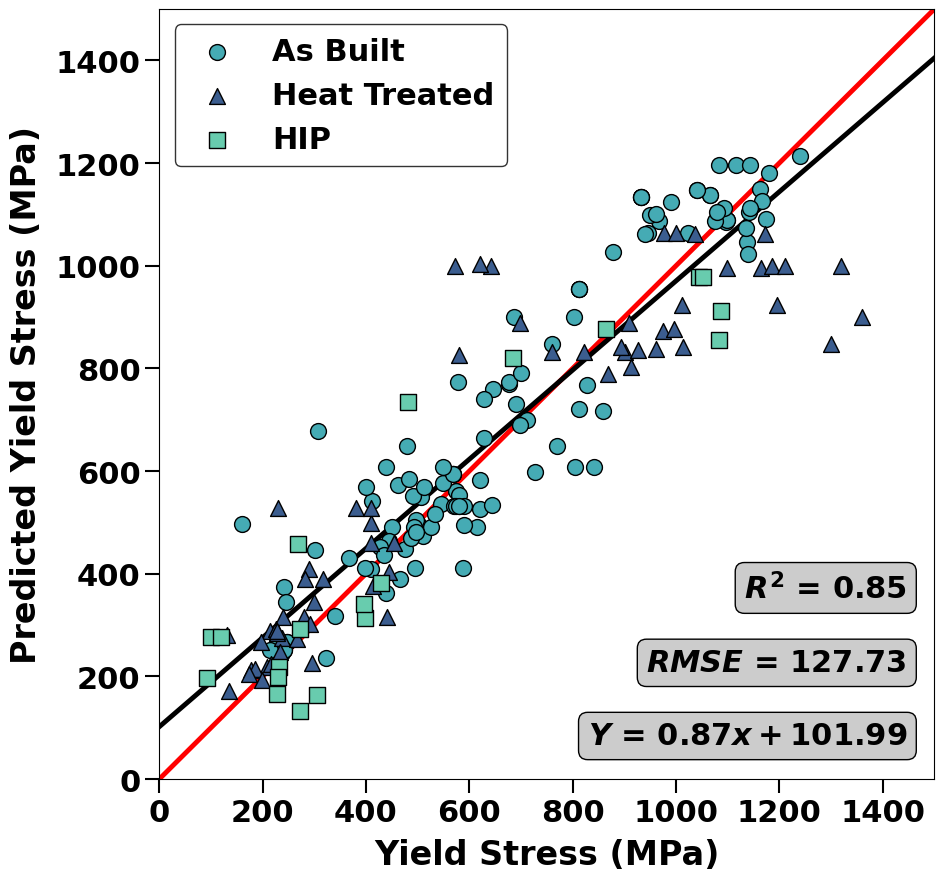

Average Work Hardening
Mean squared error, RMSE = 10.13
Coefficient of determination, r2 = 0.49


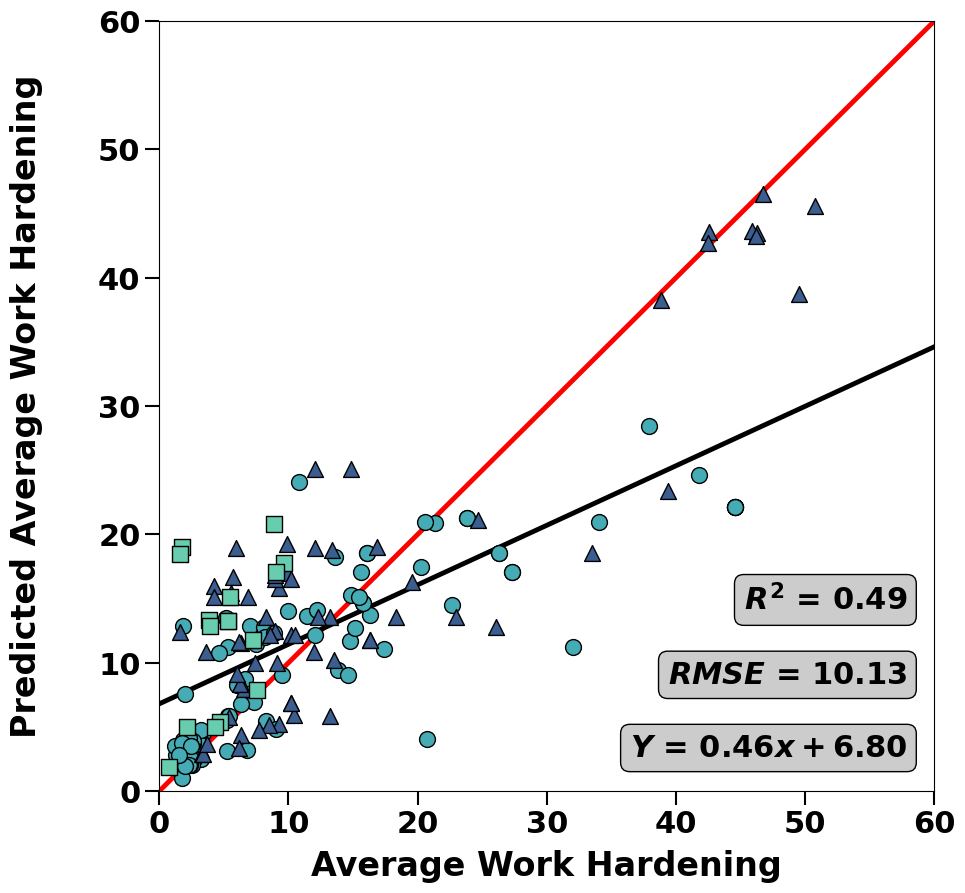

Elongation (%)
Mean squared error, RMSE = 10.58
Coefficient of determination, r2 = 0.64


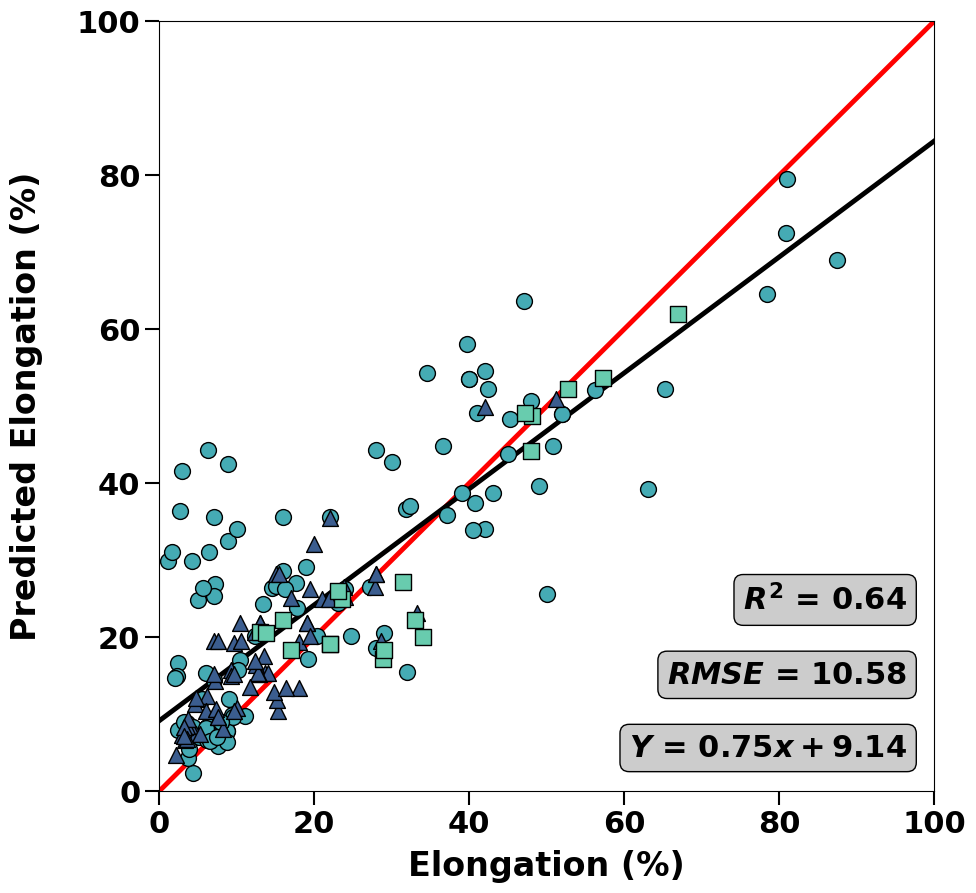

Consolidation (%)
Mean squared error, RMSE = 4.26
Coefficient of determination, r2 = 0.39


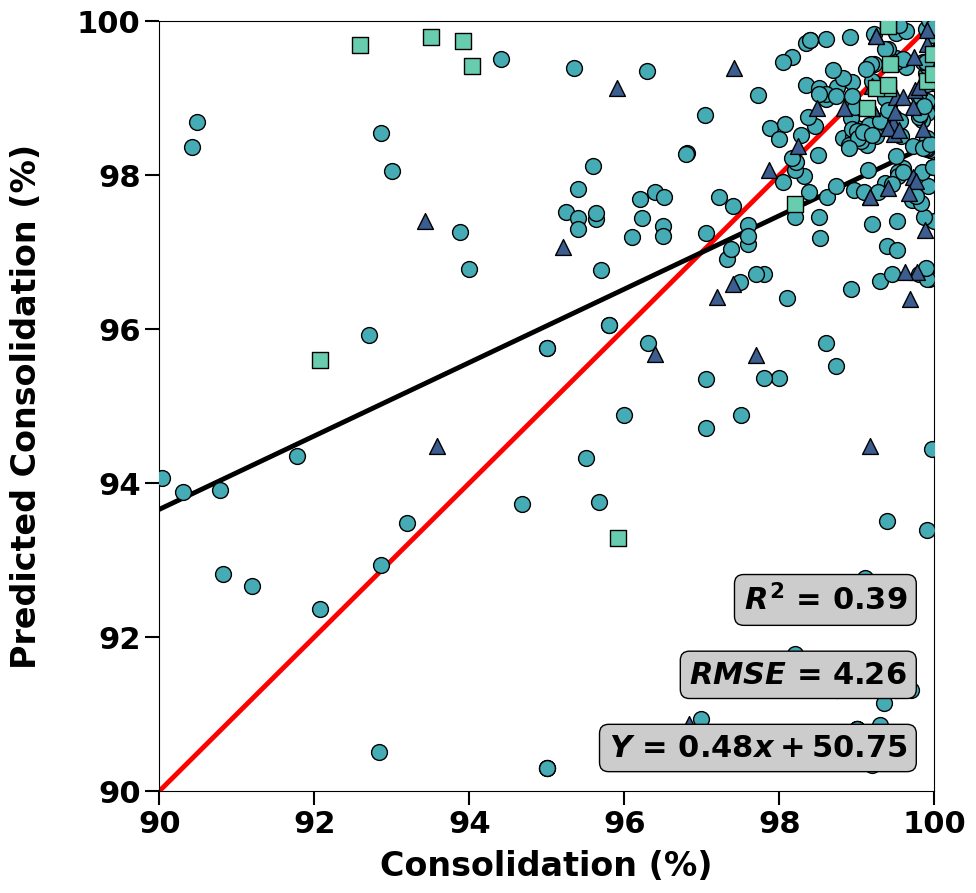

In [124]:
# Define plotting functions for visualisation

def RegLine(x):
    return slope * x + intercept

plt.rcParams.update({'font.size': 22})
pad_size = 8
txt_size = 24
m_size = 130

r2_list = []
rmse_list = []
bbox = dict(boxstyle ="round", fc ="0.8")
gr_loc = 'best'
lims = [[0,1500], [0,60], [0,100], [90,100]]

for n in range(4):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    x_index_nt = index_nt[n]
    x_index_ht = index_ht[n]
    x_index_hip = index_hip[n]
    
    ax.scatter(test_df[n][1][x_index_nt], predictions[n][x_index_nt], color='#45abb4', marker='o', s=m_size, edgecolors='k', label=(f'As Built'), zorder=5)
    ax.scatter(test_df[n][1][x_index_ht], predictions[n][x_index_ht], color='#3b5d8f', marker='^', s=m_size, edgecolors='k', label=(f'Heat Treated'), zorder=6)    
    ax.scatter(test_df[n][1][x_index_hip], predictions[n][x_index_hip], color='#68ccae', marker='s', s=m_size, edgecolors='k', label=(f'HIP'), zorder=7)   
    ax.set_xlabel(output_var[n], labelpad=pad_size, fontsize = txt_size, weight='bold')
    ax.set_ylabel((f'Predicted {output_var[n]}'), labelpad=pad_size, fontsize = txt_size, weight='bold')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linewidth=3.5, color='r')
    ax.set_xlim([lims[n][0], lims[n][1]])
    ax.set_ylim([lims[n][0], lims[n][1]])
    ax.tick_params(axis='both', which='major', width=1.5, length=10)

    slope, intercept, r, p, std_err = stats.linregress(test_df[n][1].values.flatten(), predictions[n][:])

    print(f'{output_var[n]}')
    # The mean squared error
    print("Mean squared error, RMSE = %.2f" % root_mean_squared_error(test_df[n][1].values.flatten(), predictions[n][:]))
    # The coefficient of determination: 1 is perfect prediction
    # Check for difference between r and r2 
    # https://www.geeksforgeeks.org/python-coefficient-of-determination-r2-score/#:~:text=Python%20%E2%80%93%20Coefficient%20of%20Determination-R2%20score.%20Coefficient%20of,is%20predictable%20from%20the%20input%20independent%20variable%20%28s%29.
    print("Coefficient of determination, r2 = %.2f" % r2_score(test_df[n][1].values.flatten(), predictions[n][:]))

    regline = list(map(RegLine, lims[n]))
    ax.plot(lims[n], regline, linewidth=3.5, color='k')
    ax.annotate(rf"$Y$ = {slope:.2f}$x + ${intercept:.2f}",
                    bbox = bbox, xy=(0.965, 0.045), xycoords='axes fraction', horizontalalignment='right', zorder=8)

    rmse_list.append(root_mean_squared_error(test_df[n][1].values.flatten(), predictions[n][:]))
    ax.annotate(rf"$RMSE$ = {abs(rmse_list[n]):.2f}",
                    bbox = bbox, xy=(0.965, 0.045+0.095), xycoords='axes fraction', horizontalalignment='right', zorder=9)

    r2_list.append(r2_score(test_df[n][1].values.flatten(), predictions[n][:]))
    ax.annotate(rf"$R^2$ = {abs(r2_list[n]):.2f}",
                    bbox = bbox, xy=(0.965, 0.045+0.095+0.095), xycoords='axes fraction', horizontalalignment='right', zorder=9)

    ax.get_yaxis().set_label_coords(-0.15,0.5)
    if n == 0:
        ax.legend(loc=gr_loc, ncol=1, edgecolor='black')
        # ax.legend(fontsize=txt_size, loc='center', bbox_to_anchor=(1.05, 1.1), edgecolor='black', ncol=4, markerscale=1.5)
        # ax.legend(fontsize=txt_size, bbox_to_anchor=(1, 1.02), edgecolor='black', markerscale=1.5,loc='upper left')

    plt.show()


In [142]:
from sklearn.metrics import mean_squared_error

# Define a function to compute RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Compute RMSE for each subset and print the results
for i, property in enumerate(output_var):
    print("Property:", property)

    x_index_nt = index_nt[i]
    x_index_ht = index_ht[i]
    x_index_hip = index_hip[i]

    rmse_as_built = root_mean_squared_error(test_df[i][1][x_index_nt], predictions[i][x_index_nt])
    rmse_heat_treated = root_mean_squared_error(test_df[i][1][x_index_ht], predictions[i][x_index_ht])
    rmse_hip = root_mean_squared_error(test_df[i][1][x_index_hip], predictions[i][x_index_hip])
    print("RMSE for As Built:", rmse_as_built)
    print("RMSE for Heat Treated:", rmse_heat_treated)
    print("RMSE for HIP:", rmse_hip)
    print()


Property: Yield Stress (MPa)
RMSE for As Built: 104.3851935030466
RMSE for Heat Treated: 162.2140282886131
RMSE for HIP: 129.60168817014662

Property: Average Work Hardening
RMSE for As Built: 12.283342349097289
RMSE for Heat Treated: 6.602294359521759
RMSE for HIP: 8.92205538302166

Property: Elongation (%)
RMSE for As Built: 13.045878853786272
RMSE for Heat Treated: 6.1494676091990765
RMSE for HIP: 6.52195855471169

Property: Consolidation (%)
RMSE for As Built: 4.602322452793042
RMSE for Heat Treated: 2.070688362910944
RMSE for HIP: 3.203337354748474



In [30]:
from sklearn.metrics import mean_squared_error
from scipy.stats import f_oneway

# Define a function to compute RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Compute RMSE for each subset and print the results
for i, property in enumerate(output_var):
    print("Property:", property)

    x_index_nt = index_nt[i]
    x_index_ht = index_ht[i]
    x_index_hip = index_hip[i]

    rmse_as_built = root_mean_squared_error(test_df[i][1][x_index_nt], predictions[i][x_index_nt])
    rmse_heat_treated = root_mean_squared_error(test_df[i][1][x_index_ht], predictions[i][x_index_ht])
    rmse_hip = root_mean_squared_error(test_df[i][1][x_index_hip], predictions[i][x_index_hip])
    print("RMSE for As Built:", rmse_as_built)
    print("RMSE for Heat Treated:", rmse_heat_treated)
    print("RMSE for HIP:", rmse_hip)
    print()

    # Perform ANOVA test
    f_statistic, p_value = f_oneway(predictions[i][x_index_nt], predictions[i][x_index_ht], predictions[i][x_index_hip])
    print("ANOVA F-statistic:", f_statistic)
    print("ANOVA p-value:", p_value)
    print()

Property: Yield Stress (MPa)
RMSE for As Built: 104.3851935030466
RMSE for Heat Treated: 162.2140282886131
RMSE for HIP: 129.60168817014662

ANOVA F-statistic: 6.352944003228118
ANOVA p-value: 0.0021176945987586497

Property: Average Work Hardening
RMSE for As Built: 12.283342349097289
RMSE for Heat Treated: 6.602294359521759
RMSE for HIP: 8.92205538302166

ANOVA F-statistic: 9.027091206861389
ANOVA p-value: 0.00018617298726349114

Property: Elongation (%)
RMSE for As Built: 13.045878853786272
RMSE for Heat Treated: 6.1494676091990765
RMSE for HIP: 6.52195855471169

ANOVA F-statistic: 10.414826588160345
ANOVA p-value: 5.0042938554868155e-05

Property: Consolidation (%)
RMSE for As Built: 4.602322452793042
RMSE for Heat Treated: 2.070688362910944
RMSE for HIP: 3.203337354748474

ANOVA F-statistic: 3.8484764681324846
ANOVA p-value: 0.022201919256425215



# Neural Network

In [40]:
def objective(trial, x, y, cv, scoring):
    params = {
        "learning_rate_init": trial.suggest_float("learning_rate_init", 0.0001, 0.1, step=0.005),
        "n_layers": trial.suggest_int("n_layers", 1, 8),
        "neurons_per_layer": [],
        "solver": "lbfgs",
        "activation": trial.suggest_categorical("activation", ["identity", "tanh", "relu"]),
    }
    
    # Find number of neurons for each layer
    for i in range(params["n_layers"]):
        neurons = trial.suggest_int(f"neurons_layer_{i+1}", 32, 256, step=32)
        params["neurons_per_layer"].append(neurons)
    
    # Constructs hidden_layer_sizes based on the number of layers and neurons per layer
    hidden_layer_sizes = tuple(params["neurons_per_layer"])
    
    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=params["learning_rate_init"],
        solver=params["solver"],
        activation=params["activation"],
        max_iter=1000
    )
    
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [41]:
# Delete previous studies
optuna.delete_study(study_name="NN_yield", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="NN_hardening", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="NN_elongation", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="NN_consolidation", storage="sqlite:///db.sqlite3")

In [42]:
%%capture capt
study_yield = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="NN_yield")
study_hardening = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="NN_hardening")
study_elongation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="NN_elongation")
study_consolidation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="NN_consolidation")
studies = [study_yield, study_hardening, study_elongation, study_consolidation]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, y, cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=50)

[I 2024-04-19 12:01:26,585] A new study created in RDB with name: NN_yield
[I 2024-04-19 12:01:26,602] A new study created in RDB with name: NN_hardening
[I 2024-04-19 12:01:26,619] A new study created in RDB with name: NN_elongation
[I 2024-04-19 12:01:26,637] A new study created in RDB with name: NN_consolidation
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neur

In [ ]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3b

^C


In [43]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/Neural Network/NeuralNetwork_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/Neural Network/NeuralNetwork_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/Neural Network/NeuralNetwork_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [44]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/Neural Network/NeuralNetwork_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [45]:
models = []
predictions = []
for i, data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    params = hyp_params[i]
    hidden_layer_sizes = tuple(params[f"neurons_layer_{j+1}"] for j in range(params["n_layers"]))

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=params["learning_rate_init"],
        solver="lbfgs",
        activation=params["activation"],
        random_state=seed,
        max_iter=500
    )
    
    model.fit(x, y)
    predictions.append(model.predict(test_scaled[i][0]))
    models.append(model)

# Convert consolidation predictions back to original scale
predictions[3] = np.power(10, predictions[3])

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ra

Yield Stress (MPa)
Mean squared error, RMSE = 217.66
Coefficient of determination, r2 = 0.57
Average Work Hardening
Mean squared error, RMSE = 13.98
Coefficient of determination, r2 = 0.04
Elongation (%)
Mean squared error, RMSE = 12.32
Coefficient of determination, r2 = 0.51
Consolidation (%)
Mean squared error, RMSE = 6.12
Coefficient of determination, r2 = -0.25


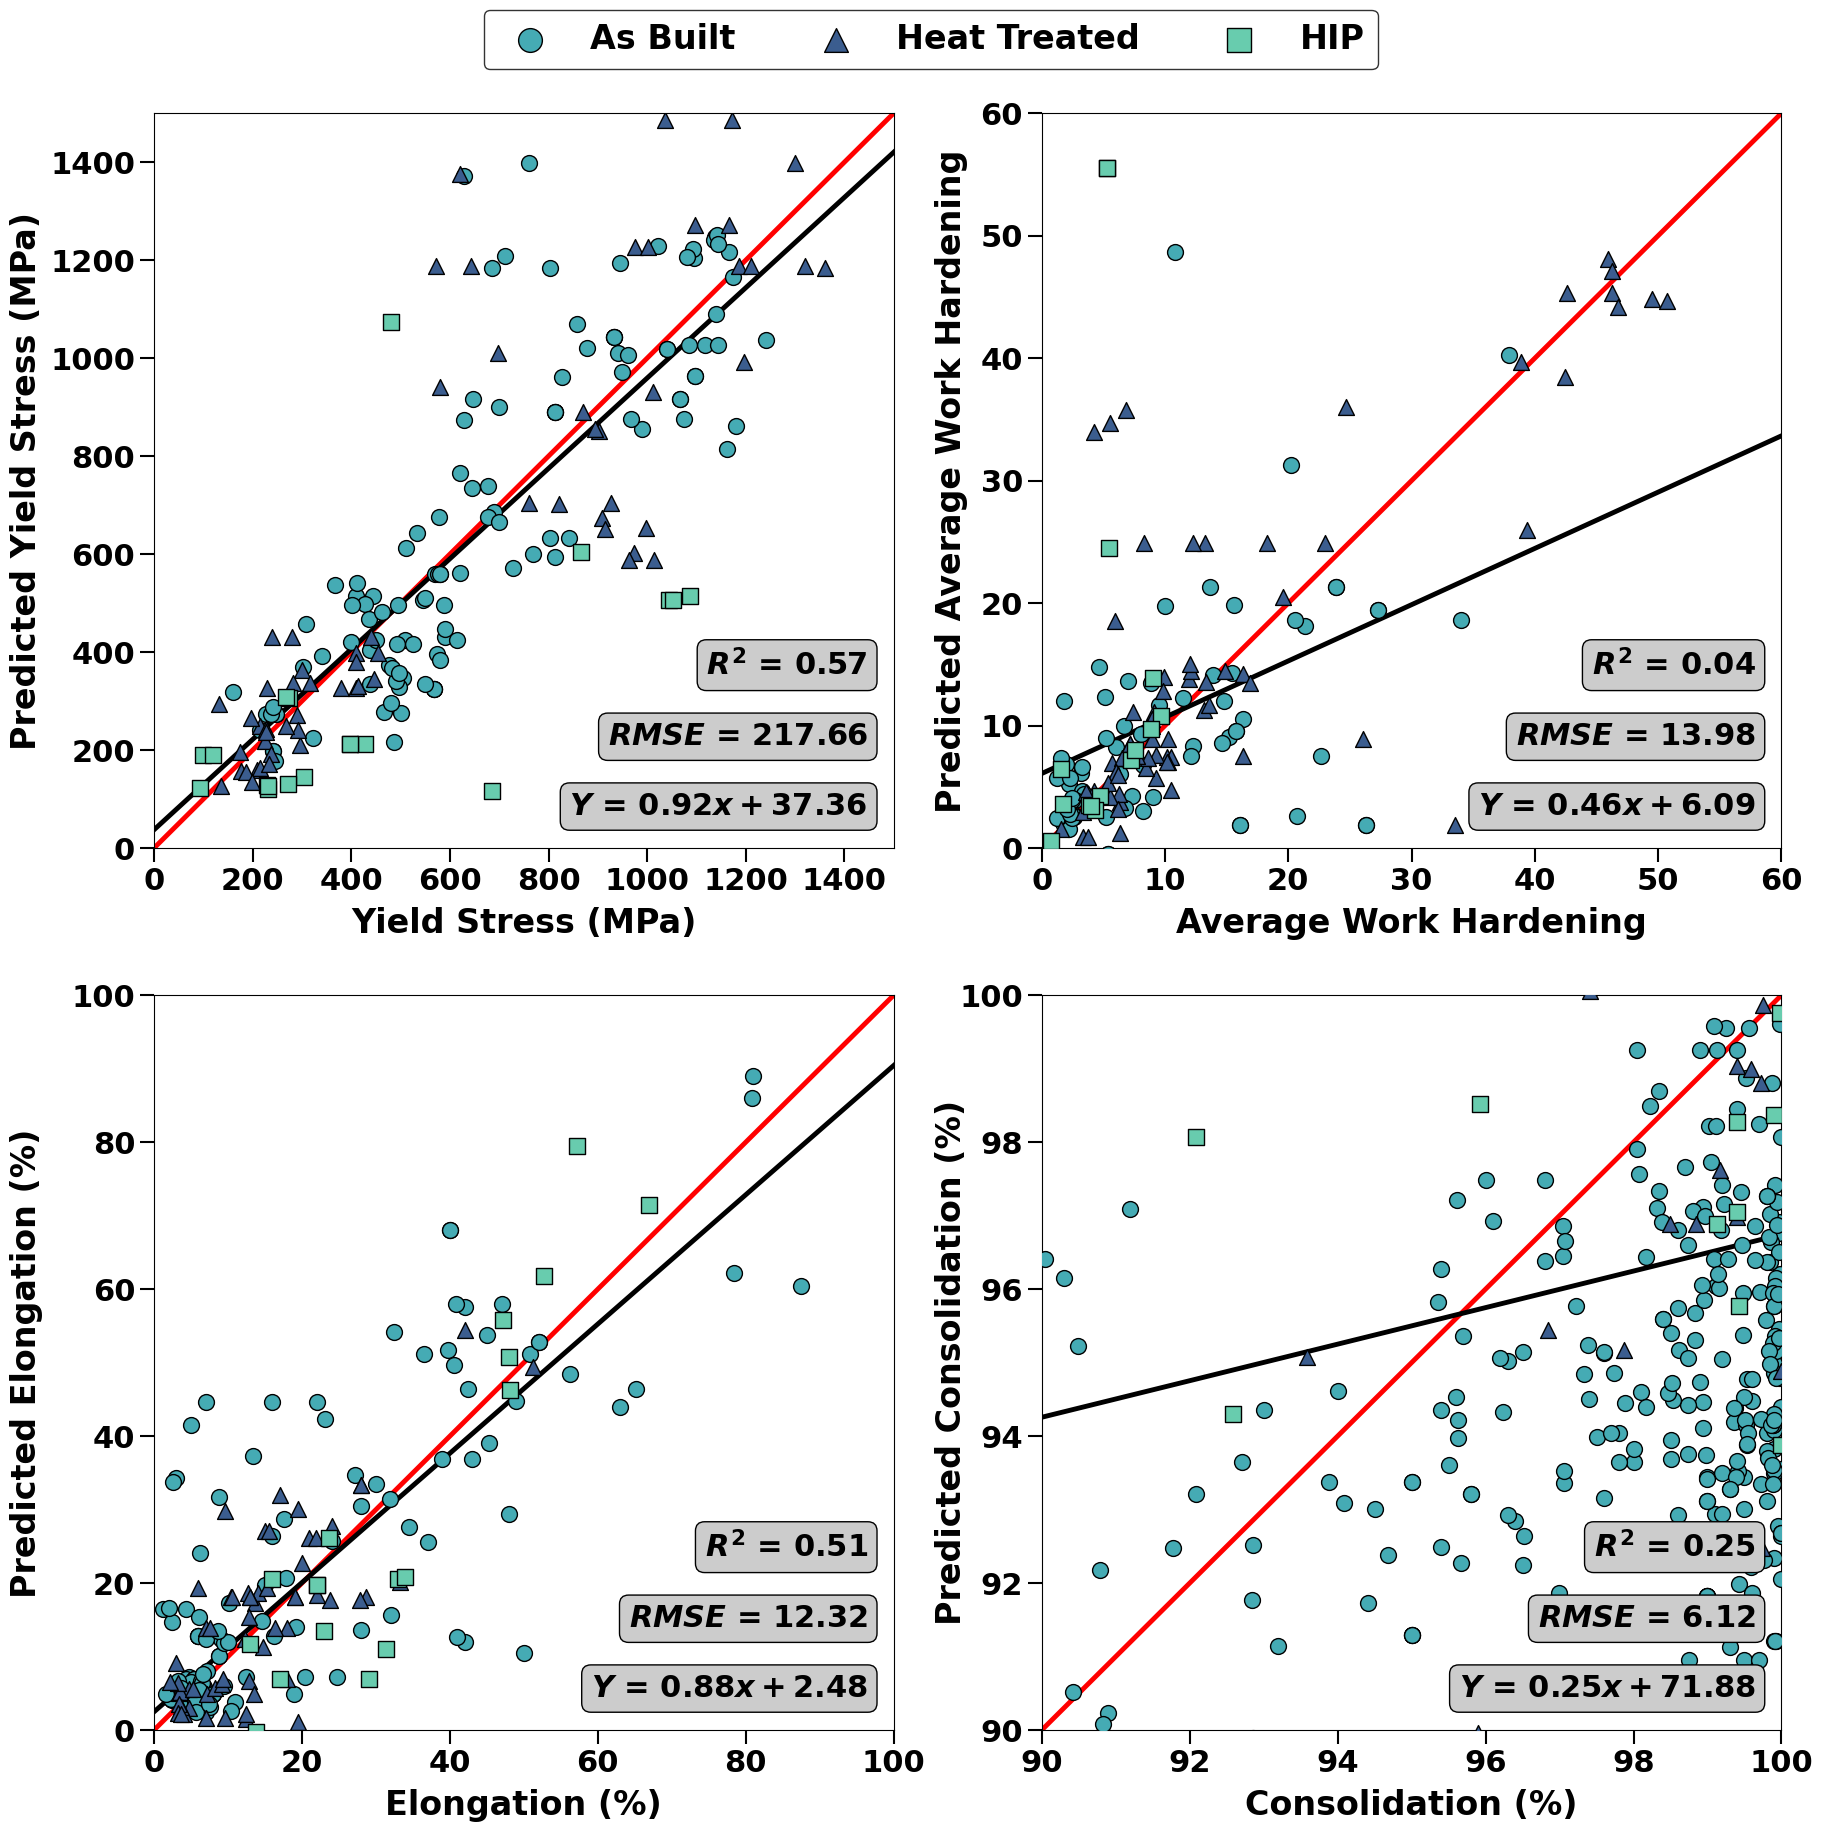

In [46]:
plot_perf()

In [47]:
# No feature importance for NN. for possible solution, ref link
# https://stackoverflow.com/questions/44460937/most-important-features-in-mlpclassifier-in-sklearn

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = se

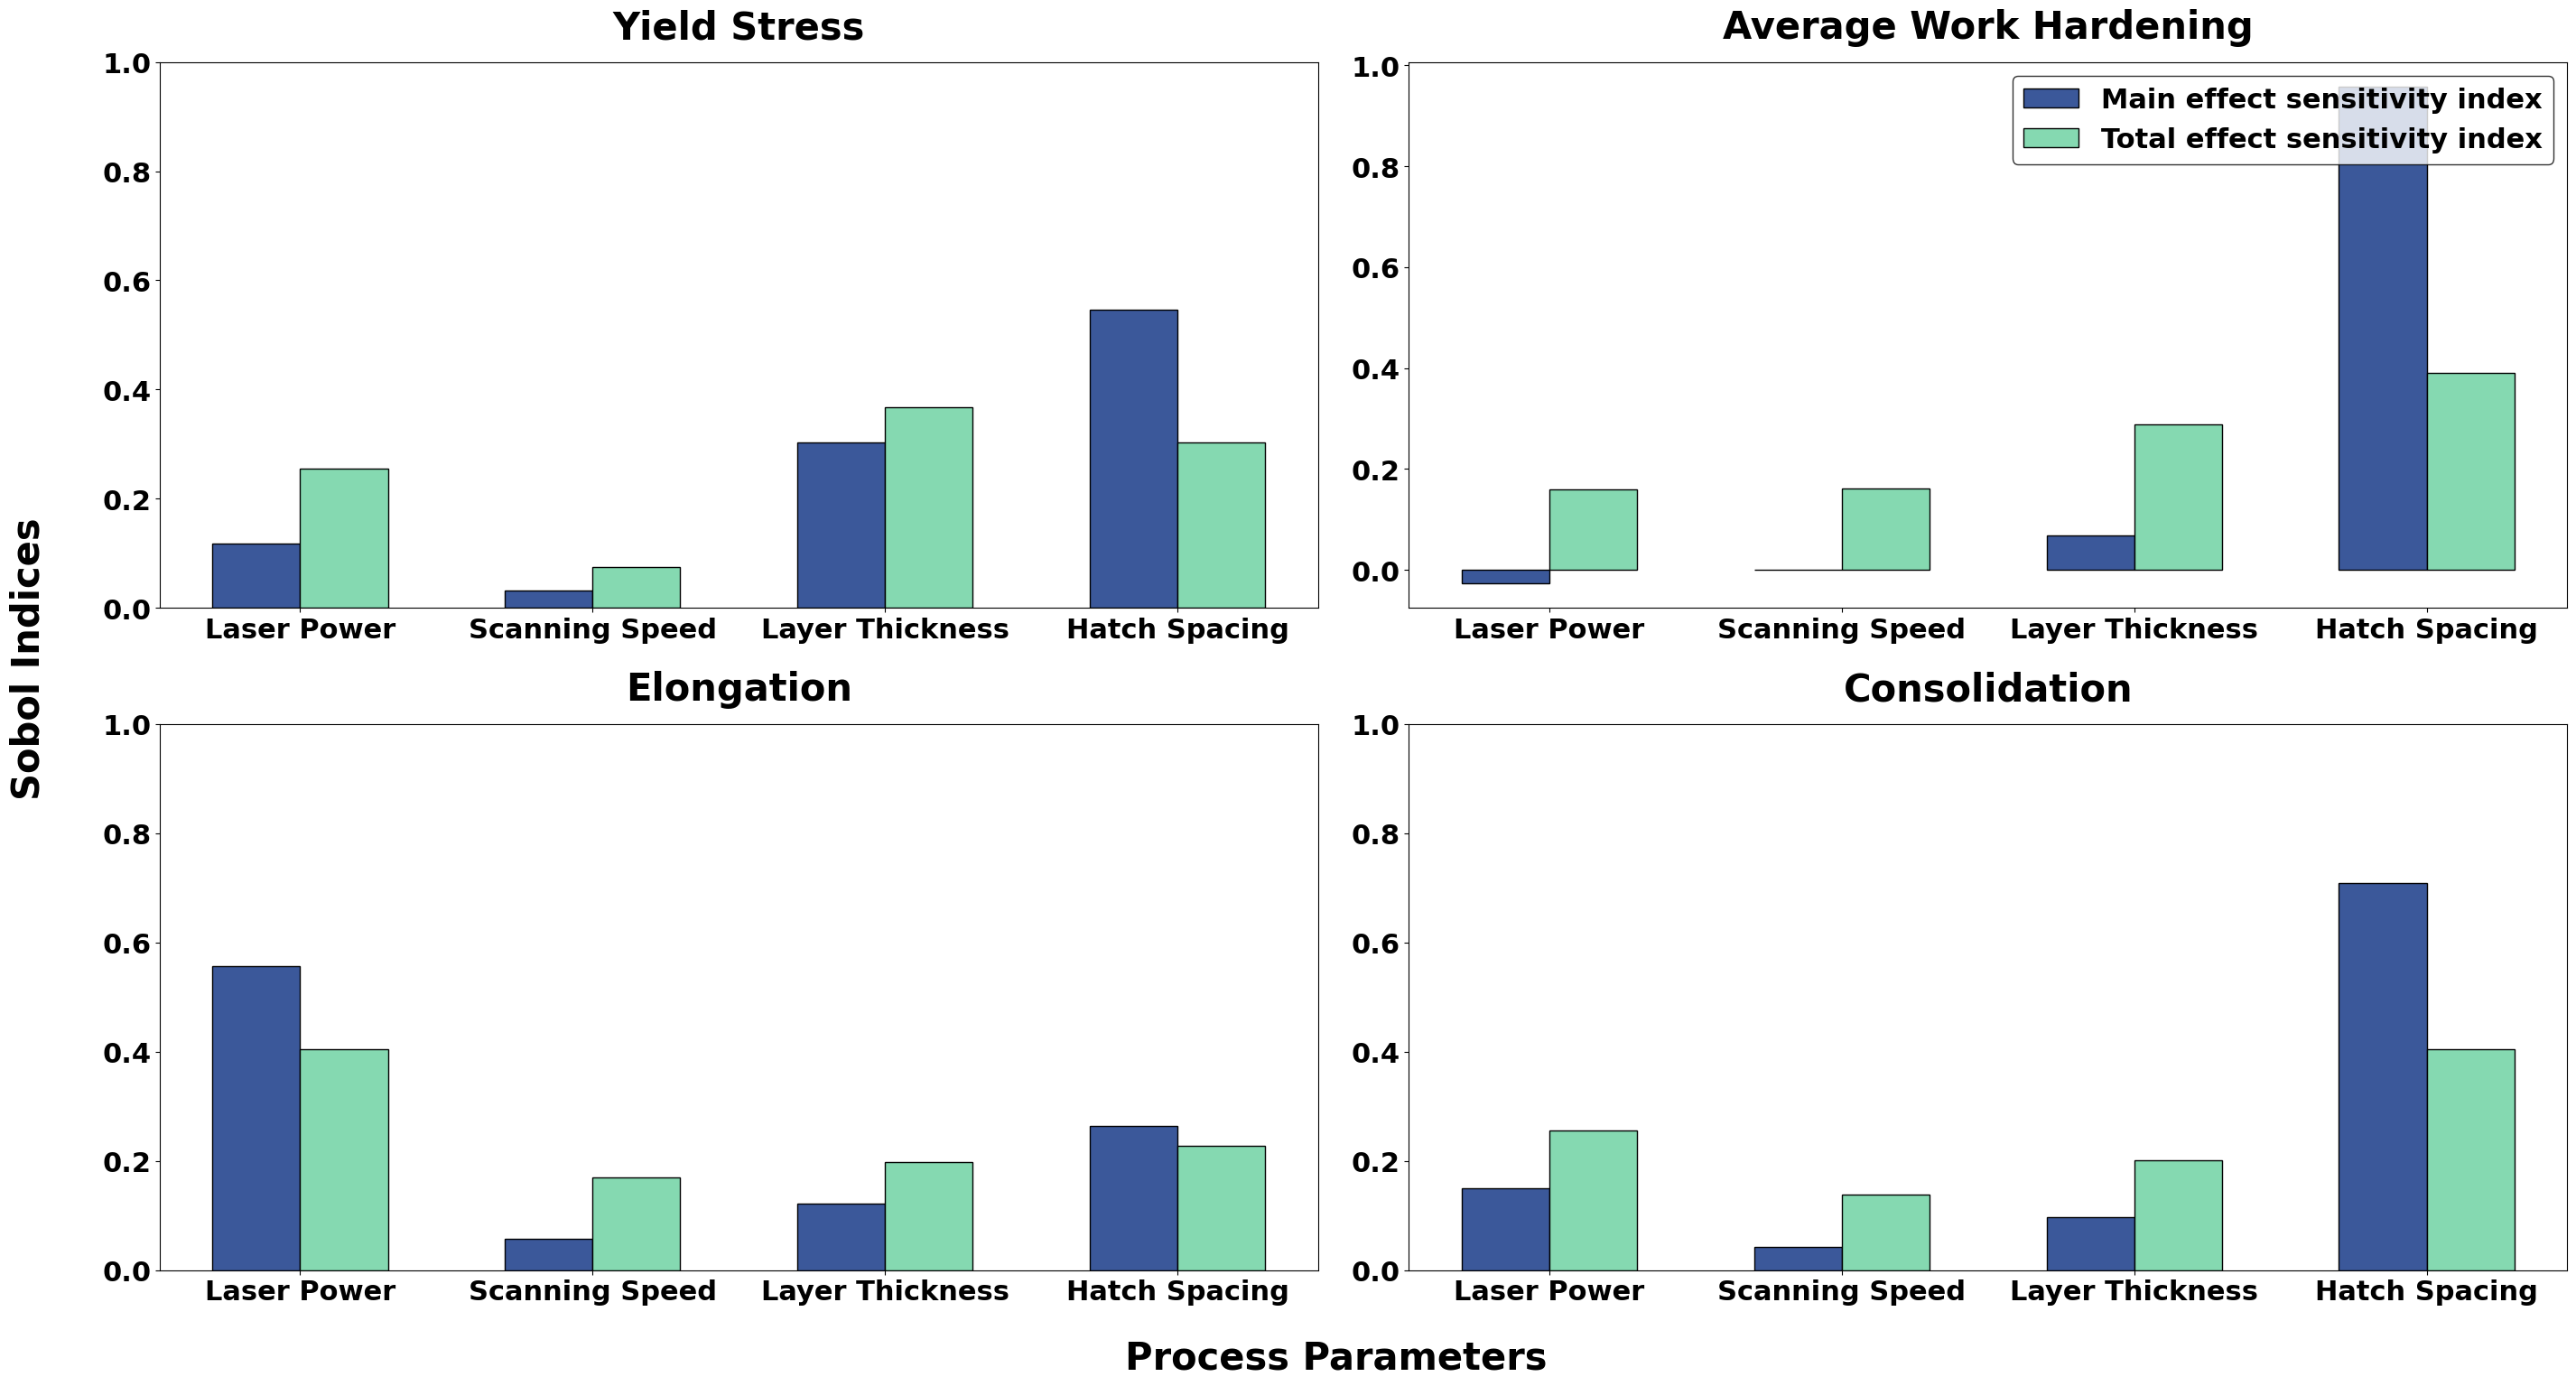

In [48]:
Plot_Sobol()

# Support Vector Machine

In [49]:
def objective(trial, x, y, cv, scoring):
    np.random.seed(42)
    param = {
            "kernel": trial.suggest_categorical("kernel", ["rbf", "sigmoid"]),
            "degree": trial.suggest_int("degree", 1, 8, step=1),
            "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
            "C": trial.suggest_loguniform("C", 1e-4, 1e4), # https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel
            "epsilon": trial.suggest_loguniform("epsilon", 1e-4, 1e4),
            "cache_size": 20000
            }

    model = SVR(**param)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [50]:
# Delete previous studies
optuna.delete_study(study_name="SVM_yield", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="SVM_hardening", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="SVM_elongation", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="SVM_consolidation", storage="sqlite:///db.sqlite3")

In [51]:
%%capture capt
study_yield = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="SVM_yield")
study_hardening = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="SVM_hardening")
study_elongation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="SVM_elongation")
study_consolidation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="SVM_consolidation")
studies = [study_yield, study_hardening, study_elongation, study_consolidation]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, np.ravel(y), cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]
    
    studies[i].optimize(func, n_trials=50)

[I 2024-04-19 13:06:14,431] A new study created in RDB with name: SVM_yield
[I 2024-04-19 13:06:14,457] A new study created in RDB with name: SVM_hardening
[I 2024-04-19 13:06:14,478] A new study created in RDB with name: SVM_elongation
[I 2024-04-19 13:06:14,496] A new study created in RDB with name: SVM_consolidation
[I 2024-04-19 13:06:14,858] Trial 0 finished with value: 524.553392307269 and parameters: {'kernel': 'sigmoid', 'degree': 6, 'gamma': 'auto', 'C': 131.18152568424838, 'epsilon': 31.09210091421383}. Best is trial 0 with value: 524.553392307269.
[I 2024-04-19 13:06:14,974] Trial 1 finished with value: 359.8783505520265 and parameters: {'kernel': 'rbf', 'degree': 2, 'gamma': 'scale', 'C': 0.04869830534267353, 'epsilon': 0.00279129622081828}. Best is trial 1 with value: 359.8783505520265.
[I 2024-04-19 13:06:15,043] Trial 2 finished with value: 203.7251789211785 and parameters: {'kernel': 'rbf', 'degree': 1, 'gamma': 'auto', 'C': 19.794210219717996, 'epsilon': 0.058454990395

In [ ]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3b

^C


In [52]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/SVM/SVM_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/SVM/SVM_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/SVM/SVM_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [53]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/SVM/SVM_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [54]:
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = SVR(**hyp_params[i])
    model.fit(x, y)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

# Convert consolidation predictions back to original scale
predictions[3] = np.power(10, predictions[3])

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed w

Yield Stress (MPa)
Mean squared error, RMSE = 154.51
Coefficient of determination, r2 = 0.78
Average Work Hardening
Mean squared error, RMSE = 9.64
Coefficient of determination, r2 = 0.54
Elongation (%)
Mean squared error, RMSE = 12.73
Coefficient of determination, r2 = 0.48
Consolidation (%)
Mean squared error, RMSE = 5.88
Coefficient of determination, r2 = -0.16


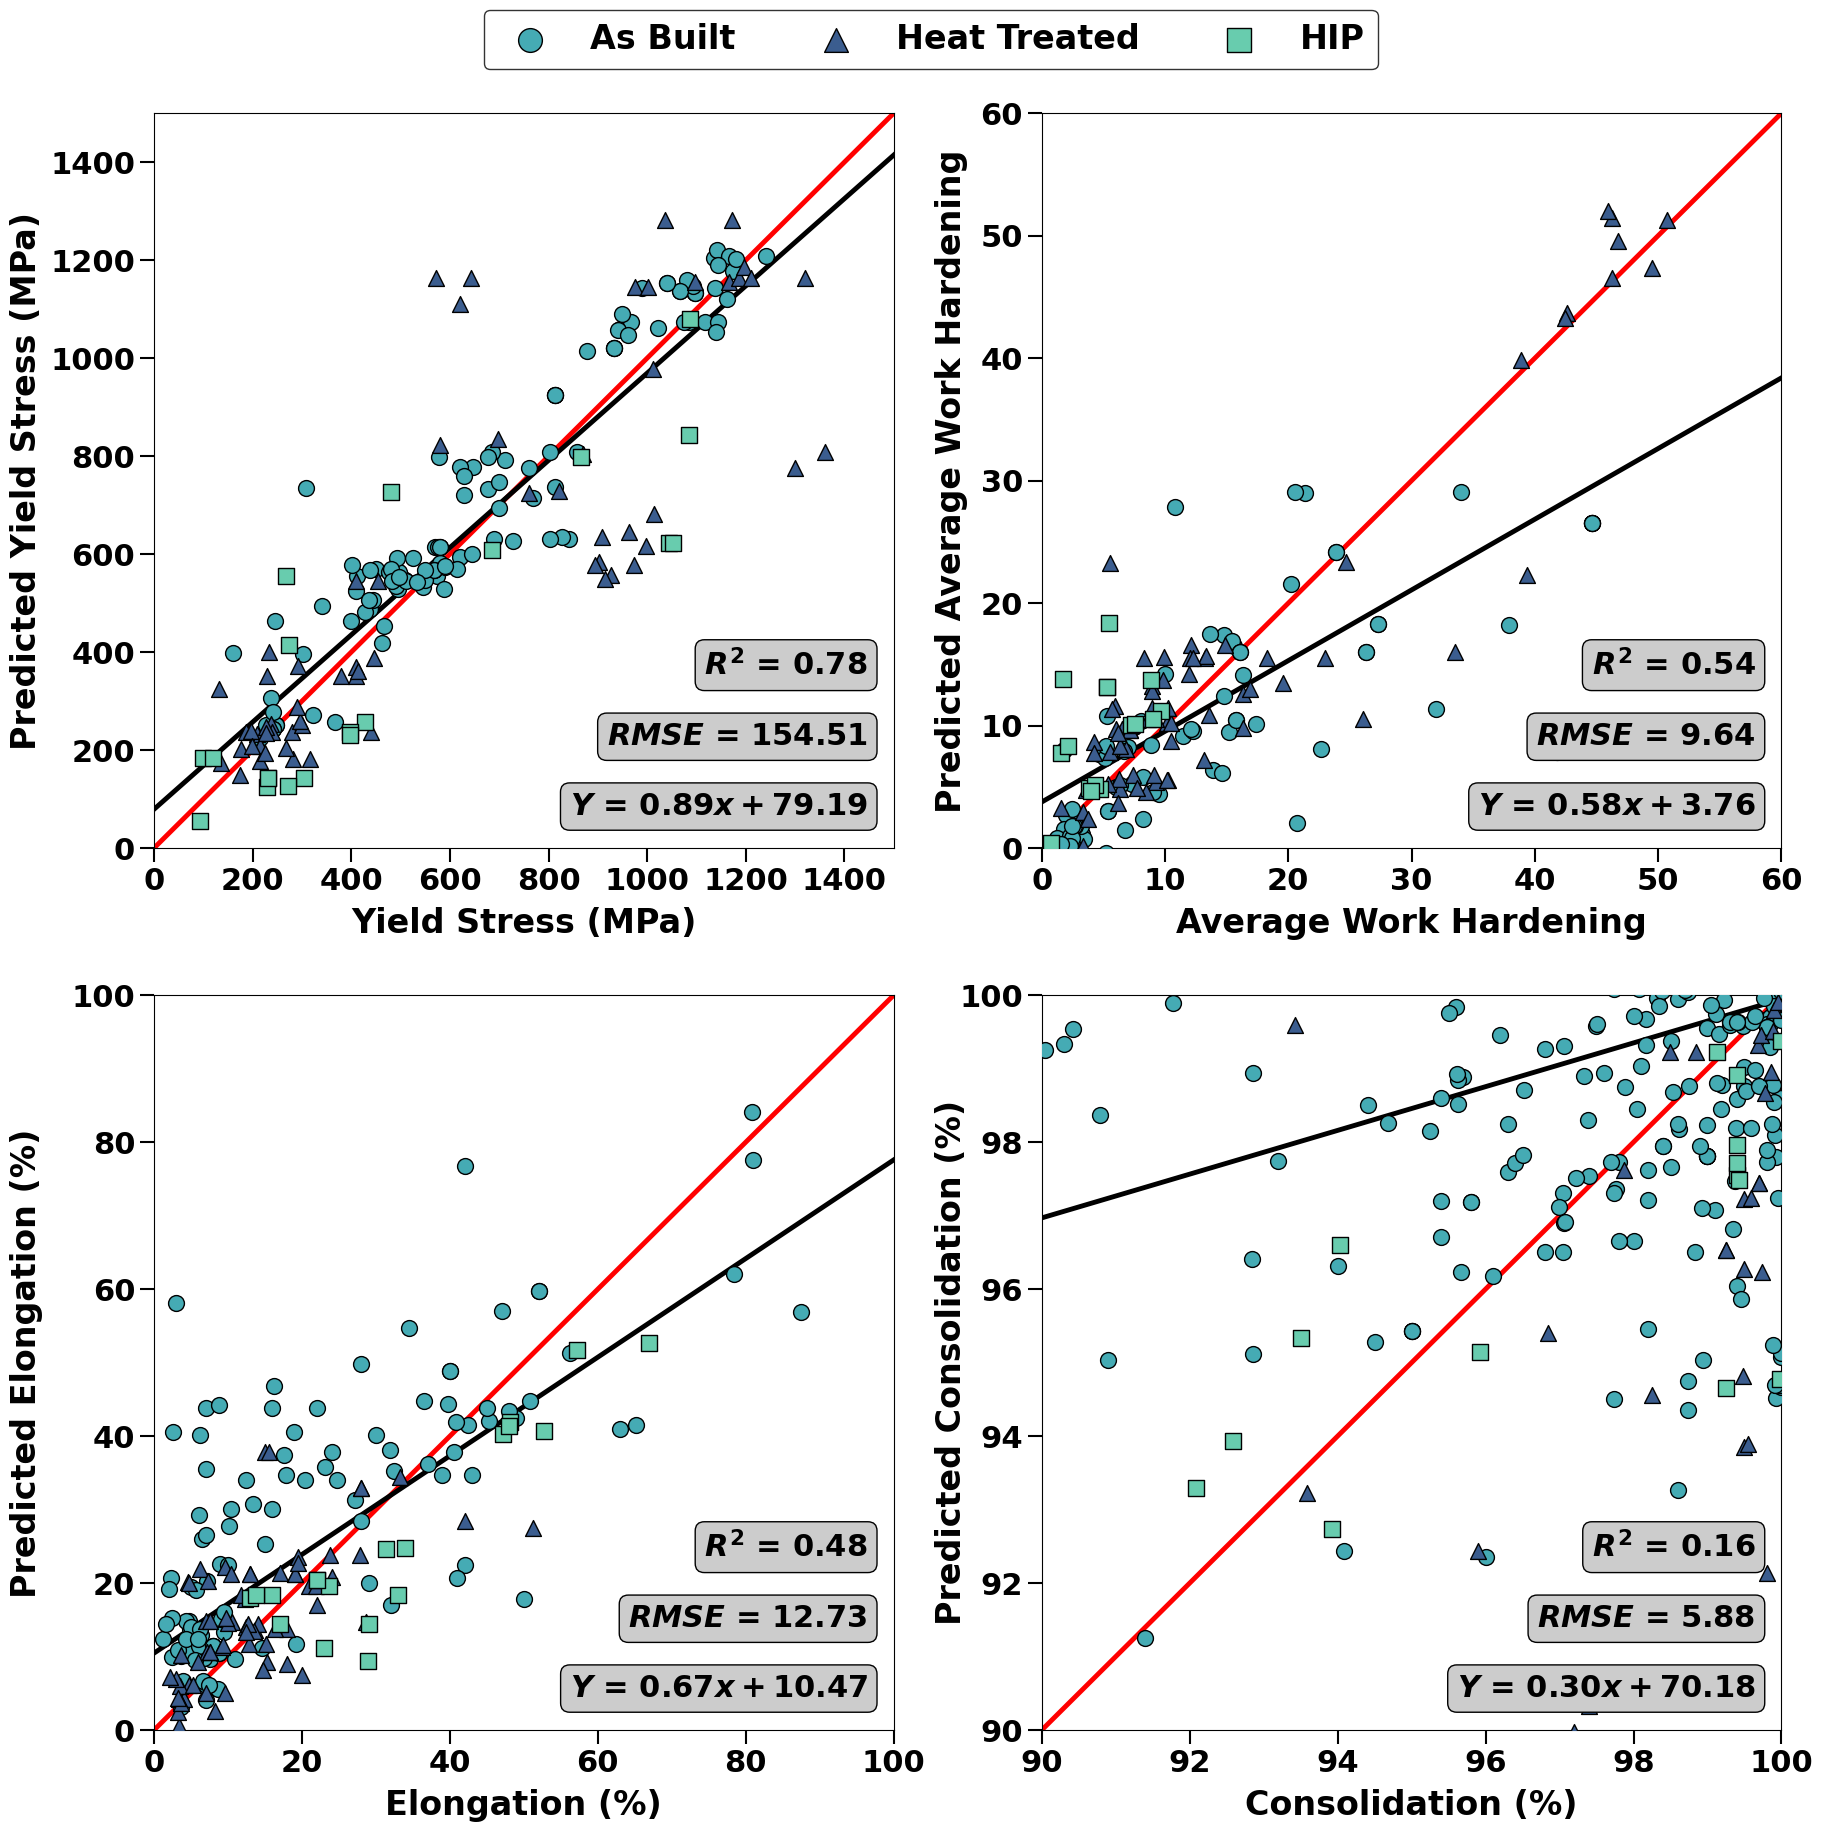

In [55]:
plot_perf()

In [56]:
# No feature importance for SVM. for possible solution, ref link
# https://stackoverflow.com/questions/48380962/what-is-the-python-code-to-show-the-feature-importance-in-svm

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, work

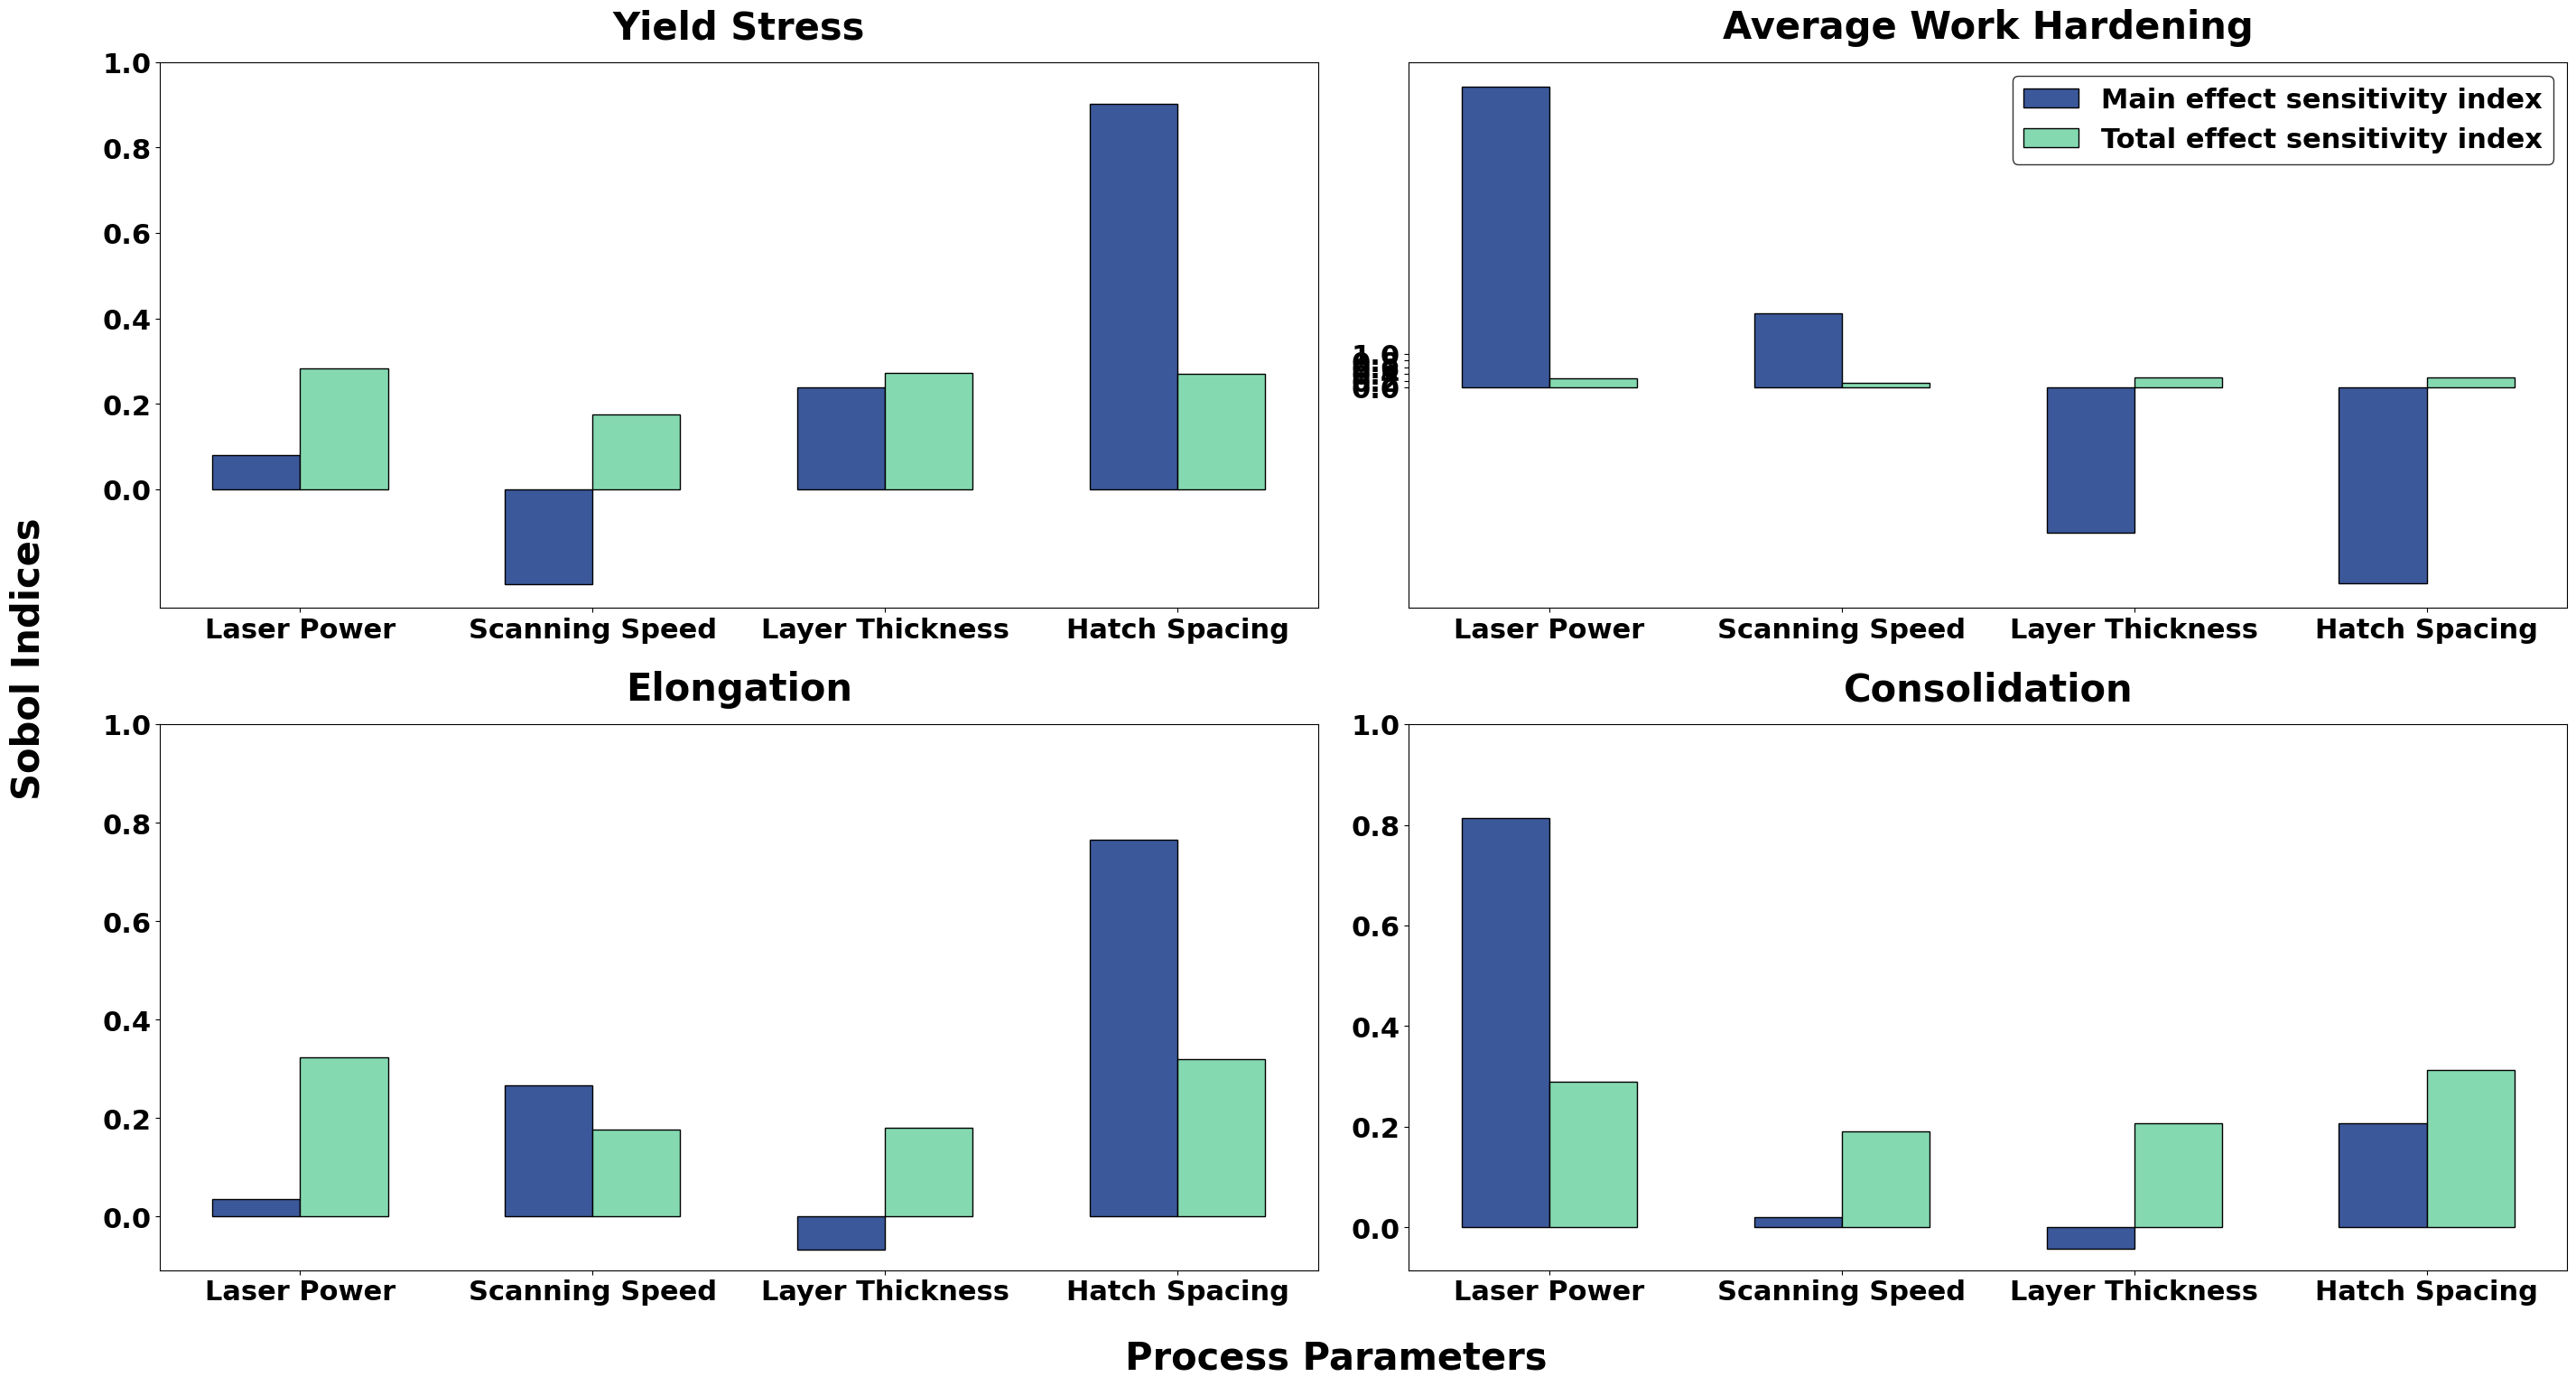

In [57]:
Plot_Sobol(leg_loc='upper right')

# Decision Tree

In [58]:
def objective(trial, x, y, cv, scoring):

    param = {
            # No Poisson criterion as it can't take negative inputs (in the case of negative hardening rates)
            "criterion": trial.suggest_categorical("criterion", ["squared_error", "friedman_mse", "absolute_error"]),
            "max_depth": trial.suggest_int("max_depth", 2, 20, step=1),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20, step=2),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10, step=1)
        }

    model = DecisionTreeRegressor(**param)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [59]:
# Delete previous studies
optuna.delete_study(study_name="DecisionTree_yield", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="DecisionTree_hardening", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="DecisionTree_elongation", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="DecisionTree_consolidation", storage="sqlite:///db.sqlite3")

In [60]:
%%capture capt
study_yield = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="DecisionTree_yield")
study_hardening = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="DecisionTree_hardening")
study_elongation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="DecisionTree_elongation")
study_consolidation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="DecisionTree_consolidation")
studies = [study_yield, study_hardening, study_elongation, study_consolidation]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, y, cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=50)

[I 2024-04-19 13:25:04,921] A new study created in RDB with name: DecisionTree_yield
[I 2024-04-19 13:25:04,940] A new study created in RDB with name: DecisionTree_hardening
[I 2024-04-19 13:25:04,960] A new study created in RDB with name: DecisionTree_elongation
[I 2024-04-19 13:25:04,983] A new study created in RDB with name: DecisionTree_consolidation
[I 2024-04-19 13:25:05,299] Trial 0 finished with value: 134.74651571990628 and parameters: {'criterion': 'friedman_mse', 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 10}. Best is trial 0 with value: 134.74651571990628.
[I 2024-04-19 13:25:05,364] Trial 1 finished with value: 200.007977803063 and parameters: {'criterion': 'squared_error', 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 0 with value: 134.74651571990628.
[I 2024-04-19 13:25:05,399] Trial 2 finished with value: 143.676379292096 and parameters: {'criterion': 'friedman_mse', 'max_depth': 14, 'min_samples_split': 20, 'min_sampl

In [ ]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3b

^C


In [61]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/Decision Tree/DTree_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/Decision Tree/DTree_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/Decision Tree/DTree_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [62]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/Decision Tree/DTree_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [63]:
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = DecisionTreeRegressor(**hyp_params[i])
    model.fit(x, y)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

# Convert consolidation predictions back to original scale
predictions[3] = np.power(10, predictions[3])

Yield Stress (MPa)
Mean squared error, RMSE = 165.92
Coefficient of determination, r2 = 0.75
Average Work Hardening
Mean squared error, RMSE = 10.60
Coefficient of determination, r2 = 0.45
Elongation (%)
Mean squared error, RMSE = 11.91
Coefficient of determination, r2 = 0.55
Consolidation (%)
Mean squared error, RMSE = 5.24
Coefficient of determination, r2 = 0.08


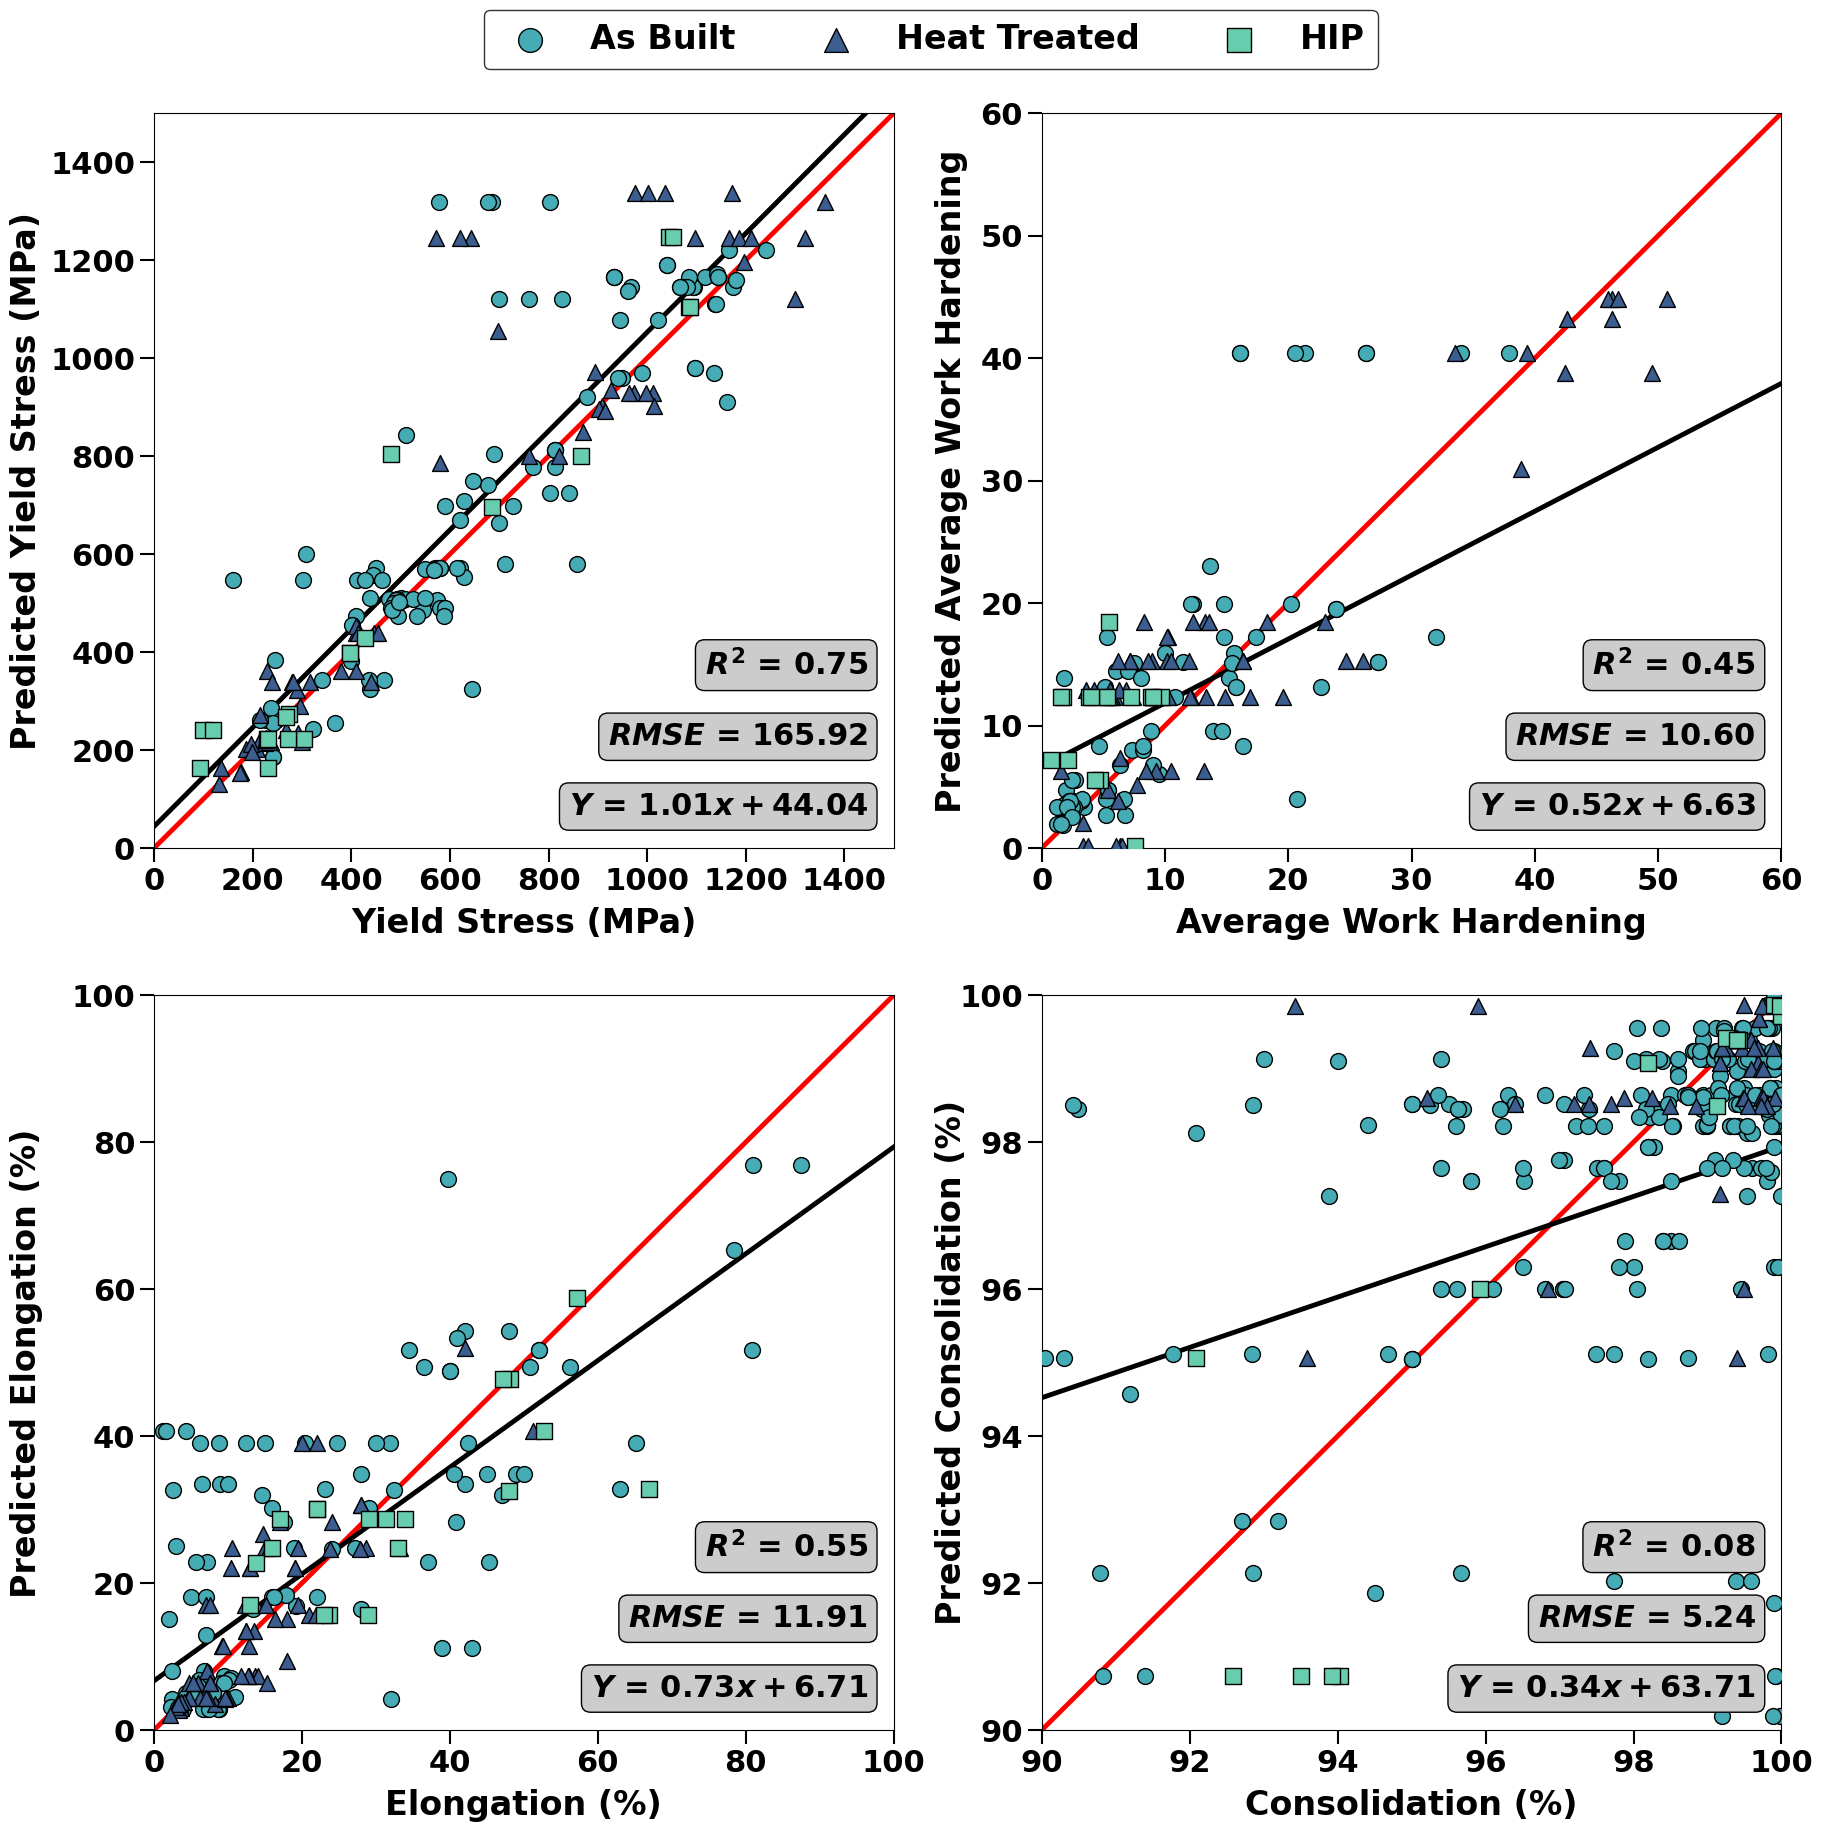

In [64]:
plot_perf()

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power o

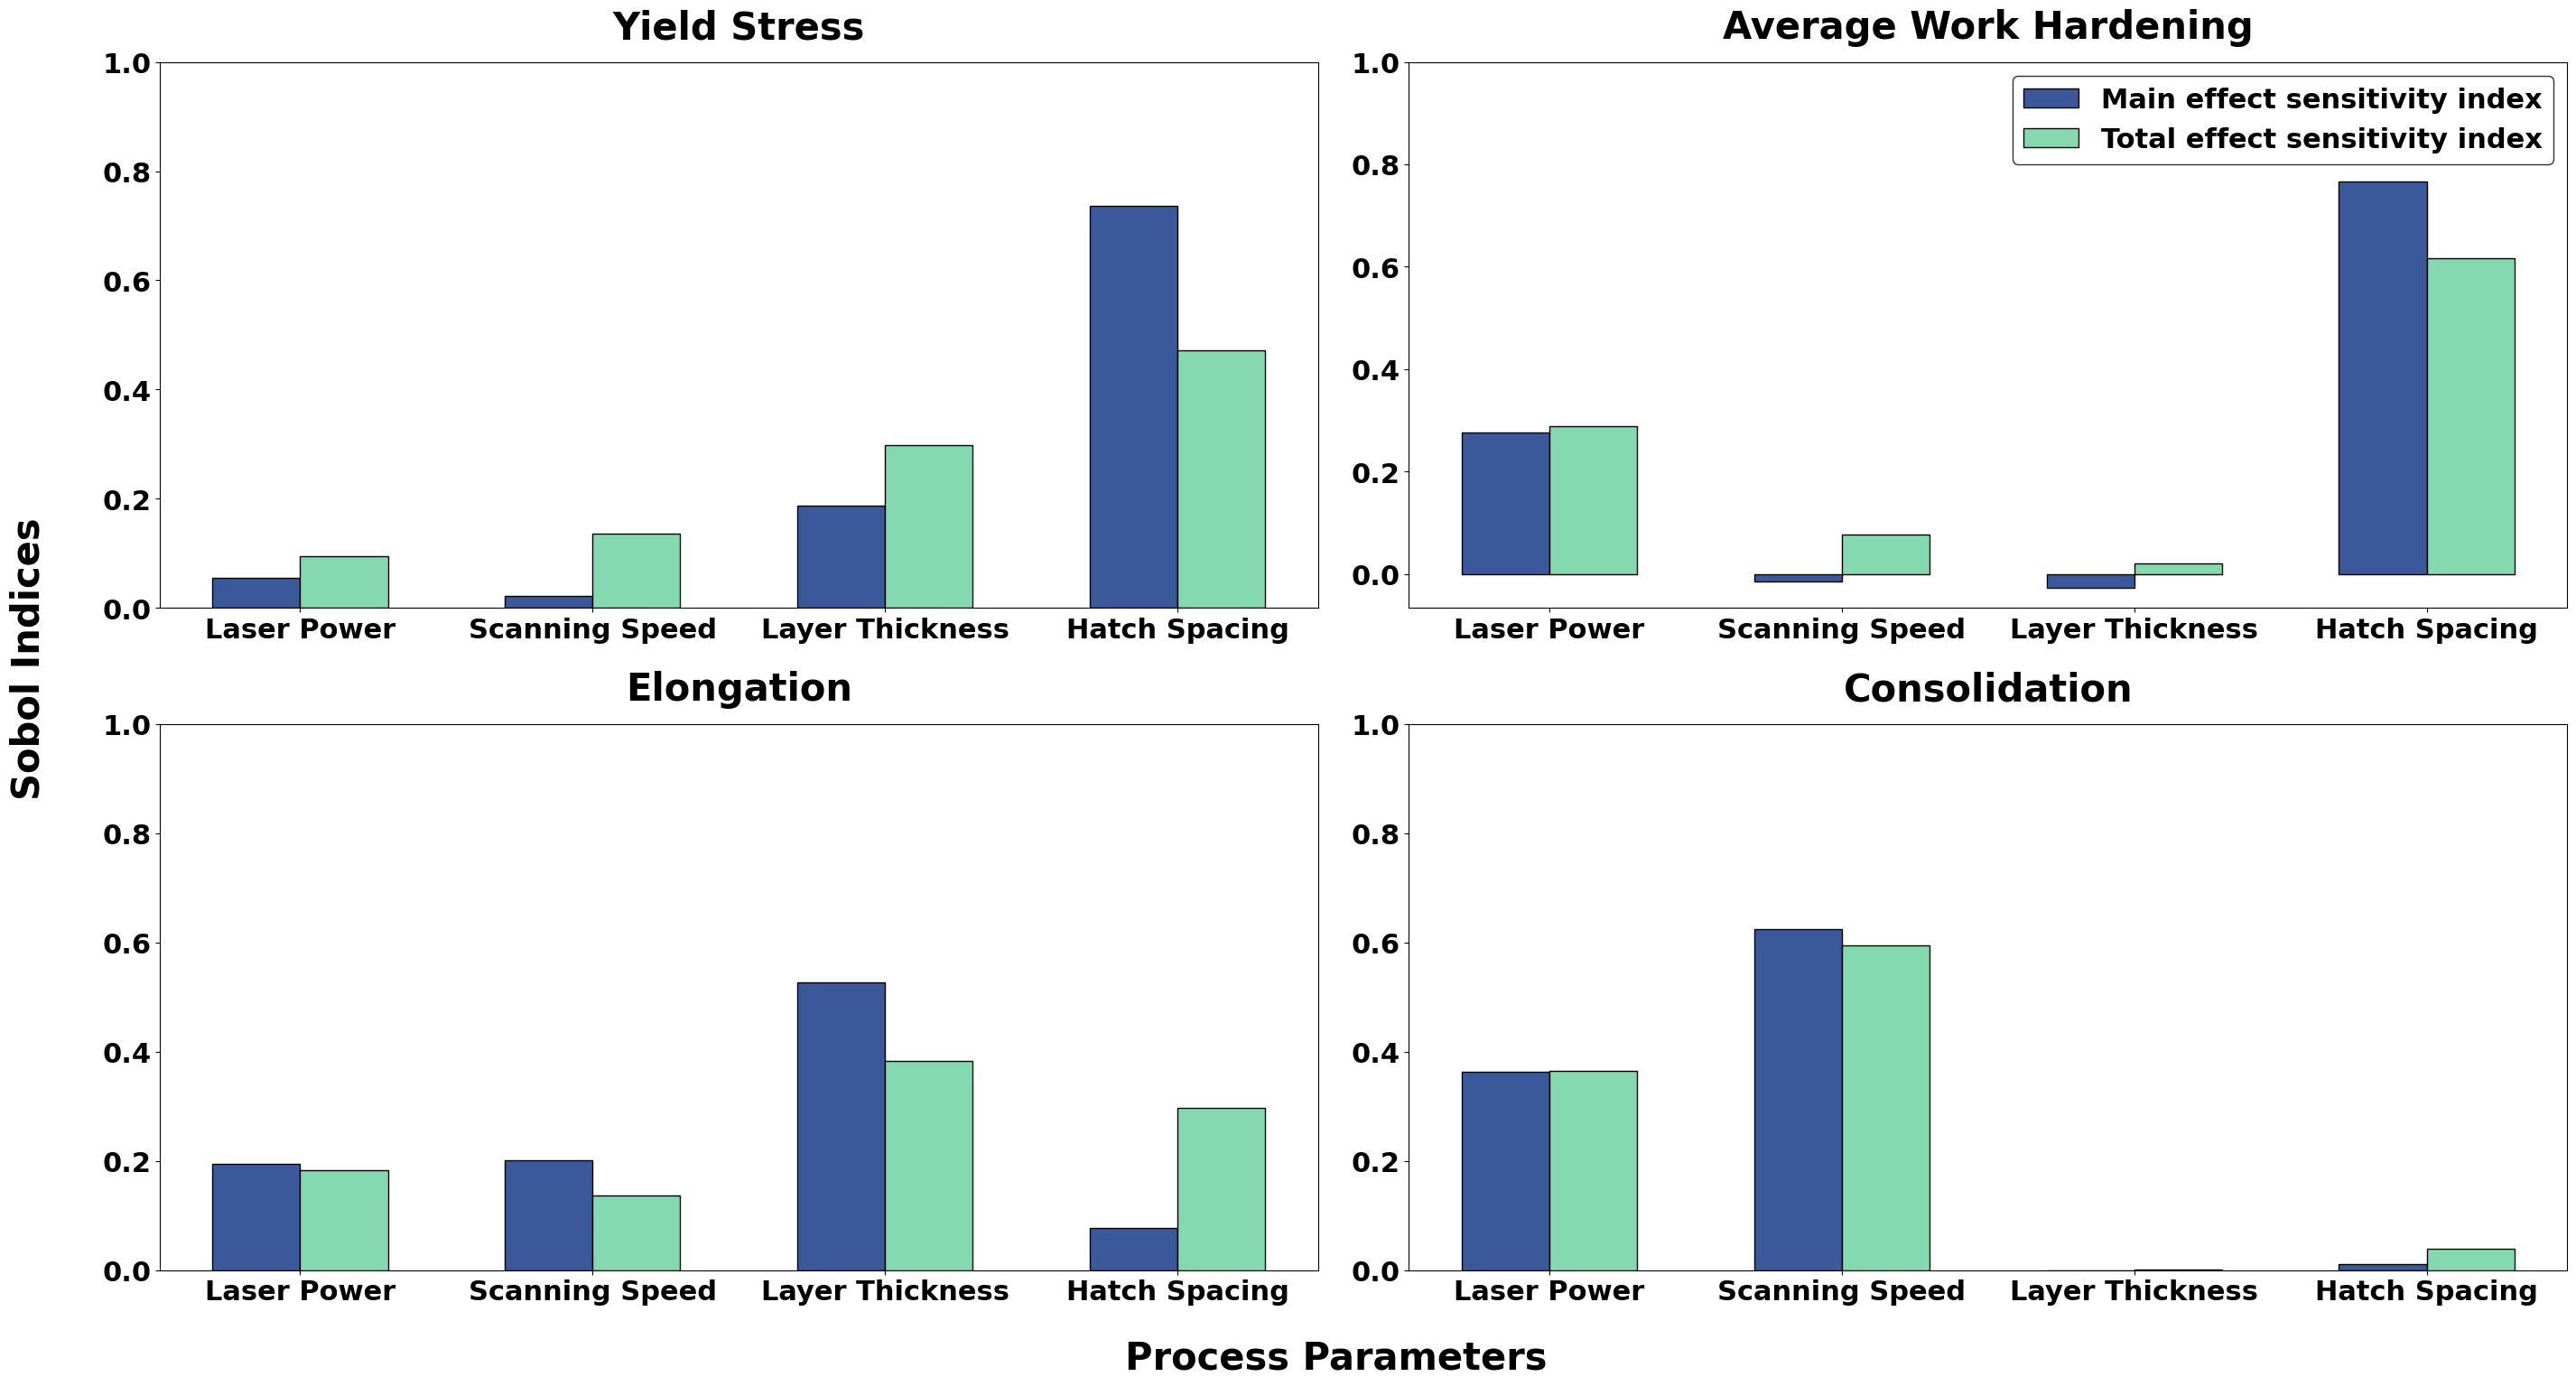

In [65]:
Plot_Sobol(leg_loc='upper right')

# Random Forest

In [66]:
def objective(trial, x, y, cv, scoring):

    param = {
            # No Poisson criterion as it can't take negative inputs (in the case of negative hardening rates)
            "criterion": trial.suggest_categorical("criterion", ["squared_error", "friedman_mse", "absolute_error"]),
            "n_estimators": trial.suggest_int('n_estimators', 50, 300, step=10),
            "max_depth": trial.suggest_int("max_depth", 2, 10, step=2),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20, step=2),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10, step=1)
        }

    model = RandomForestRegressor(**param)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [67]:
# Delete previous studies
optuna.delete_study(study_name="RandomForest_yield", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="RandomForest_hardening", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="RandomForest_elongation", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="RandomForest_consolidation", storage="sqlite:///db.sqlite3")

In [68]:
%%capture capt
study_yield = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="RandomForest_yield")
study_hardening = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="RandomForest_hardening")
study_elongation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="RandomForest_elongation")
study_consolidation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="RandomForest_consolidation")
studies = [study_yield, study_hardening, study_elongation, study_consolidation]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, np.ravel(y), cv=kfold, scoring="neg_root_mean_squared_error")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=50)

[I 2024-04-19 13:25:44,448] A new study created in RDB with name: RandomForest_yield
[I 2024-04-19 13:25:44,465] A new study created in RDB with name: RandomForest_hardening
[I 2024-04-19 13:25:44,484] A new study created in RDB with name: RandomForest_elongation
[I 2024-04-19 13:25:44,500] A new study created in RDB with name: RandomForest_consolidation
[I 2024-04-19 13:25:44,868] Trial 0 finished with value: 132.76933550447683 and parameters: {'criterion': 'friedman_mse', 'n_estimators': 130, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 132.76933550447683.
[I 2024-04-19 13:25:45,024] Trial 1 finished with value: 136.55448673949542 and parameters: {'criterion': 'squared_error', 'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 8}. Best is trial 0 with value: 132.76933550447683.
[I 2024-04-19 13:25:45,334] Trial 2 finished with value: 134.25922936279298 and parameters: {'criterion': 'squared_error', 'n_est

In [55]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3

^C


In [69]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/Random Forest/RForest_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/Random Forest/RForest_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/Random Forest/RForest_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [70]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/Random Forest/RForest_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [71]:
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = RandomForestRegressor(**hyp_params[i])
    model.fit(x, y)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

# Convert consolidation predictions back to original scale
predictions[3] = np.power(10, predictions[3])

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 

Yield Stress (MPa)
Mean squared error, RMSE = 122.26
Coefficient of determination, r2 = 0.86
Average Work Hardening
Mean squared error, RMSE = 9.87
Coefficient of determination, r2 = 0.52
Elongation (%)
Mean squared error, RMSE = 10.38
Coefficient of determination, r2 = 0.66
Consolidation (%)
Mean squared error, RMSE = 4.59
Coefficient of determination, r2 = 0.29


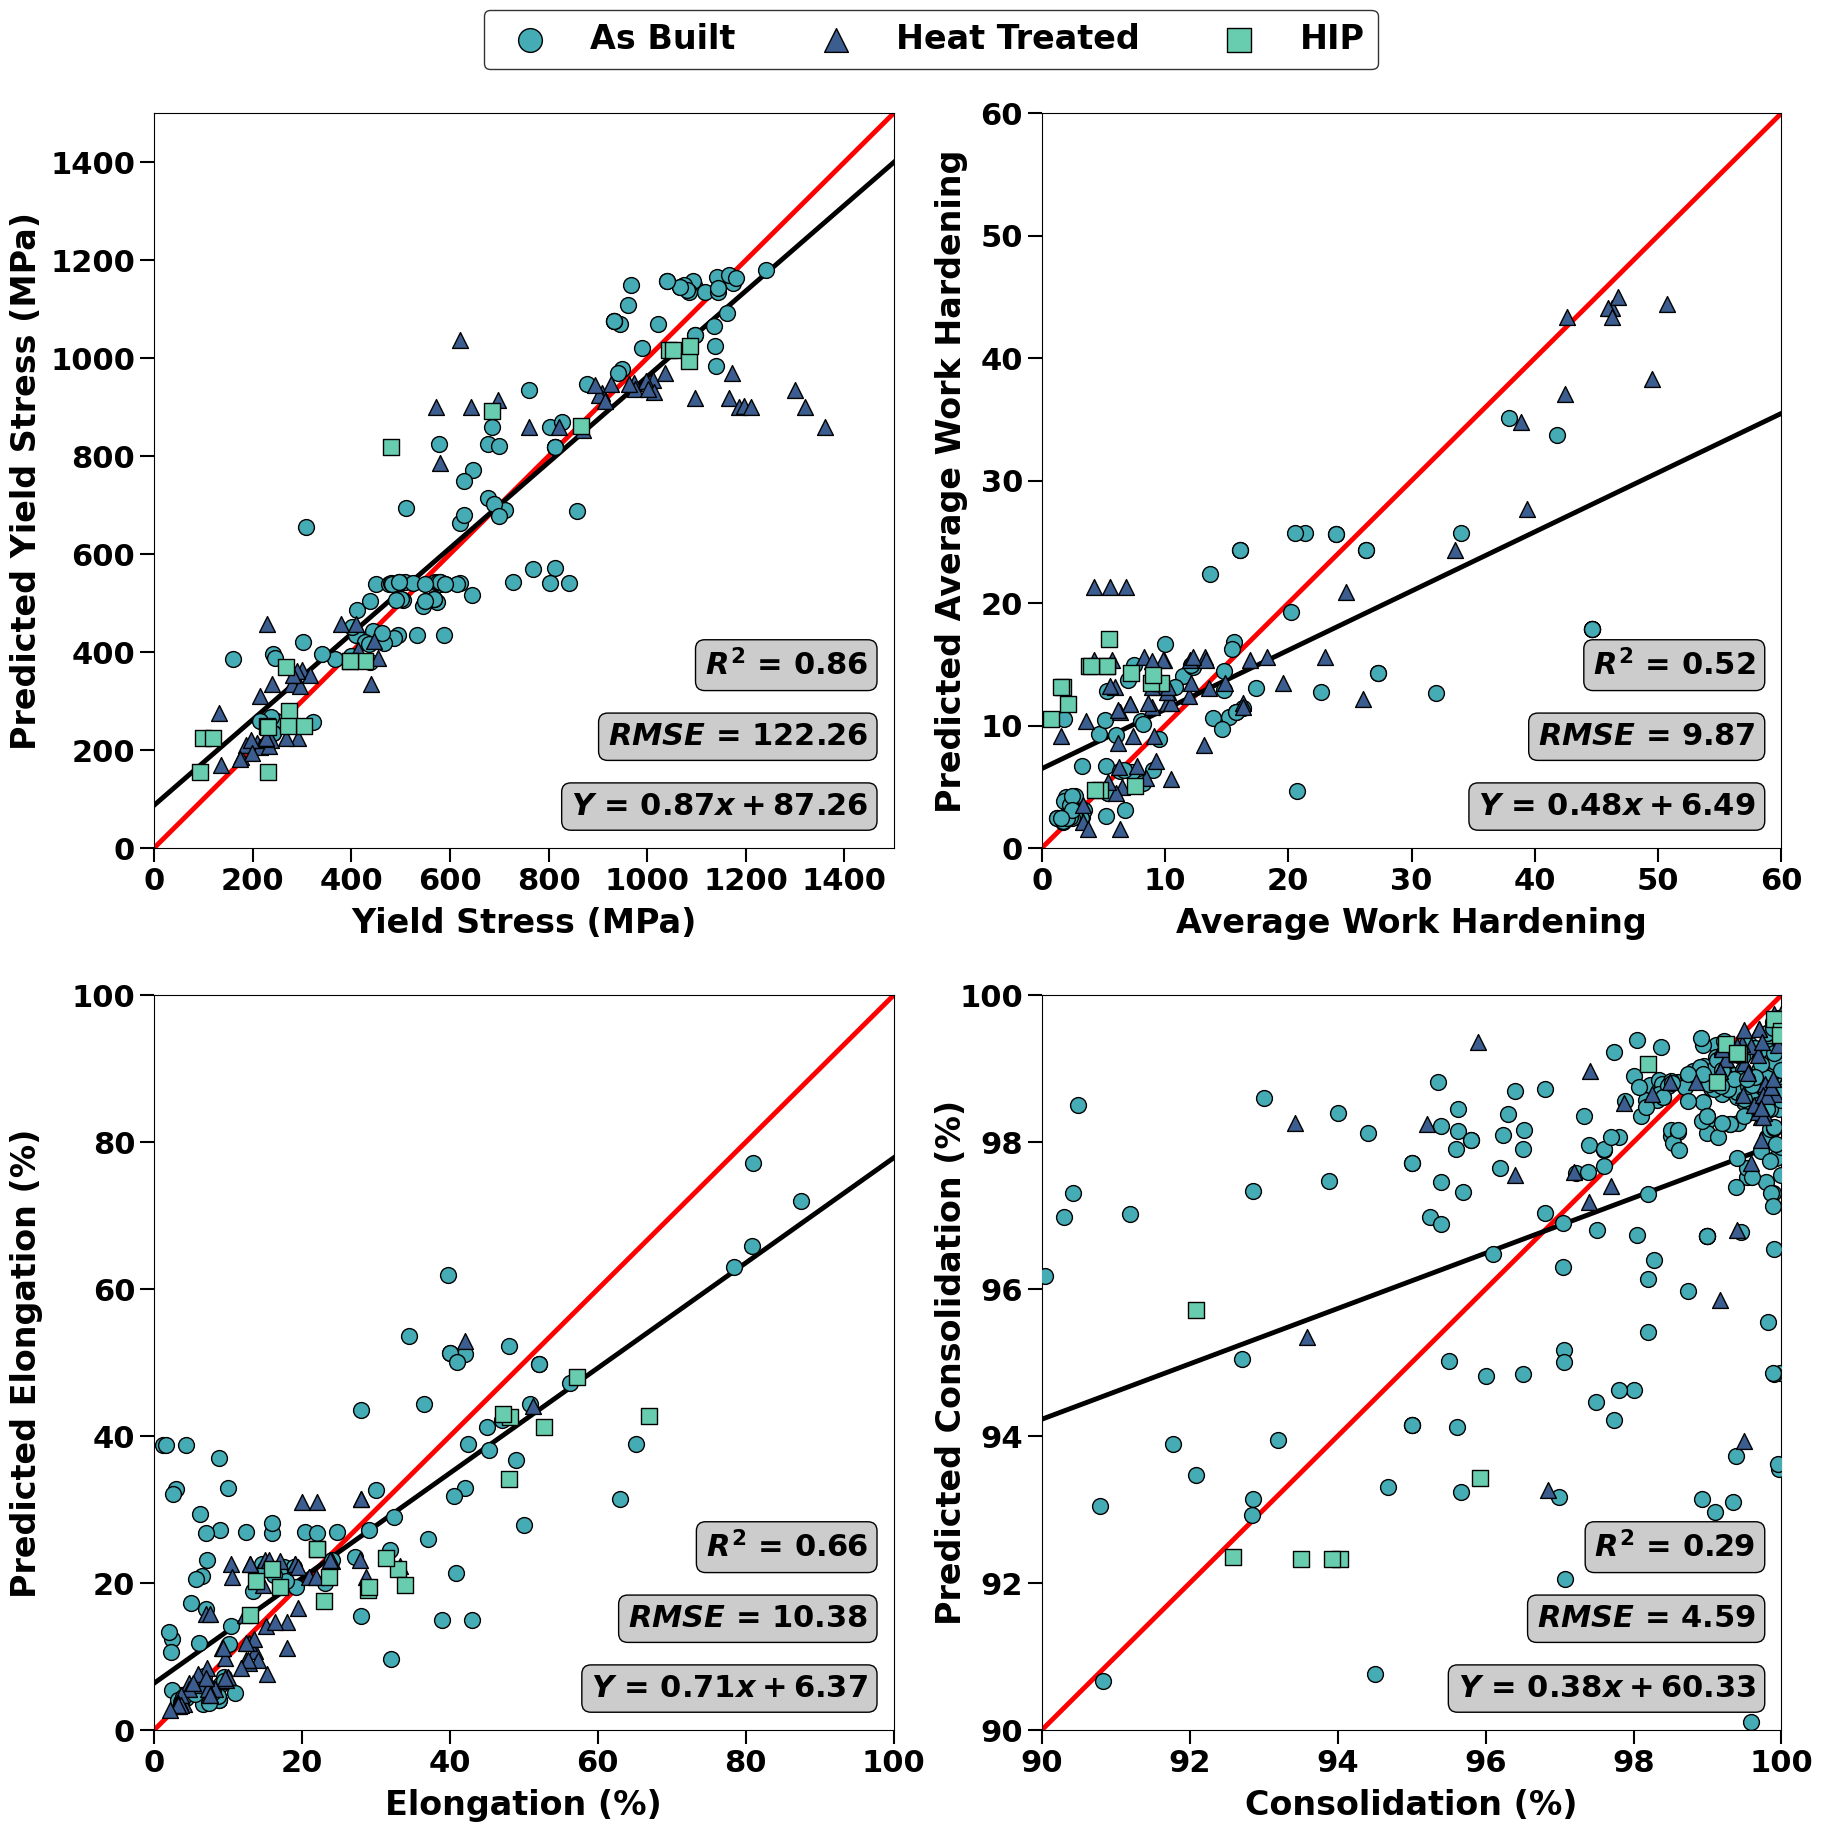

In [72]:
plot_perf()

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power o

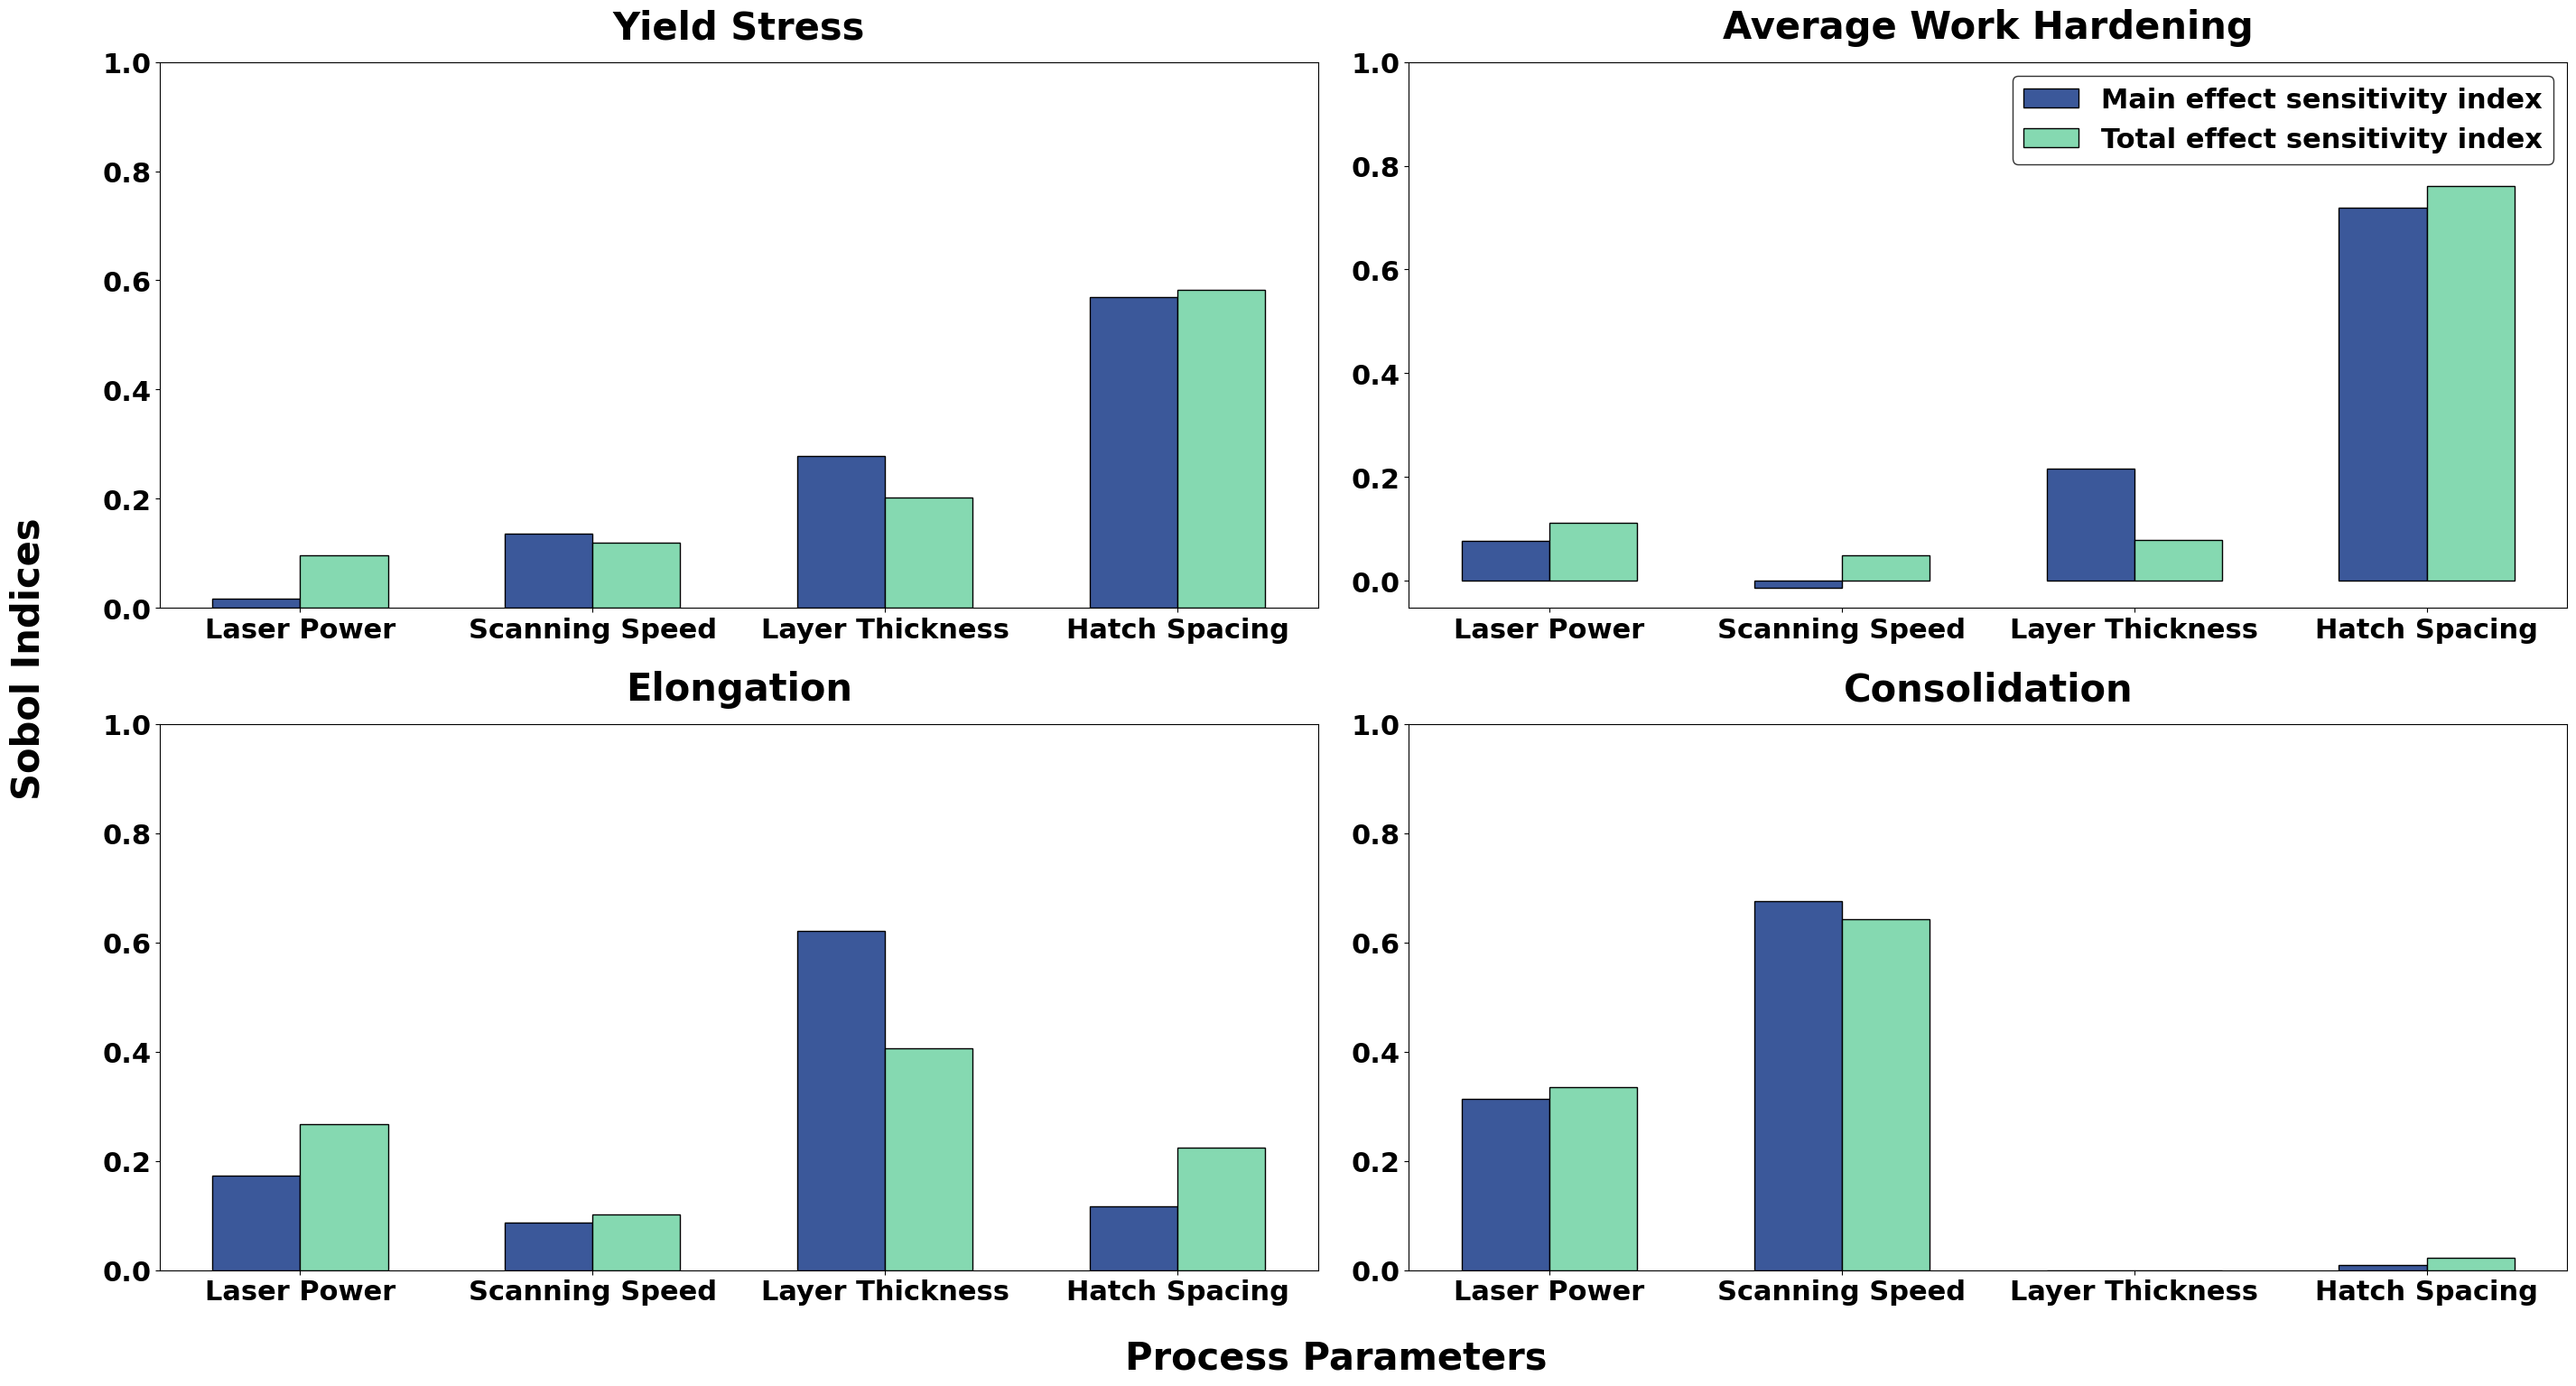

In [73]:
Plot_Sobol(leg_loc='upper right')

# ElasticNet

In [74]:
# https://stats.stackexchange.com/questions/93181/ridge-lasso-and-elastic-net
# Use Elasticnet because we want to balance between L1 and L2 penalties when dealing with correlated predictiors and feature selection is wanted 

In [75]:
def objective(trial, x, y, cv, scoring):

    param = {
        "alpha": trial.suggest_float("alpha", 0.0001, 1.0, log=True),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0),
        "tol": trial.suggest_float("alpha", 0.0001, 1.0, log=True),
        "max_iter": 10000
    }

    model = ElasticNet(**param, random_state=seed)
    cv_score = cross_val_score(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    return abs(np.mean(cv_score))

In [76]:
# Delete previous studies
optuna.delete_study(study_name="ElasticNet_yield", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="ElasticNet_hardening", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="ElasticNet_elongation", storage="sqlite:///db.sqlite3")
optuna.delete_study(study_name="ElasticNet_consolidation", storage="sqlite:///db.sqlite3")

In [77]:
%%capture capt
study_yield = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="ElasticNet_yield")
study_hardening = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="ElasticNet_hardening")
study_elongation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="ElasticNet_elongation")
study_consolidation = optuna.create_study(direction='minimize', load_if_exists=True, storage="sqlite:///db.sqlite3", study_name="ElasticNet_consolidation")
studies = [study_yield, study_hardening, study_elongation, study_consolidation]

# Splitter object for K-fold CV
kfold = KFold(n_splits = 5, shuffle=True, random_state=seed)
# Pass additional arguments inside another function to avoid errors
# https://www.kaggle.com/code/bextuychiev/no-bs-guide-to-hyperparameter-tuning-with-optuna
func = lambda trial: objective(trial, x, y, cv=kfold, scoring="neg_root_mean_squared_error")
# func = lambda trial: objective(trial, x, y, cv=kfold, scoring="r2")
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    studies[i].optimize(func, n_trials=50)

[I 2024-04-19 13:28:48,164] A new study created in RDB with name: ElasticNet_yield
[I 2024-04-19 13:28:48,192] A new study created in RDB with name: ElasticNet_hardening
[I 2024-04-19 13:28:48,209] A new study created in RDB with name: ElasticNet_elongation
[I 2024-04-19 13:28:48,229] A new study created in RDB with name: ElasticNet_consolidation
[I 2024-04-19 13:28:48,287] Trial 0 finished with value: 181.9429927266054 and parameters: {'alpha': 0.01943767555084497, 'l1_ratio': 0.5239018235258767}. Best is trial 0 with value: 181.9429927266054.
[I 2024-04-19 13:28:48,329] Trial 1 finished with value: 181.0699422727074 and parameters: {'alpha': 0.00186653193431177, 'l1_ratio': 0.2780672112726533}. Best is trial 1 with value: 181.0699422727074.
[I 2024-04-19 13:28:48,361] Trial 2 finished with value: 181.60161019063548 and parameters: {'alpha': 0.008546704549297655, 'l1_ratio': 0.3082633566855014}. Best is trial 1 with value: 181.0699422727074.
[I 2024-04-19 13:28:48,392] Trial 3 finishe

In [ ]:
# http://localhost:8080/dashboard
!optuna-dashboard sqlite:///db.sqlite3b

In [78]:
# Save parameters to excel
for i, study in enumerate(studies):
    trials_df = study.trials_dataframe()
    trials_df.to_excel(f"/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/ElasticNet/ElasticNet_{i:02d}.xlsx")

    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/ElasticNet/ElasticNet_best_params_{i:02d}.json', 'w+') as f:
        json.dump(study.best_params, f)
    with open(f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/ElasticNet/ElasticNet_best_value_{i:02d}.json', 'w+') as f:
        json.dump(study.best_value, f)

In [79]:
# Train with best hyperparameters
hyp_params = []
for i, study in enumerate(studies):
    path = f'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Models/ElasticNet/ElasticNet_best_params_{i:02d}.json'
    with open(path, "r") as f:
        hyp_params.append(json.load(f))

In [80]:
models = []
predictions = []
for i,data in enumerate(train_scaled):
    x = data[0]
    y = data[1]

    model = ElasticNet(**hyp_params[i])
    model.fit(x, y)
    predictions.append((model.predict(test_scaled[i][0])))
    models.append(model)

# Convert consolidation predictions back to original scale
predictions[3] = np.power(10, predictions[3])

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e+05, tolerance: 9.957e+03
  model = cd_fast.enet_coordinate_descent(


Yield Stress (MPa)
Mean squared error, RMSE = 165.42
Coefficient of determination, r2 = 0.75
Average Work Hardening
Mean squared error, RMSE = 12.35
Coefficient of determination, r2 = 0.25
Elongation (%)
Mean squared error, RMSE = 14.45
Coefficient of determination, r2 = 0.33
Consolidation (%)
Mean squared error, RMSE = 5.34
Coefficient of determination, r2 = 0.05


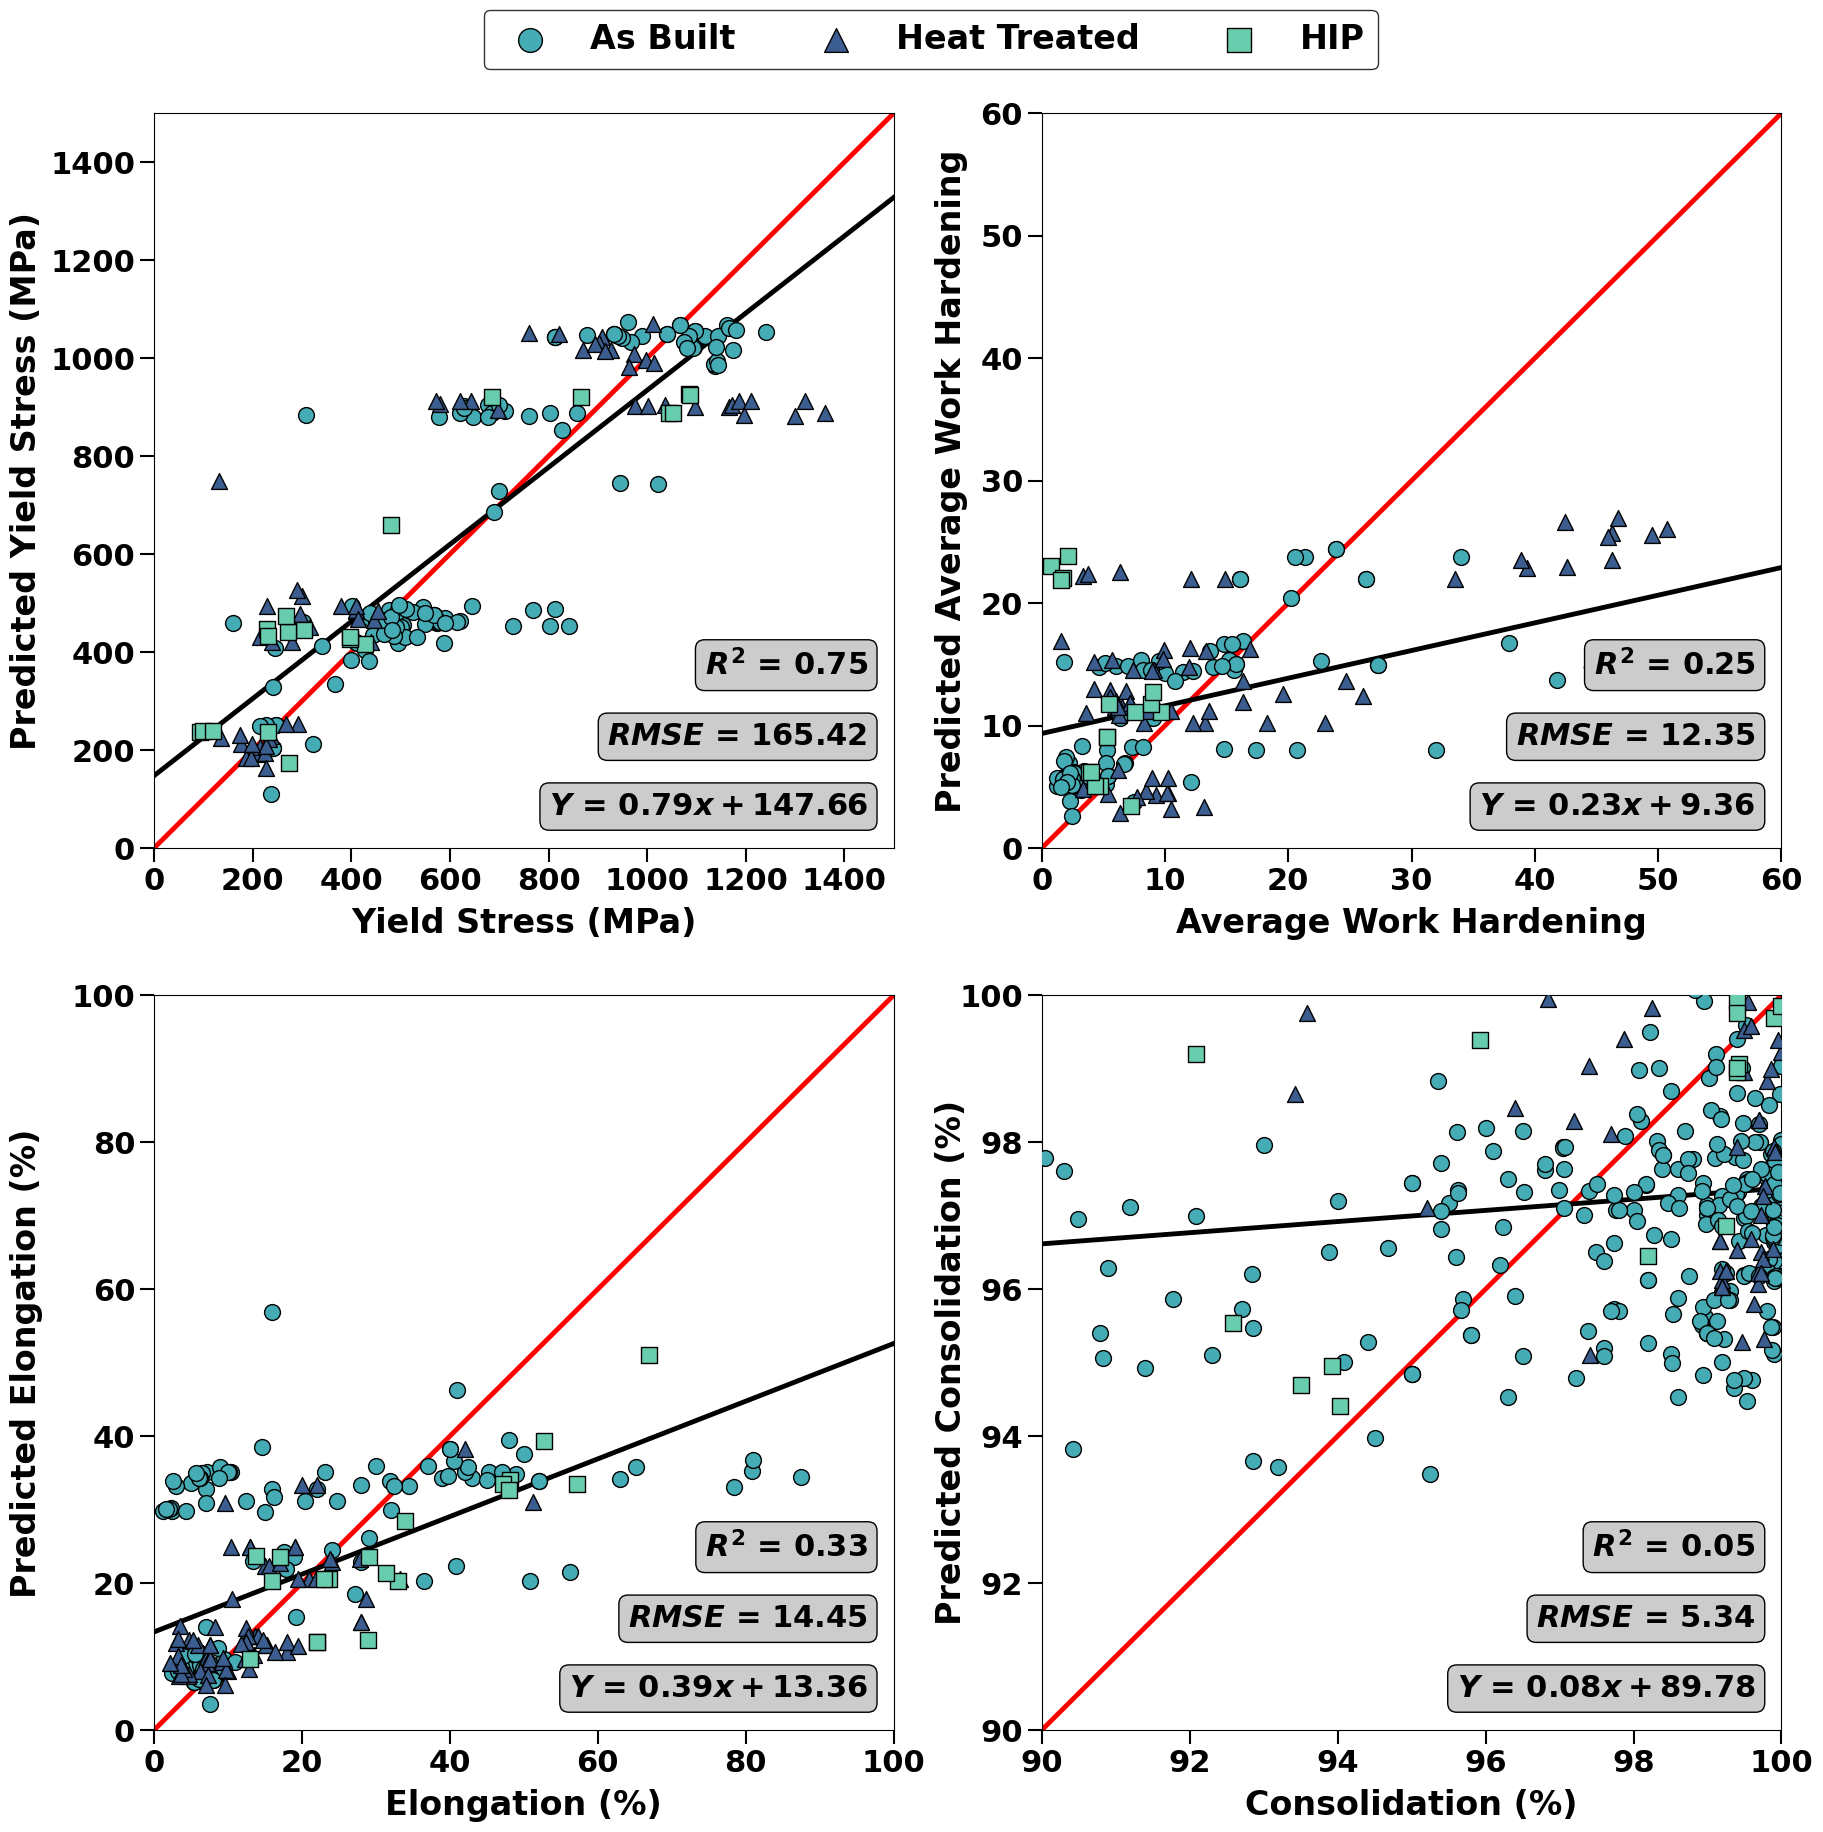

In [81]:
plot_perf()

/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(
/Users/rww21/miniforge3/envs/EDA/lib/python3.9/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._

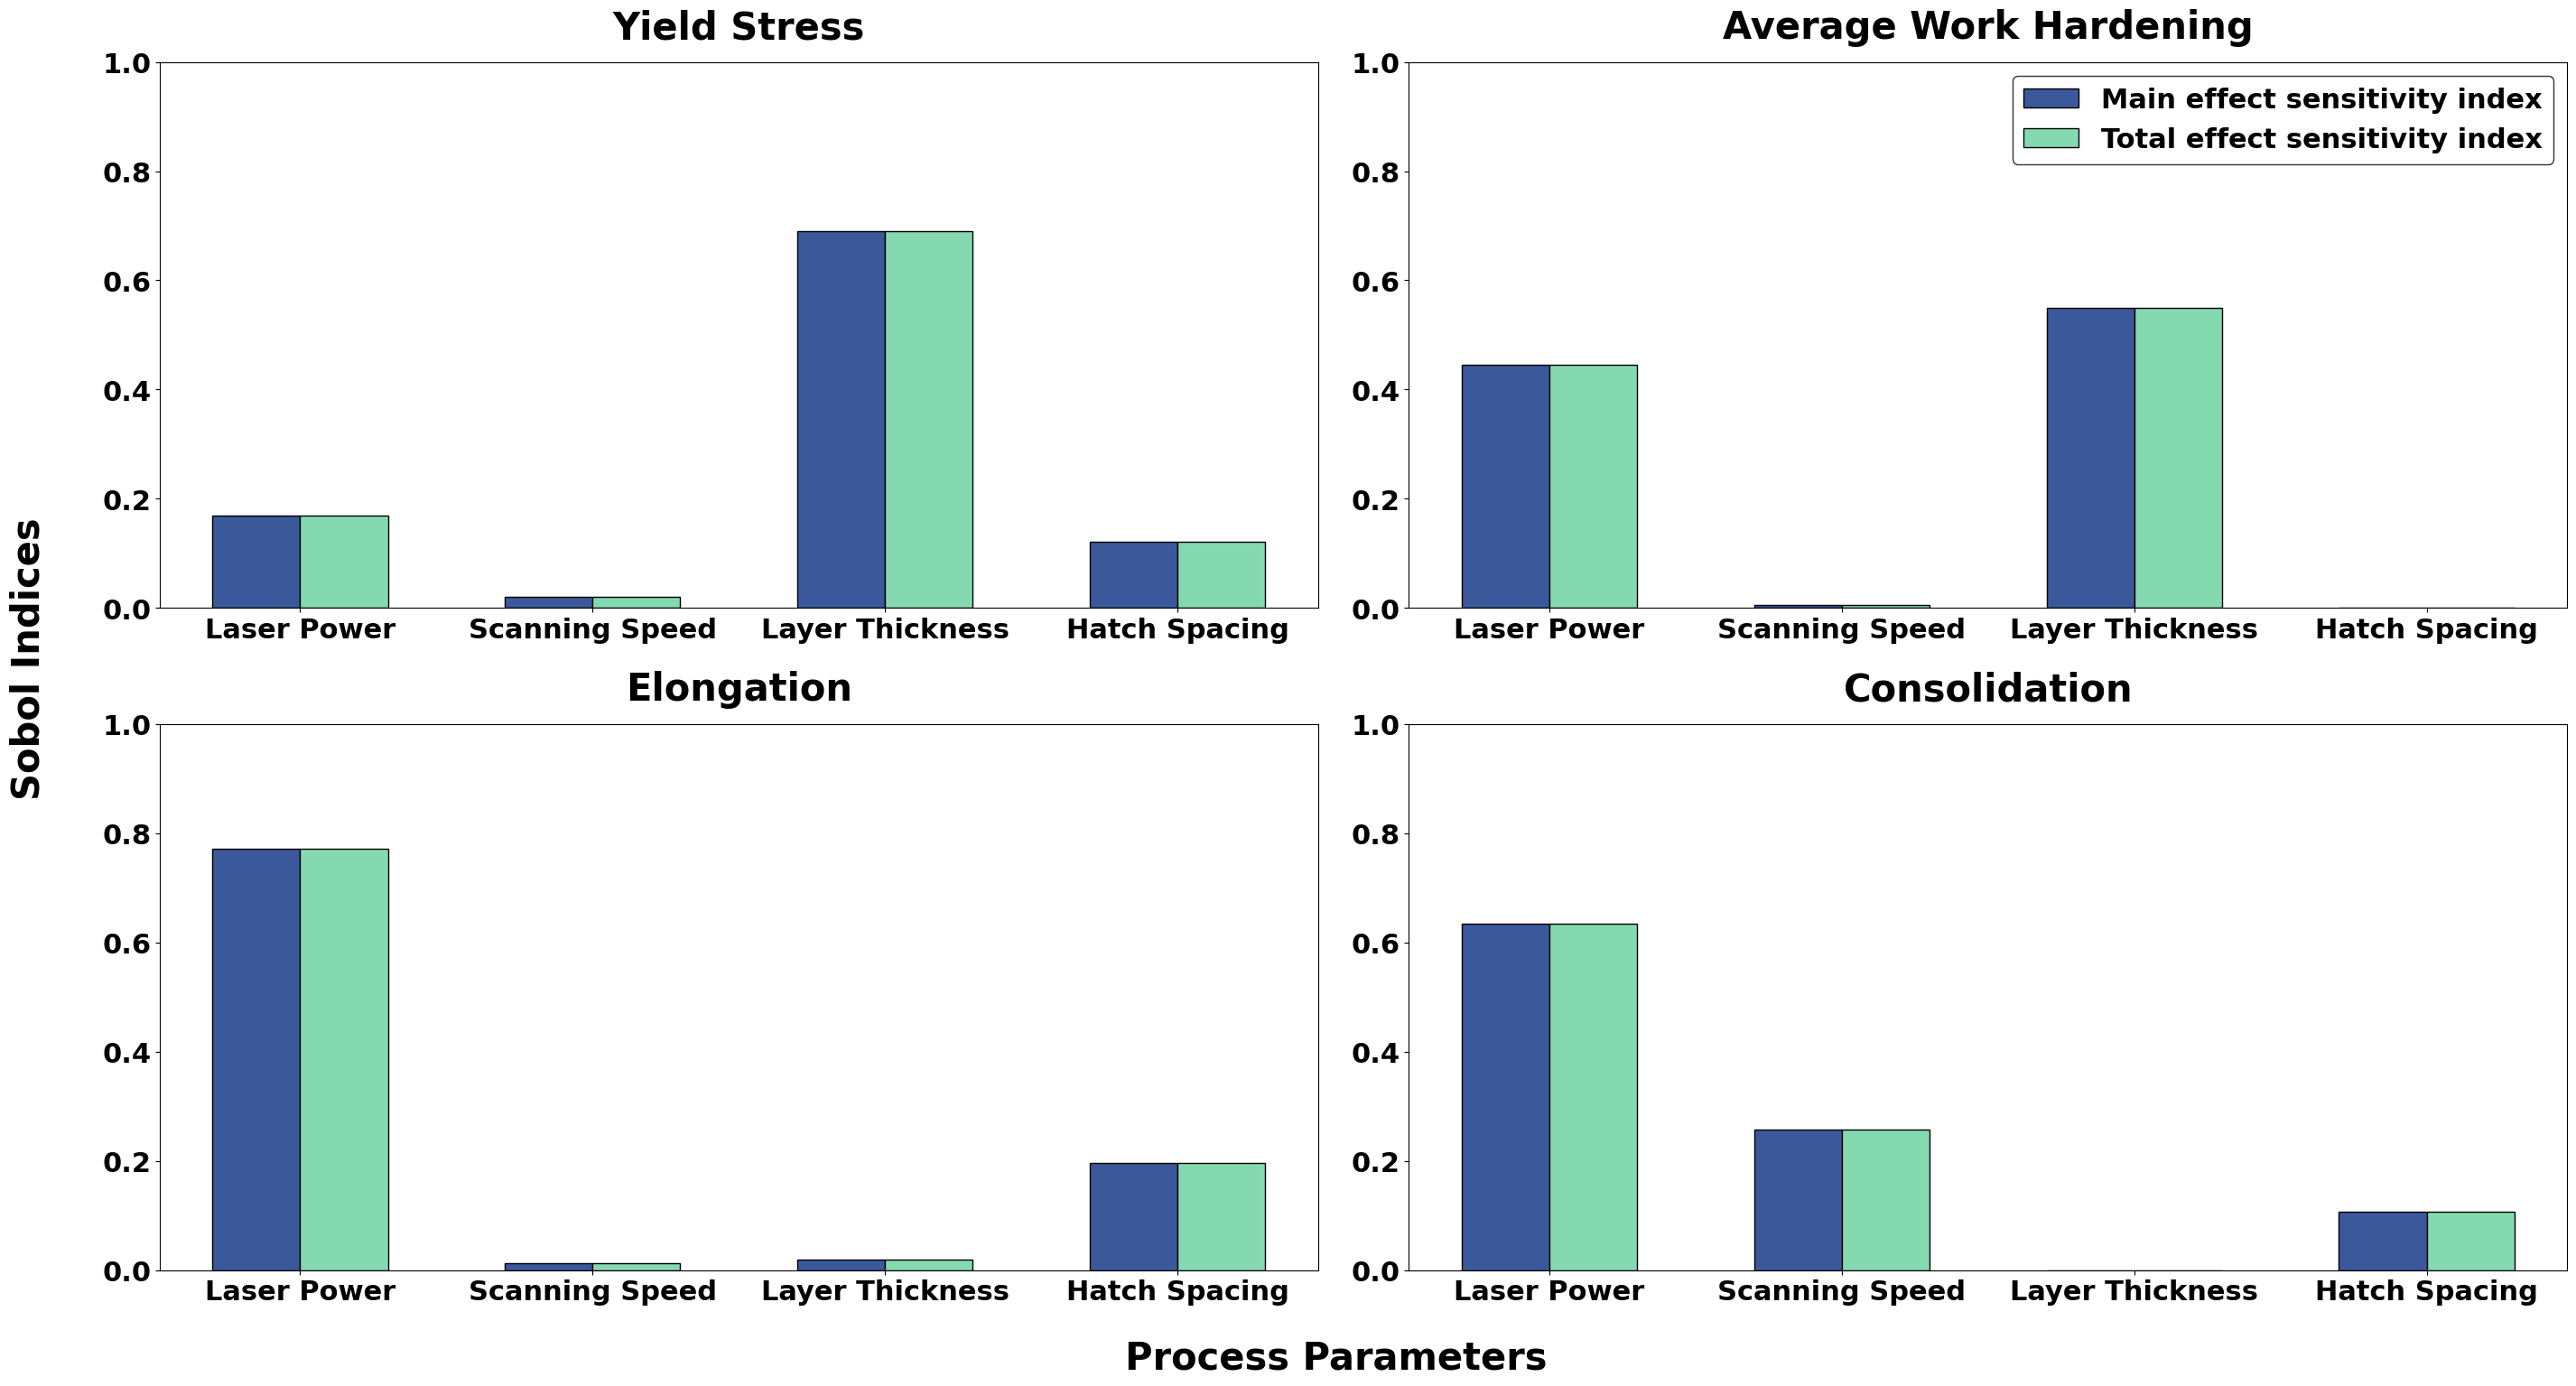

In [82]:
Plot_Sobol(leg_loc='upper right')